In [1]:
import os
from pprint import pprint
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import data
import models
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Reduces tensorflow messages.

In [2]:
UNITS = 100
OUTPUT_SIZE = 28

In [3]:
EPOCHS = 300
VERBOSE = 2
EVAL_VERBOSE = 0

In [4]:
EXAMPLE_COUTRIES = ["United Kingdom", "Germany", "France", "Spain", "Italy"]

In [5]:
ACTIVATIONS = {"tanh" : tf.keras.activations.tanh,
               "relu" : tf.keras.activations.relu}

In [6]:
RNN_LAYERS = {"lstm" : tf.keras.layers.LSTM,
              "gru" : tf.keras.layers.GRU}

In [7]:
COMPILE_PARAMS = {"optimizer" : tf.keras.optimizers.Adam(),
                  "loss" : tf.keras.losses.MeanSquaredError(),
                  "metrics" : [tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError()]}

In [8]:
QUANTILE_LOSSES = [tfa.losses.PinballLoss(tau=0.05), tfa.losses.PinballLoss(tau=0.5), tfa.losses.PinballLoss(tau=0.95)]

The multi output quantile model requires a quantile loss for each output node.

In [9]:
MULTI_QUANTILE_LOSSES = [QUANTILE_LOSSES for _  in range(len(QUANTILE_LOSSES))]  # Make copies.
MULTI_QUANTILE_LOSSES = [item for sublist in MULTI_QUANTILE_LOSSES for item in sublist]  # Flatten list of lists.

In [10]:
QUANTILE_METRICS = [tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError(),
                    tfa.losses.PinballLoss(tau=0.05, name="q0.05"),
                    tfa.losses.PinballLoss(tau=0.5, name="q0.5"),
                    tfa.losses.PinballLoss(tau=0.95, name="q0.95")]

Load and prepare data.

In [11]:
COVID_DATA = data.Data()
COVID_DATA.split_train_test(OUTPUT_SIZE)
COVID_DATA.standarize_data()
enc_names = COVID_DATA.encode_names()
train_x, train_y, test_x, test_y = COVID_DATA.retreive_data()
multi_train_y = COVID_DATA.make_multi_output_data(train_y)
multi_test_y = COVID_DATA.make_multi_output_data(test_y)

Create train and test datasets.

In [12]:
INPUT_TRAIN_DATA = [train_x, enc_names]
OUTPUT_TRAIN_DATA = {"multiOutput" : [multi_train_y[0], multi_train_y[1], multi_train_y[2]],
                     "singleOutput" : [train_y],
                     "multiOutQuant" : [multi_train_y[0], multi_train_y[0], multi_train_y[0],
                                        multi_train_y[1], multi_train_y[1], multi_train_y[1],
                                        multi_train_y[2], multi_train_y[2], multi_train_y[2]],
                     "singleOutQuant" : [train_y, train_y, train_y]}

In [13]:
INPUT_TEST_DATA = [test_x, enc_names]
OUTPUT_TEST_DATA = {"multiOutput" : [multi_test_y[0], multi_test_y[1], multi_test_y[2]],
                    "singleOutput" : [test_y],
                    "multiOutQuant" : [multi_test_y[0], multi_test_y[0], multi_test_y[0],
                                       multi_test_y[1], multi_test_y[1], multi_test_y[1],
                                       multi_test_y[2], multi_test_y[2], multi_test_y[2]],
                    "singleOutQuant" : [test_y, test_y, test_y]}

Create models.

In [14]:
MULTI_MODELS = {"multiOutIndvLstm" : models.RNNMultiOutputIndividual(OUTPUT_SIZE, UNITS, RNN_LAYERS["lstm"], ACTIVATIONS["tanh"]),
                "multiOutSharedLstm" : models.RNNMultiOutputShared(OUTPUT_SIZE, UNITS, RNN_LAYERS["lstm"], ACTIVATIONS["tanh"]),
                "multiOutIndvGru" : models.RNNMultiOutputIndividual(OUTPUT_SIZE, UNITS, RNN_LAYERS["gru"], ACTIVATIONS["tanh"]),
                "multiOutSharedGru" : models.RNNMultiOutputShared(OUTPUT_SIZE, UNITS, RNN_LAYERS["gru"], ACTIVATIONS["tanh"])}

In [15]:
SINGLE_MODELS = {"singleOutSharedLstm" : models.RNNSingleOutput(OUTPUT_SIZE, UNITS, RNN_LAYERS["lstm"], ACTIVATIONS["tanh"]),
                 "singleOutSharedGru" : models.RNNSingleOutput(OUTPUT_SIZE, UNITS, RNN_LAYERS["gru"], ACTIVATIONS["tanh"])}

In [16]:
MULTI_QUANTILE_MODELS = {"multiOutQuantLstm" : models.RNNMultiOutputQuantile(OUTPUT_SIZE, UNITS, RNN_LAYERS["lstm"],
                                                                             ACTIVATIONS["tanh"]),
                         "multiOutQuantGru" : models.RNNMultiOutputQuantile(OUTPUT_SIZE, UNITS, RNN_LAYERS["gru"],
                                                                            ACTIVATIONS["tanh"])}

In [17]:
SINGLE_QUANTILE_MODELS = {"singleOutQuantLstm" : models.RNNSingleOutputQuantile(OUTPUT_SIZE, UNITS, RNN_LAYERS["lstm"],
                                                                                ACTIVATIONS["tanh"]),
                          "singleOutQuantGru" : models.RNNSingleOutputQuantile(OUTPUT_SIZE, UNITS, RNN_LAYERS["gru"],
                                                                               ACTIVATIONS["tanh"])}

Compile models.

In [18]:
def compile_models(model_dict, losses, metrics):
    for name, model in model_dict.items():
        print(f"Compiling model: {name}")
        models.compileModel(model, COMPILE_PARAMS["optimizer"], losses, metrics)

In [19]:
compile_models(MULTI_MODELS, COMPILE_PARAMS["loss"], COMPILE_PARAMS["metrics"])
compile_models(SINGLE_MODELS, COMPILE_PARAMS["loss"], COMPILE_PARAMS["metrics"])
compile_models(MULTI_QUANTILE_MODELS, MULTI_QUANTILE_LOSSES, QUANTILE_METRICS)
compile_models(SINGLE_QUANTILE_MODELS, QUANTILE_LOSSES, QUANTILE_METRICS)

Compiling model: multiOutIndvLstm
Compiling model: multiOutSharedLstm
Compiling model: multiOutIndvGru
Compiling model: multiOutSharedGru
Compiling model: singleOutSharedLstm
Compiling model: singleOutSharedGru
Compiling model: multiOutQuantLstm
Compiling model: multiOutQuantGru
Compiling model: singleOutQuantLstm
Compiling model: singleOutQuantGru


Train models.

In [20]:
def train_models(model_dict, out_data):
    models_hist = {}
    for name, model in model_dict.items():
        print(f"Training model: {name}")
        models_hist[name] = models.fitModel(model, x=INPUT_TRAIN_DATA, y=OUTPUT_TRAIN_DATA[out_data], epochs=EPOCHS)
    return models_hist

In [21]:
multi_out_hist = train_models(MULTI_MODELS, "multiOutput")
single_out_hist = train_models(SINGLE_MODELS, "singleOutput")
multi_quantile_out_hist = train_models(MULTI_QUANTILE_MODELS, "multiOutQuant")
single_quantile_out_hist = train_models(SINGLE_QUANTILE_MODELS, "singleOutQuant")

Training model: multiOutIndvLstm
Epoch 1/300
6/6 - 0s - loss: 9.1162 - output_1_loss: 2.8191 - output_2_loss: 3.2878 - output_3_loss: 3.0092 - output_1_mean_squared_error: 2.8191 - output_1_root_mean_squared_error: 1.6790 - output_2_mean_squared_error: 3.2878 - output_2_root_mean_squared_error: 1.8132 - output_3_mean_squared_error: 3.0092 - output_3_root_mean_squared_error: 1.7347
Epoch 2/300
6/6 - 0s - loss: 5.8571 - output_1_loss: 1.8162 - output_2_loss: 2.1638 - output_3_loss: 1.8771 - output_1_mean_squared_error: 1.8162 - output_1_root_mean_squared_error: 1.3477 - output_2_mean_squared_error: 2.1638 - output_2_root_mean_squared_error: 1.4710 - output_3_mean_squared_error: 1.8771 - output_3_root_mean_squared_error: 1.3701
Epoch 3/300
6/6 - 0s - loss: 3.3178 - output_1_loss: 0.9922 - output_2_loss: 1.3138 - output_3_loss: 1.0118 - output_1_mean_squared_error: 0.9922 - output_1_root_mean_squared_error: 0.9961 - output_2_mean_squared_error: 1.3138 - output_2_root_mean_squared_error: 1.

Epoch 25/300
6/6 - 0s - loss: 0.8161 - output_1_loss: 0.1933 - output_2_loss: 0.3461 - output_3_loss: 0.2768 - output_1_mean_squared_error: 0.1933 - output_1_root_mean_squared_error: 0.4396 - output_2_mean_squared_error: 0.3461 - output_2_root_mean_squared_error: 0.5883 - output_3_mean_squared_error: 0.2768 - output_3_root_mean_squared_error: 0.5261
Epoch 26/300
6/6 - 0s - loss: 0.8012 - output_1_loss: 0.1900 - output_2_loss: 0.3391 - output_3_loss: 0.2721 - output_1_mean_squared_error: 0.1900 - output_1_root_mean_squared_error: 0.4359 - output_2_mean_squared_error: 0.3391 - output_2_root_mean_squared_error: 0.5823 - output_3_mean_squared_error: 0.2721 - output_3_root_mean_squared_error: 0.5216
Epoch 27/300
6/6 - 0s - loss: 0.7811 - output_1_loss: 0.1854 - output_2_loss: 0.3294 - output_3_loss: 0.2663 - output_1_mean_squared_error: 0.1854 - output_1_root_mean_squared_error: 0.4306 - output_2_mean_squared_error: 0.3294 - output_2_root_mean_squared_error: 0.5740 - output_3_mean_squared_e

Epoch 49/300
6/6 - 0s - loss: 0.5475 - output_1_loss: 0.1214 - output_2_loss: 0.2334 - output_3_loss: 0.1927 - output_1_mean_squared_error: 0.1214 - output_1_root_mean_squared_error: 0.3484 - output_2_mean_squared_error: 0.2334 - output_2_root_mean_squared_error: 0.4831 - output_3_mean_squared_error: 0.1927 - output_3_root_mean_squared_error: 0.4390
Epoch 50/300
6/6 - 0s - loss: 0.5421 - output_1_loss: 0.1192 - output_2_loss: 0.2320 - output_3_loss: 0.1909 - output_1_mean_squared_error: 0.1192 - output_1_root_mean_squared_error: 0.3453 - output_2_mean_squared_error: 0.2320 - output_2_root_mean_squared_error: 0.4817 - output_3_mean_squared_error: 0.1909 - output_3_root_mean_squared_error: 0.4369
Epoch 51/300
6/6 - 0s - loss: 0.5356 - output_1_loss: 0.1175 - output_2_loss: 0.2295 - output_3_loss: 0.1886 - output_1_mean_squared_error: 0.1175 - output_1_root_mean_squared_error: 0.3428 - output_2_mean_squared_error: 0.2295 - output_2_root_mean_squared_error: 0.4791 - output_3_mean_squared_e

Epoch 73/300
6/6 - 0s - loss: 0.4414 - output_1_loss: 0.0906 - output_2_loss: 0.1946 - output_3_loss: 0.1562 - output_1_mean_squared_error: 0.0906 - output_1_root_mean_squared_error: 0.3010 - output_2_mean_squared_error: 0.1946 - output_2_root_mean_squared_error: 0.4412 - output_3_mean_squared_error: 0.1562 - output_3_root_mean_squared_error: 0.3952
Epoch 74/300
6/6 - 0s - loss: 0.4402 - output_1_loss: 0.0899 - output_2_loss: 0.1948 - output_3_loss: 0.1554 - output_1_mean_squared_error: 0.0899 - output_1_root_mean_squared_error: 0.2999 - output_2_mean_squared_error: 0.1948 - output_2_root_mean_squared_error: 0.4414 - output_3_mean_squared_error: 0.1554 - output_3_root_mean_squared_error: 0.3942
Epoch 75/300
6/6 - 0s - loss: 0.4354 - output_1_loss: 0.0897 - output_2_loss: 0.1902 - output_3_loss: 0.1556 - output_1_mean_squared_error: 0.0897 - output_1_root_mean_squared_error: 0.2994 - output_2_mean_squared_error: 0.1902 - output_2_root_mean_squared_error: 0.4361 - output_3_mean_squared_e

Epoch 97/300
6/6 - 0s - loss: 0.3805 - output_1_loss: 0.0769 - output_2_loss: 0.1650 - output_3_loss: 0.1385 - output_1_mean_squared_error: 0.0769 - output_1_root_mean_squared_error: 0.2773 - output_2_mean_squared_error: 0.1650 - output_2_root_mean_squared_error: 0.4063 - output_3_mean_squared_error: 0.1385 - output_3_root_mean_squared_error: 0.3722
Epoch 98/300
6/6 - 0s - loss: 0.3842 - output_1_loss: 0.0767 - output_2_loss: 0.1681 - output_3_loss: 0.1394 - output_1_mean_squared_error: 0.0767 - output_1_root_mean_squared_error: 0.2770 - output_2_mean_squared_error: 0.1681 - output_2_root_mean_squared_error: 0.4100 - output_3_mean_squared_error: 0.1394 - output_3_root_mean_squared_error: 0.3733
Epoch 99/300
6/6 - 0s - loss: 0.3778 - output_1_loss: 0.0764 - output_2_loss: 0.1645 - output_3_loss: 0.1369 - output_1_mean_squared_error: 0.0764 - output_1_root_mean_squared_error: 0.2763 - output_2_mean_squared_error: 0.1645 - output_2_root_mean_squared_error: 0.4056 - output_3_mean_squared_e

Epoch 121/300
6/6 - 0s - loss: 0.3965 - output_1_loss: 0.0753 - output_2_loss: 0.1731 - output_3_loss: 0.1482 - output_1_mean_squared_error: 0.0753 - output_1_root_mean_squared_error: 0.2743 - output_2_mean_squared_error: 0.1731 - output_2_root_mean_squared_error: 0.4160 - output_3_mean_squared_error: 0.1482 - output_3_root_mean_squared_error: 0.3849
Epoch 122/300
6/6 - 0s - loss: 0.3929 - output_1_loss: 0.0746 - output_2_loss: 0.1708 - output_3_loss: 0.1475 - output_1_mean_squared_error: 0.0746 - output_1_root_mean_squared_error: 0.2732 - output_2_mean_squared_error: 0.1708 - output_2_root_mean_squared_error: 0.4132 - output_3_mean_squared_error: 0.1475 - output_3_root_mean_squared_error: 0.3840
Epoch 123/300
6/6 - 0s - loss: 0.3892 - output_1_loss: 0.0759 - output_2_loss: 0.1682 - output_3_loss: 0.1452 - output_1_mean_squared_error: 0.0759 - output_1_root_mean_squared_error: 0.2755 - output_2_mean_squared_error: 0.1682 - output_2_root_mean_squared_error: 0.4101 - output_3_mean_square

Epoch 145/300
6/6 - 0s - loss: 0.3430 - output_1_loss: 0.0654 - output_2_loss: 0.1503 - output_3_loss: 0.1273 - output_1_mean_squared_error: 0.0654 - output_1_root_mean_squared_error: 0.2557 - output_2_mean_squared_error: 0.1503 - output_2_root_mean_squared_error: 0.3877 - output_3_mean_squared_error: 0.1273 - output_3_root_mean_squared_error: 0.3568
Epoch 146/300
6/6 - 0s - loss: 0.3419 - output_1_loss: 0.0642 - output_2_loss: 0.1495 - output_3_loss: 0.1282 - output_1_mean_squared_error: 0.0642 - output_1_root_mean_squared_error: 0.2533 - output_2_mean_squared_error: 0.1495 - output_2_root_mean_squared_error: 0.3867 - output_3_mean_squared_error: 0.1282 - output_3_root_mean_squared_error: 0.3581
Epoch 147/300
6/6 - 0s - loss: 0.3525 - output_1_loss: 0.0701 - output_2_loss: 0.1551 - output_3_loss: 0.1273 - output_1_mean_squared_error: 0.0701 - output_1_root_mean_squared_error: 0.2648 - output_2_mean_squared_error: 0.1551 - output_2_root_mean_squared_error: 0.3938 - output_3_mean_square

Epoch 169/300
6/6 - 0s - loss: 0.3264 - output_1_loss: 0.0657 - output_2_loss: 0.1407 - output_3_loss: 0.1200 - output_1_mean_squared_error: 0.0657 - output_1_root_mean_squared_error: 0.2563 - output_2_mean_squared_error: 0.1407 - output_2_root_mean_squared_error: 0.3751 - output_3_mean_squared_error: 0.1200 - output_3_root_mean_squared_error: 0.3464
Epoch 170/300
6/6 - 0s - loss: 0.3278 - output_1_loss: 0.0667 - output_2_loss: 0.1427 - output_3_loss: 0.1184 - output_1_mean_squared_error: 0.0667 - output_1_root_mean_squared_error: 0.2583 - output_2_mean_squared_error: 0.1427 - output_2_root_mean_squared_error: 0.3778 - output_3_mean_squared_error: 0.1184 - output_3_root_mean_squared_error: 0.3441
Epoch 171/300
6/6 - 0s - loss: 0.3264 - output_1_loss: 0.0653 - output_2_loss: 0.1441 - output_3_loss: 0.1169 - output_1_mean_squared_error: 0.0653 - output_1_root_mean_squared_error: 0.2555 - output_2_mean_squared_error: 0.1441 - output_2_root_mean_squared_error: 0.3796 - output_3_mean_square

Epoch 193/300
6/6 - 0s - loss: 0.3280 - output_1_loss: 0.0673 - output_2_loss: 0.1386 - output_3_loss: 0.1220 - output_1_mean_squared_error: 0.0673 - output_1_root_mean_squared_error: 0.2595 - output_2_mean_squared_error: 0.1386 - output_2_root_mean_squared_error: 0.3723 - output_3_mean_squared_error: 0.1220 - output_3_root_mean_squared_error: 0.3493
Epoch 194/300
6/6 - 0s - loss: 0.3343 - output_1_loss: 0.0669 - output_2_loss: 0.1423 - output_3_loss: 0.1251 - output_1_mean_squared_error: 0.0669 - output_1_root_mean_squared_error: 0.2586 - output_2_mean_squared_error: 0.1423 - output_2_root_mean_squared_error: 0.3772 - output_3_mean_squared_error: 0.1251 - output_3_root_mean_squared_error: 0.3537
Epoch 195/300
6/6 - 0s - loss: 0.3226 - output_1_loss: 0.0650 - output_2_loss: 0.1427 - output_3_loss: 0.1149 - output_1_mean_squared_error: 0.0650 - output_1_root_mean_squared_error: 0.2550 - output_2_mean_squared_error: 0.1427 - output_2_root_mean_squared_error: 0.3777 - output_3_mean_square

Epoch 217/300
6/6 - 0s - loss: 0.3038 - output_1_loss: 0.0609 - output_2_loss: 0.1318 - output_3_loss: 0.1111 - output_1_mean_squared_error: 0.0609 - output_1_root_mean_squared_error: 0.2467 - output_2_mean_squared_error: 0.1318 - output_2_root_mean_squared_error: 0.3630 - output_3_mean_squared_error: 0.1111 - output_3_root_mean_squared_error: 0.3333
Epoch 218/300
6/6 - 0s - loss: 0.2967 - output_1_loss: 0.0596 - output_2_loss: 0.1311 - output_3_loss: 0.1060 - output_1_mean_squared_error: 0.0596 - output_1_root_mean_squared_error: 0.2441 - output_2_mean_squared_error: 0.1311 - output_2_root_mean_squared_error: 0.3621 - output_3_mean_squared_error: 0.1060 - output_3_root_mean_squared_error: 0.3255
Epoch 219/300
6/6 - 0s - loss: 0.2932 - output_1_loss: 0.0583 - output_2_loss: 0.1289 - output_3_loss: 0.1059 - output_1_mean_squared_error: 0.0583 - output_1_root_mean_squared_error: 0.2415 - output_2_mean_squared_error: 0.1289 - output_2_root_mean_squared_error: 0.3591 - output_3_mean_square

Epoch 241/300
6/6 - 0s - loss: 0.2966 - output_1_loss: 0.0578 - output_2_loss: 0.1323 - output_3_loss: 0.1065 - output_1_mean_squared_error: 0.0578 - output_1_root_mean_squared_error: 0.2403 - output_2_mean_squared_error: 0.1323 - output_2_root_mean_squared_error: 0.3638 - output_3_mean_squared_error: 0.1065 - output_3_root_mean_squared_error: 0.3264
Epoch 242/300
6/6 - 0s - loss: 0.2930 - output_1_loss: 0.0553 - output_2_loss: 0.1318 - output_3_loss: 0.1058 - output_1_mean_squared_error: 0.0553 - output_1_root_mean_squared_error: 0.2351 - output_2_mean_squared_error: 0.1318 - output_2_root_mean_squared_error: 0.3631 - output_3_mean_squared_error: 0.1058 - output_3_root_mean_squared_error: 0.3253
Epoch 243/300
6/6 - 0s - loss: 0.2890 - output_1_loss: 0.0553 - output_2_loss: 0.1322 - output_3_loss: 0.1016 - output_1_mean_squared_error: 0.0553 - output_1_root_mean_squared_error: 0.2351 - output_2_mean_squared_error: 0.1322 - output_2_root_mean_squared_error: 0.3635 - output_3_mean_square

Epoch 265/300
6/6 - 0s - loss: 0.2671 - output_1_loss: 0.0491 - output_2_loss: 0.1204 - output_3_loss: 0.0976 - output_1_mean_squared_error: 0.0491 - output_1_root_mean_squared_error: 0.2215 - output_2_mean_squared_error: 0.1204 - output_2_root_mean_squared_error: 0.3469 - output_3_mean_squared_error: 0.0976 - output_3_root_mean_squared_error: 0.3124
Epoch 266/300
6/6 - 0s - loss: 0.2799 - output_1_loss: 0.0499 - output_2_loss: 0.1290 - output_3_loss: 0.1010 - output_1_mean_squared_error: 0.0499 - output_1_root_mean_squared_error: 0.2234 - output_2_mean_squared_error: 0.1290 - output_2_root_mean_squared_error: 0.3591 - output_3_mean_squared_error: 0.1010 - output_3_root_mean_squared_error: 0.3178
Epoch 267/300
6/6 - 0s - loss: 0.2833 - output_1_loss: 0.0525 - output_2_loss: 0.1301 - output_3_loss: 0.1007 - output_1_mean_squared_error: 0.0525 - output_1_root_mean_squared_error: 0.2292 - output_2_mean_squared_error: 0.1301 - output_2_root_mean_squared_error: 0.3607 - output_3_mean_square

Epoch 289/300
6/6 - 0s - loss: 0.2687 - output_1_loss: 0.0527 - output_2_loss: 0.1159 - output_3_loss: 0.1001 - output_1_mean_squared_error: 0.0527 - output_1_root_mean_squared_error: 0.2297 - output_2_mean_squared_error: 0.1159 - output_2_root_mean_squared_error: 0.3404 - output_3_mean_squared_error: 0.1001 - output_3_root_mean_squared_error: 0.3164
Epoch 290/300
6/6 - 0s - loss: 0.2909 - output_1_loss: 0.0517 - output_2_loss: 0.1368 - output_3_loss: 0.1023 - output_1_mean_squared_error: 0.0517 - output_1_root_mean_squared_error: 0.2275 - output_2_mean_squared_error: 0.1368 - output_2_root_mean_squared_error: 0.3699 - output_3_mean_squared_error: 0.1023 - output_3_root_mean_squared_error: 0.3199
Epoch 291/300
6/6 - 0s - loss: 0.2905 - output_1_loss: 0.0558 - output_2_loss: 0.1315 - output_3_loss: 0.1031 - output_1_mean_squared_error: 0.0558 - output_1_root_mean_squared_error: 0.2363 - output_2_mean_squared_error: 0.1315 - output_2_root_mean_squared_error: 0.3627 - output_3_mean_square

Epoch 13/300
6/6 - 0s - loss: 2.7169 - output_1_loss: 0.9627 - output_2_loss: 0.8076 - output_3_loss: 0.9466 - output_1_mean_squared_error: 0.9627 - output_1_root_mean_squared_error: 0.9812 - output_2_mean_squared_error: 0.8076 - output_2_root_mean_squared_error: 0.8987 - output_3_mean_squared_error: 0.9466 - output_3_root_mean_squared_error: 0.9729
Epoch 14/300
6/6 - 0s - loss: 2.7168 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9466 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9466 - output_3_root_mean_squared_error: 0.9729
Epoch 15/300
6/6 - 1s - loss: 2.7168 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9466 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_e

Epoch 37/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 38/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 39/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_e

Epoch 61/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 62/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 63/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_e

Epoch 85/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 86/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 87/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_e

Epoch 109/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 110/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 111/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_square

Epoch 133/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 134/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 135/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_square

Epoch 157/300
6/6 - 1s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 158/300
6/6 - 1s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 159/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_square

Epoch 181/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 182/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 183/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_square

Epoch 205/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 206/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 207/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_square

Epoch 229/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 230/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 231/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_square

Epoch 253/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 254/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 255/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_square

Epoch 277/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 278/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 279/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_square

Training model: multiOutIndvGru
Epoch 1/300
6/6 - 0s - loss: 3.6702 - output_1_loss: 1.0352 - output_2_loss: 1.3561 - output_3_loss: 1.2789 - output_1_mean_squared_error: 1.0352 - output_1_root_mean_squared_error: 1.0175 - output_2_mean_squared_error: 1.3561 - output_2_root_mean_squared_error: 1.1645 - output_3_mean_squared_error: 1.2789 - output_3_root_mean_squared_error: 1.1309
Epoch 2/300
6/6 - 0s - loss: 1.4918 - output_1_loss: 0.3915 - output_2_loss: 0.6299 - output_3_loss: 0.4704 - output_1_mean_squared_error: 0.3915 - output_1_root_mean_squared_error: 0.6257 - output_2_mean_squared_error: 0.6299 - output_2_root_mean_squared_error: 0.7936 - output_3_mean_squared_error: 0.4704 - output_3_root_mean_squared_error: 0.6859
Epoch 3/300
6/6 - 0s - loss: 1.0264 - output_1_loss: 0.2483 - output_2_loss: 0.4362 - output_3_loss: 0.3419 - output_1_mean_squared_error: 0.2483 - output_1_root_mean_squared_error: 0.4983 - output_2_mean_squared_error: 0.4362 - output_2_root_mean_squared_error: 0.6

Epoch 25/300
6/6 - 1s - loss: 0.3783 - output_1_loss: 0.0737 - output_2_loss: 0.1640 - output_3_loss: 0.1406 - output_1_mean_squared_error: 0.0737 - output_1_root_mean_squared_error: 0.2715 - output_2_mean_squared_error: 0.1640 - output_2_root_mean_squared_error: 0.4050 - output_3_mean_squared_error: 0.1406 - output_3_root_mean_squared_error: 0.3750
Epoch 26/300
6/6 - 1s - loss: 0.3763 - output_1_loss: 0.0735 - output_2_loss: 0.1634 - output_3_loss: 0.1394 - output_1_mean_squared_error: 0.0735 - output_1_root_mean_squared_error: 0.2711 - output_2_mean_squared_error: 0.1634 - output_2_root_mean_squared_error: 0.4042 - output_3_mean_squared_error: 0.1394 - output_3_root_mean_squared_error: 0.3734
Epoch 27/300
6/6 - 0s - loss: 0.3769 - output_1_loss: 0.0731 - output_2_loss: 0.1654 - output_3_loss: 0.1383 - output_1_mean_squared_error: 0.0731 - output_1_root_mean_squared_error: 0.2705 - output_2_mean_squared_error: 0.1654 - output_2_root_mean_squared_error: 0.4067 - output_3_mean_squared_e

Epoch 49/300
6/6 - 0s - loss: 0.3539 - output_1_loss: 0.0691 - output_2_loss: 0.1554 - output_3_loss: 0.1294 - output_1_mean_squared_error: 0.0691 - output_1_root_mean_squared_error: 0.2628 - output_2_mean_squared_error: 0.1554 - output_2_root_mean_squared_error: 0.3942 - output_3_mean_squared_error: 0.1294 - output_3_root_mean_squared_error: 0.3597
Epoch 50/300
6/6 - 1s - loss: 0.3600 - output_1_loss: 0.0701 - output_2_loss: 0.1581 - output_3_loss: 0.1317 - output_1_mean_squared_error: 0.0701 - output_1_root_mean_squared_error: 0.2647 - output_2_mean_squared_error: 0.1581 - output_2_root_mean_squared_error: 0.3977 - output_3_mean_squared_error: 0.1317 - output_3_root_mean_squared_error: 0.3630
Epoch 51/300
6/6 - 0s - loss: 0.3555 - output_1_loss: 0.0692 - output_2_loss: 0.1555 - output_3_loss: 0.1308 - output_1_mean_squared_error: 0.0692 - output_1_root_mean_squared_error: 0.2631 - output_2_mean_squared_error: 0.1555 - output_2_root_mean_squared_error: 0.3944 - output_3_mean_squared_e

Epoch 73/300
6/6 - 0s - loss: 0.3286 - output_1_loss: 0.0637 - output_2_loss: 0.1436 - output_3_loss: 0.1214 - output_1_mean_squared_error: 0.0637 - output_1_root_mean_squared_error: 0.2524 - output_2_mean_squared_error: 0.1436 - output_2_root_mean_squared_error: 0.3789 - output_3_mean_squared_error: 0.1214 - output_3_root_mean_squared_error: 0.3484
Epoch 74/300
6/6 - 0s - loss: 0.3247 - output_1_loss: 0.0633 - output_2_loss: 0.1393 - output_3_loss: 0.1221 - output_1_mean_squared_error: 0.0633 - output_1_root_mean_squared_error: 0.2516 - output_2_mean_squared_error: 0.1393 - output_2_root_mean_squared_error: 0.3732 - output_3_mean_squared_error: 0.1221 - output_3_root_mean_squared_error: 0.3494
Epoch 75/300
6/6 - 0s - loss: 0.3227 - output_1_loss: 0.0626 - output_2_loss: 0.1390 - output_3_loss: 0.1211 - output_1_mean_squared_error: 0.0626 - output_1_root_mean_squared_error: 0.2502 - output_2_mean_squared_error: 0.1390 - output_2_root_mean_squared_error: 0.3728 - output_3_mean_squared_e

Epoch 97/300
6/6 - 0s - loss: 0.2972 - output_1_loss: 0.0577 - output_2_loss: 0.1292 - output_3_loss: 0.1103 - output_1_mean_squared_error: 0.0577 - output_1_root_mean_squared_error: 0.2402 - output_2_mean_squared_error: 0.1292 - output_2_root_mean_squared_error: 0.3594 - output_3_mean_squared_error: 0.1103 - output_3_root_mean_squared_error: 0.3322
Epoch 98/300
6/6 - 0s - loss: 0.2967 - output_1_loss: 0.0572 - output_2_loss: 0.1289 - output_3_loss: 0.1107 - output_1_mean_squared_error: 0.0572 - output_1_root_mean_squared_error: 0.2391 - output_2_mean_squared_error: 0.1289 - output_2_root_mean_squared_error: 0.3590 - output_3_mean_squared_error: 0.1107 - output_3_root_mean_squared_error: 0.3327
Epoch 99/300
6/6 - 0s - loss: 0.2961 - output_1_loss: 0.0591 - output_2_loss: 0.1253 - output_3_loss: 0.1117 - output_1_mean_squared_error: 0.0591 - output_1_root_mean_squared_error: 0.2430 - output_2_mean_squared_error: 0.1253 - output_2_root_mean_squared_error: 0.3539 - output_3_mean_squared_e

Epoch 121/300
6/6 - 0s - loss: 0.3055 - output_1_loss: 0.0579 - output_2_loss: 0.1336 - output_3_loss: 0.1140 - output_1_mean_squared_error: 0.0579 - output_1_root_mean_squared_error: 0.2407 - output_2_mean_squared_error: 0.1336 - output_2_root_mean_squared_error: 0.3655 - output_3_mean_squared_error: 0.1140 - output_3_root_mean_squared_error: 0.3376
Epoch 122/300
6/6 - 0s - loss: 0.2975 - output_1_loss: 0.0562 - output_2_loss: 0.1284 - output_3_loss: 0.1128 - output_1_mean_squared_error: 0.0562 - output_1_root_mean_squared_error: 0.2371 - output_2_mean_squared_error: 0.1284 - output_2_root_mean_squared_error: 0.3583 - output_3_mean_squared_error: 0.1128 - output_3_root_mean_squared_error: 0.3359
Epoch 123/300
6/6 - 0s - loss: 0.2904 - output_1_loss: 0.0563 - output_2_loss: 0.1257 - output_3_loss: 0.1084 - output_1_mean_squared_error: 0.0563 - output_1_root_mean_squared_error: 0.2372 - output_2_mean_squared_error: 0.1257 - output_2_root_mean_squared_error: 0.3546 - output_3_mean_square

Epoch 145/300
6/6 - 0s - loss: 0.2950 - output_1_loss: 0.0604 - output_2_loss: 0.1225 - output_3_loss: 0.1121 - output_1_mean_squared_error: 0.0604 - output_1_root_mean_squared_error: 0.2457 - output_2_mean_squared_error: 0.1225 - output_2_root_mean_squared_error: 0.3500 - output_3_mean_squared_error: 0.1121 - output_3_root_mean_squared_error: 0.3348
Epoch 146/300
6/6 - 0s - loss: 0.2986 - output_1_loss: 0.0599 - output_2_loss: 0.1288 - output_3_loss: 0.1099 - output_1_mean_squared_error: 0.0599 - output_1_root_mean_squared_error: 0.2447 - output_2_mean_squared_error: 0.1288 - output_2_root_mean_squared_error: 0.3589 - output_3_mean_squared_error: 0.1099 - output_3_root_mean_squared_error: 0.3315
Epoch 147/300
6/6 - 0s - loss: 0.3070 - output_1_loss: 0.0587 - output_2_loss: 0.1302 - output_3_loss: 0.1181 - output_1_mean_squared_error: 0.0587 - output_1_root_mean_squared_error: 0.2424 - output_2_mean_squared_error: 0.1302 - output_2_root_mean_squared_error: 0.3608 - output_3_mean_square

Epoch 169/300
6/6 - 0s - loss: 0.2605 - output_1_loss: 0.0529 - output_2_loss: 0.1084 - output_3_loss: 0.0992 - output_1_mean_squared_error: 0.0529 - output_1_root_mean_squared_error: 0.2300 - output_2_mean_squared_error: 0.1084 - output_2_root_mean_squared_error: 0.3292 - output_3_mean_squared_error: 0.0992 - output_3_root_mean_squared_error: 0.3150
Epoch 170/300
6/6 - 0s - loss: 0.2593 - output_1_loss: 0.0539 - output_2_loss: 0.1062 - output_3_loss: 0.0992 - output_1_mean_squared_error: 0.0539 - output_1_root_mean_squared_error: 0.2322 - output_2_mean_squared_error: 0.1062 - output_2_root_mean_squared_error: 0.3259 - output_3_mean_squared_error: 0.0992 - output_3_root_mean_squared_error: 0.3149
Epoch 171/300
6/6 - 0s - loss: 0.2596 - output_1_loss: 0.0541 - output_2_loss: 0.1058 - output_3_loss: 0.0997 - output_1_mean_squared_error: 0.0541 - output_1_root_mean_squared_error: 0.2326 - output_2_mean_squared_error: 0.1058 - output_2_root_mean_squared_error: 0.3253 - output_3_mean_square

Epoch 193/300
6/6 - 0s - loss: 0.2463 - output_1_loss: 0.0513 - output_2_loss: 0.0999 - output_3_loss: 0.0951 - output_1_mean_squared_error: 0.0513 - output_1_root_mean_squared_error: 0.2265 - output_2_mean_squared_error: 0.0999 - output_2_root_mean_squared_error: 0.3160 - output_3_mean_squared_error: 0.0951 - output_3_root_mean_squared_error: 0.3084
Epoch 194/300
6/6 - 0s - loss: 0.2418 - output_1_loss: 0.0516 - output_2_loss: 0.0966 - output_3_loss: 0.0936 - output_1_mean_squared_error: 0.0516 - output_1_root_mean_squared_error: 0.2271 - output_2_mean_squared_error: 0.0966 - output_2_root_mean_squared_error: 0.3107 - output_3_mean_squared_error: 0.0936 - output_3_root_mean_squared_error: 0.3060
Epoch 195/300
6/6 - 0s - loss: 0.2466 - output_1_loss: 0.0507 - output_2_loss: 0.0998 - output_3_loss: 0.0961 - output_1_mean_squared_error: 0.0507 - output_1_root_mean_squared_error: 0.2251 - output_2_mean_squared_error: 0.0998 - output_2_root_mean_squared_error: 0.3160 - output_3_mean_square

Epoch 217/300
6/6 - 0s - loss: 0.2455 - output_1_loss: 0.0495 - output_2_loss: 0.1055 - output_3_loss: 0.0906 - output_1_mean_squared_error: 0.0495 - output_1_root_mean_squared_error: 0.2224 - output_2_mean_squared_error: 0.1055 - output_2_root_mean_squared_error: 0.3248 - output_3_mean_squared_error: 0.0906 - output_3_root_mean_squared_error: 0.3010
Epoch 218/300
6/6 - 0s - loss: 0.2411 - output_1_loss: 0.0498 - output_2_loss: 0.1000 - output_3_loss: 0.0913 - output_1_mean_squared_error: 0.0498 - output_1_root_mean_squared_error: 0.2232 - output_2_mean_squared_error: 0.1000 - output_2_root_mean_squared_error: 0.3163 - output_3_mean_squared_error: 0.0913 - output_3_root_mean_squared_error: 0.3021
Epoch 219/300
6/6 - 0s - loss: 0.2369 - output_1_loss: 0.0492 - output_2_loss: 0.0973 - output_3_loss: 0.0904 - output_1_mean_squared_error: 0.0492 - output_1_root_mean_squared_error: 0.2218 - output_2_mean_squared_error: 0.0973 - output_2_root_mean_squared_error: 0.3120 - output_3_mean_square

Epoch 241/300
6/6 - 0s - loss: 0.2182 - output_1_loss: 0.0463 - output_2_loss: 0.0869 - output_3_loss: 0.0850 - output_1_mean_squared_error: 0.0463 - output_1_root_mean_squared_error: 0.2152 - output_2_mean_squared_error: 0.0869 - output_2_root_mean_squared_error: 0.2948 - output_3_mean_squared_error: 0.0850 - output_3_root_mean_squared_error: 0.2915
Epoch 242/300
6/6 - 0s - loss: 0.2413 - output_1_loss: 0.0481 - output_2_loss: 0.1017 - output_3_loss: 0.0915 - output_1_mean_squared_error: 0.0481 - output_1_root_mean_squared_error: 0.2193 - output_2_mean_squared_error: 0.1017 - output_2_root_mean_squared_error: 0.3189 - output_3_mean_squared_error: 0.0915 - output_3_root_mean_squared_error: 0.3025
Epoch 243/300
6/6 - 0s - loss: 0.2618 - output_1_loss: 0.0495 - output_2_loss: 0.1194 - output_3_loss: 0.0929 - output_1_mean_squared_error: 0.0495 - output_1_root_mean_squared_error: 0.2226 - output_2_mean_squared_error: 0.1194 - output_2_root_mean_squared_error: 0.3455 - output_3_mean_square

Epoch 265/300
6/6 - 0s - loss: 0.1971 - output_1_loss: 0.0419 - output_2_loss: 0.0781 - output_3_loss: 0.0770 - output_1_mean_squared_error: 0.0419 - output_1_root_mean_squared_error: 0.2048 - output_2_mean_squared_error: 0.0781 - output_2_root_mean_squared_error: 0.2795 - output_3_mean_squared_error: 0.0770 - output_3_root_mean_squared_error: 0.2775
Epoch 266/300
6/6 - 0s - loss: 0.1992 - output_1_loss: 0.0433 - output_2_loss: 0.0795 - output_3_loss: 0.0764 - output_1_mean_squared_error: 0.0433 - output_1_root_mean_squared_error: 0.2081 - output_2_mean_squared_error: 0.0795 - output_2_root_mean_squared_error: 0.2819 - output_3_mean_squared_error: 0.0764 - output_3_root_mean_squared_error: 0.2765
Epoch 267/300
6/6 - 0s - loss: 0.2049 - output_1_loss: 0.0473 - output_2_loss: 0.0798 - output_3_loss: 0.0778 - output_1_mean_squared_error: 0.0473 - output_1_root_mean_squared_error: 0.2174 - output_2_mean_squared_error: 0.0798 - output_2_root_mean_squared_error: 0.2826 - output_3_mean_square

Epoch 289/300
6/6 - 0s - loss: 0.2257 - output_1_loss: 0.0489 - output_2_loss: 0.0921 - output_3_loss: 0.0847 - output_1_mean_squared_error: 0.0489 - output_1_root_mean_squared_error: 0.2211 - output_2_mean_squared_error: 0.0921 - output_2_root_mean_squared_error: 0.3035 - output_3_mean_squared_error: 0.0847 - output_3_root_mean_squared_error: 0.2910
Epoch 290/300
6/6 - 0s - loss: 0.2238 - output_1_loss: 0.0495 - output_2_loss: 0.0907 - output_3_loss: 0.0836 - output_1_mean_squared_error: 0.0495 - output_1_root_mean_squared_error: 0.2224 - output_2_mean_squared_error: 0.0907 - output_2_root_mean_squared_error: 0.3012 - output_3_mean_squared_error: 0.0836 - output_3_root_mean_squared_error: 0.2892
Epoch 291/300
6/6 - 0s - loss: 0.2155 - output_1_loss: 0.0468 - output_2_loss: 0.0900 - output_3_loss: 0.0788 - output_1_mean_squared_error: 0.0468 - output_1_root_mean_squared_error: 0.2163 - output_2_mean_squared_error: 0.0900 - output_2_root_mean_squared_error: 0.2999 - output_3_mean_square

Epoch 13/300
6/6 - 0s - loss: 2.7175 - output_1_loss: 0.9631 - output_2_loss: 0.8077 - output_3_loss: 0.9467 - output_1_mean_squared_error: 0.9631 - output_1_root_mean_squared_error: 0.9814 - output_2_mean_squared_error: 0.8077 - output_2_root_mean_squared_error: 0.8987 - output_3_mean_squared_error: 0.9467 - output_3_root_mean_squared_error: 0.9730
Epoch 14/300
6/6 - 0s - loss: 2.7172 - output_1_loss: 0.9630 - output_2_loss: 0.8076 - output_3_loss: 0.9466 - output_1_mean_squared_error: 0.9630 - output_1_root_mean_squared_error: 0.9813 - output_2_mean_squared_error: 0.8076 - output_2_root_mean_squared_error: 0.8987 - output_3_mean_squared_error: 0.9466 - output_3_root_mean_squared_error: 0.9729
Epoch 15/300
6/6 - 0s - loss: 2.7171 - output_1_loss: 0.9629 - output_2_loss: 0.8076 - output_3_loss: 0.9466 - output_1_mean_squared_error: 0.9629 - output_1_root_mean_squared_error: 0.9813 - output_2_mean_squared_error: 0.8076 - output_2_root_mean_squared_error: 0.8987 - output_3_mean_squared_e

Epoch 37/300
6/6 - 0s - loss: 2.7167 - output_1_loss: 0.9627 - output_2_loss: 0.8075 - output_3_loss: 0.9466 - output_1_mean_squared_error: 0.9627 - output_1_root_mean_squared_error: 0.9812 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9466 - output_3_root_mean_squared_error: 0.9729
Epoch 38/300
6/6 - 0s - loss: 2.7167 - output_1_loss: 0.9627 - output_2_loss: 0.8075 - output_3_loss: 0.9466 - output_1_mean_squared_error: 0.9627 - output_1_root_mean_squared_error: 0.9812 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9466 - output_3_root_mean_squared_error: 0.9729
Epoch 39/300
6/6 - 0s - loss: 2.7167 - output_1_loss: 0.9627 - output_2_loss: 0.8075 - output_3_loss: 0.9466 - output_1_mean_squared_error: 0.9627 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_e

Epoch 61/300
6/6 - 0s - loss: 2.7167 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 62/300
6/6 - 0s - loss: 2.7167 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 63/300
6/6 - 0s - loss: 2.7167 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_e

Epoch 85/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 86/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 87/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_e

Epoch 109/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 110/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 111/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_square

Epoch 133/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 134/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 135/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_square

Epoch 157/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 158/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 159/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_square

Epoch 181/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 182/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 183/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_square

Epoch 205/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 206/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 207/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_square

Epoch 229/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 230/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 231/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_square

Epoch 253/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 254/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 255/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_square

Epoch 277/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 278/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_squared_error: 0.9465 - output_3_root_mean_squared_error: 0.9729
Epoch 279/300
6/6 - 0s - loss: 2.7166 - output_1_loss: 0.9626 - output_2_loss: 0.8075 - output_3_loss: 0.9465 - output_1_mean_squared_error: 0.9626 - output_1_root_mean_squared_error: 0.9811 - output_2_mean_squared_error: 0.8075 - output_2_root_mean_squared_error: 0.8986 - output_3_mean_square

Training model: singleOutSharedLstm
Epoch 1/300
6/6 - 0s - loss: 1.9132 - mean_squared_error: 1.9132 - root_mean_squared_error: 1.3832
Epoch 2/300
6/6 - 0s - loss: 1.3061 - mean_squared_error: 1.3061 - root_mean_squared_error: 1.1429
Epoch 3/300
6/6 - 0s - loss: 1.1672 - mean_squared_error: 1.1672 - root_mean_squared_error: 1.0804
Epoch 4/300
6/6 - 0s - loss: 1.1086 - mean_squared_error: 1.1086 - root_mean_squared_error: 1.0529
Epoch 5/300
6/6 - 0s - loss: 1.0508 - mean_squared_error: 1.0508 - root_mean_squared_error: 1.0251
Epoch 6/300
6/6 - 0s - loss: 1.0125 - mean_squared_error: 1.0125 - root_mean_squared_error: 1.0062
Epoch 7/300
6/6 - 0s - loss: 0.9906 - mean_squared_error: 0.9906 - root_mean_squared_error: 0.9953
Epoch 8/300
6/6 - 0s - loss: 0.9706 - mean_squared_error: 0.9706 - root_mean_squared_error: 0.9852
Epoch 9/300
6/6 - 0s - loss: 0.9563 - mean_squared_error: 0.9563 - root_mean_squared_error: 0.9779
Epoch 10/300
6/6 - 0s - loss: 0.9468 - mean_squared_error: 0.9468 - root_

Epoch 83/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 84/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 85/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 86/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 87/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 88/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 89/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 90/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 91/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 92/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516


Epoch 165/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 166/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 167/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 168/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 169/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 170/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 171/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 172/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 173/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 174/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_erro

6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 247/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 248/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 249/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 250/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 251/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 252/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 253/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 254/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 255/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoc

Epoch 28/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 29/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 30/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 31/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 32/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 33/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 34/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 35/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 36/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 37/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516


Epoch 110/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 111/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 112/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 113/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 114/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 115/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 116/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 117/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 118/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 119/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_erro

6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 192/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 193/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 194/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 195/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 196/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 197/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 198/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 199/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 200/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoc

Epoch 273/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 274/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 275/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 276/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 277/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 278/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 279/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 280/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 281/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_error: 0.9516
Epoch 282/300
6/6 - 0s - loss: 0.9055 - mean_squared_error: 0.9055 - root_mean_squared_erro

Epoch 5/300
6/6 - 0s - loss: 0.7153 - output_1_loss: 0.0454 - output_2_loss: 0.1015 - output_3_loss: 0.0436 - output_4_loss: 0.0538 - output_5_loss: 0.1785 - output_6_loss: 0.0532 - output_7_loss: 0.0528 - output_8_loss: 0.1361 - output_9_loss: 0.0503 - output_1_mean_squared_error: 0.6551 - output_1_root_mean_squared_error: 0.8094 - output_1_q0.05: 0.0455 - output_1_q0.5: 0.3548 - output_1_q0.95: 0.6641 - output_2_mean_squared_error: 0.0987 - output_2_root_mean_squared_error: 0.3142 - output_2_q0.05: 0.1015 - output_2_q0.5: 0.1017 - output_2_q0.95: 0.1018 - output_3_mean_squared_error: 0.6360 - output_3_root_mean_squared_error: 0.7975 - output_3_q0.05: 0.6384 - output_3_q0.5: 0.3410 - output_3_q0.95: 0.0437 - output_4_mean_squared_error: 1.1757 - output_4_root_mean_squared_error: 1.0843 - output_4_q0.05: 0.0537 - output_4_q0.5: 0.4532 - output_4_q0.95: 0.8528 - output_5_mean_squared_error: 0.2638 - output_5_root_mean_squared_error: 0.5136 - output_5_q0.05: 0.1871 - output_5_q0.5: 0.178

Epoch 10/300
6/6 - 0s - loss: 0.6329 - output_1_loss: 0.0369 - output_2_loss: 0.0881 - output_3_loss: 0.0338 - output_4_loss: 0.0475 - output_5_loss: 0.1661 - output_6_loss: 0.0449 - output_7_loss: 0.0456 - output_8_loss: 0.1255 - output_9_loss: 0.0445 - output_1_mean_squared_error: 0.3556 - output_1_root_mean_squared_error: 0.5963 - output_1_q0.05: 0.0370 - output_1_q0.5: 0.2551 - output_1_q0.95: 0.4731 - output_2_mean_squared_error: 0.0854 - output_2_root_mean_squared_error: 0.2923 - output_2_q0.05: 0.0895 - output_2_q0.5: 0.0883 - output_2_q0.95: 0.0871 - output_3_mean_squared_error: 0.3086 - output_3_root_mean_squared_error: 0.5555 - output_3_q0.05: 0.4296 - output_3_q0.5: 0.2318 - output_3_q0.95: 0.0340 - output_4_mean_squared_error: 0.8772 - output_4_root_mean_squared_error: 0.9366 - output_4_q0.05: 0.0475 - output_4_q0.5: 0.3888 - output_4_q0.95: 0.7302 - output_5_mean_squared_error: 0.2424 - output_5_root_mean_squared_error: 0.4923 - output_5_q0.05: 0.1694 - output_5_q0.5: 0.16

Epoch 15/300
6/6 - 0s - loss: 0.6126 - output_1_loss: 0.0340 - output_2_loss: 0.0867 - output_3_loss: 0.0308 - output_4_loss: 0.0457 - output_5_loss: 0.1619 - output_6_loss: 0.0434 - output_7_loss: 0.0432 - output_8_loss: 0.1240 - output_9_loss: 0.0428 - output_1_mean_squared_error: 0.3294 - output_1_root_mean_squared_error: 0.5739 - output_1_q0.05: 0.0341 - output_1_q0.5: 0.2401 - output_1_q0.95: 0.4461 - output_2_mean_squared_error: 0.0850 - output_2_root_mean_squared_error: 0.2915 - output_2_q0.05: 0.0869 - output_2_q0.5: 0.0867 - output_2_q0.95: 0.0865 - output_3_mean_squared_error: 0.2898 - output_3_root_mean_squared_error: 0.5383 - output_3_q0.05: 0.4108 - output_3_q0.5: 0.2209 - output_3_q0.95: 0.0310 - output_4_mean_squared_error: 0.7804 - output_4_root_mean_squared_error: 0.8834 - output_4_q0.05: 0.0457 - output_4_q0.5: 0.3631 - output_4_q0.95: 0.6806 - output_5_mean_squared_error: 0.2342 - output_5_root_mean_squared_error: 0.4840 - output_5_q0.05: 0.1638 - output_5_q0.5: 0.16

Epoch 20/300
6/6 - 0s - loss: 0.5916 - output_1_loss: 0.0296 - output_2_loss: 0.0862 - output_3_loss: 0.0281 - output_4_loss: 0.0453 - output_5_loss: 0.1528 - output_6_loss: 0.0430 - output_7_loss: 0.0415 - output_8_loss: 0.1236 - output_9_loss: 0.0416 - output_1_mean_squared_error: 0.2883 - output_1_root_mean_squared_error: 0.5369 - output_1_q0.05: 0.0298 - output_1_q0.5: 0.2183 - output_1_q0.95: 0.4068 - output_2_mean_squared_error: 0.0823 - output_2_root_mean_squared_error: 0.2869 - output_2_q0.05: 0.0880 - output_2_q0.5: 0.0871 - output_2_q0.95: 0.0861 - output_3_mean_squared_error: 0.2732 - output_3_root_mean_squared_error: 0.5227 - output_3_q0.05: 0.3953 - output_3_q0.5: 0.2118 - output_3_q0.95: 0.0283 - output_4_mean_squared_error: 0.7641 - output_4_root_mean_squared_error: 0.8741 - output_4_q0.05: 0.0453 - output_4_q0.5: 0.3623 - output_4_q0.95: 0.6793 - output_5_mean_squared_error: 0.2049 - output_5_root_mean_squared_error: 0.4526 - output_5_q0.05: 0.1575 - output_5_q0.5: 0.15

Epoch 25/300
6/6 - 0s - loss: 0.5694 - output_1_loss: 0.0281 - output_2_loss: 0.0841 - output_3_loss: 0.0263 - output_4_loss: 0.0446 - output_5_loss: 0.1400 - output_6_loss: 0.0419 - output_7_loss: 0.0412 - output_8_loss: 0.1227 - output_9_loss: 0.0405 - output_1_mean_squared_error: 0.2520 - output_1_root_mean_squared_error: 0.5020 - output_1_q0.05: 0.0282 - output_1_q0.5: 0.1978 - output_1_q0.95: 0.3673 - output_2_mean_squared_error: 0.0792 - output_2_root_mean_squared_error: 0.2814 - output_2_q0.05: 0.0854 - output_2_q0.5: 0.0843 - output_2_q0.95: 0.0832 - output_3_mean_squared_error: 0.2489 - output_3_root_mean_squared_error: 0.4989 - output_3_q0.05: 0.3639 - output_3_q0.5: 0.1952 - output_3_q0.95: 0.0265 - output_4_mean_squared_error: 0.7358 - output_4_root_mean_squared_error: 0.8578 - output_4_q0.05: 0.0444 - output_4_q0.5: 0.3512 - output_4_q0.95: 0.6579 - output_5_mean_squared_error: 0.1838 - output_5_root_mean_squared_error: 0.4288 - output_5_q0.05: 0.1425 - output_5_q0.5: 0.14

Epoch 30/300
6/6 - 0s - loss: 0.5620 - output_1_loss: 0.0274 - output_2_loss: 0.0842 - output_3_loss: 0.0254 - output_4_loss: 0.0443 - output_5_loss: 0.1376 - output_6_loss: 0.0417 - output_7_loss: 0.0399 - output_8_loss: 0.1220 - output_9_loss: 0.0394 - output_1_mean_squared_error: 0.2548 - output_1_root_mean_squared_error: 0.5047 - output_1_q0.05: 0.0275 - output_1_q0.5: 0.1958 - output_1_q0.95: 0.3642 - output_2_mean_squared_error: 0.0779 - output_2_root_mean_squared_error: 0.2792 - output_2_q0.05: 0.0868 - output_2_q0.5: 0.0846 - output_2_q0.95: 0.0823 - output_3_mean_squared_error: 0.2294 - output_3_root_mean_squared_error: 0.4789 - output_3_q0.05: 0.3446 - output_3_q0.5: 0.1850 - output_3_q0.95: 0.0255 - output_4_mean_squared_error: 0.7419 - output_4_root_mean_squared_error: 0.8613 - output_4_q0.05: 0.0441 - output_4_q0.5: 0.3534 - output_4_q0.95: 0.6627 - output_5_mean_squared_error: 0.1812 - output_5_root_mean_squared_error: 0.4257 - output_5_q0.05: 0.1381 - output_5_q0.5: 0.13

Epoch 35/300
6/6 - 0s - loss: 0.5585 - output_1_loss: 0.0270 - output_2_loss: 0.0843 - output_3_loss: 0.0250 - output_4_loss: 0.0440 - output_5_loss: 0.1371 - output_6_loss: 0.0414 - output_7_loss: 0.0390 - output_8_loss: 0.1218 - output_9_loss: 0.0387 - output_1_mean_squared_error: 0.2580 - output_1_root_mean_squared_error: 0.5080 - output_1_q0.05: 0.0270 - output_1_q0.5: 0.1985 - output_1_q0.95: 0.3699 - output_2_mean_squared_error: 0.0775 - output_2_root_mean_squared_error: 0.2785 - output_2_q0.05: 0.0858 - output_2_q0.5: 0.0843 - output_2_q0.95: 0.0828 - output_3_mean_squared_error: 0.2368 - output_3_root_mean_squared_error: 0.4866 - output_3_q0.05: 0.3486 - output_3_q0.5: 0.1868 - output_3_q0.95: 0.0250 - output_4_mean_squared_error: 0.7221 - output_4_root_mean_squared_error: 0.8498 - output_4_q0.05: 0.0442 - output_4_q0.5: 0.3452 - output_4_q0.95: 0.6462 - output_5_mean_squared_error: 0.1756 - output_5_root_mean_squared_error: 0.4191 - output_5_q0.05: 0.1362 - output_5_q0.5: 0.13

Epoch 40/300
6/6 - 0s - loss: 0.5586 - output_1_loss: 0.0269 - output_2_loss: 0.0837 - output_3_loss: 0.0247 - output_4_loss: 0.0439 - output_5_loss: 0.1396 - output_6_loss: 0.0414 - output_7_loss: 0.0388 - output_8_loss: 0.1213 - output_9_loss: 0.0383 - output_1_mean_squared_error: 0.2434 - output_1_root_mean_squared_error: 0.4933 - output_1_q0.05: 0.0269 - output_1_q0.5: 0.1930 - output_1_q0.95: 0.3591 - output_2_mean_squared_error: 0.0792 - output_2_root_mean_squared_error: 0.2814 - output_2_q0.05: 0.0850 - output_2_q0.5: 0.0837 - output_2_q0.95: 0.0824 - output_3_mean_squared_error: 0.2248 - output_3_root_mean_squared_error: 0.4741 - output_3_q0.05: 0.3389 - output_3_q0.5: 0.1818 - output_3_q0.95: 0.0247 - output_4_mean_squared_error: 0.7378 - output_4_root_mean_squared_error: 0.8590 - output_4_q0.05: 0.0438 - output_4_q0.5: 0.3513 - output_4_q0.95: 0.6587 - output_5_mean_squared_error: 0.1828 - output_5_root_mean_squared_error: 0.4276 - output_5_q0.05: 0.1410 - output_5_q0.5: 0.13

Epoch 45/300
6/6 - 0s - loss: 0.5568 - output_1_loss: 0.0273 - output_2_loss: 0.0851 - output_3_loss: 0.0254 - output_4_loss: 0.0439 - output_5_loss: 0.1357 - output_6_loss: 0.0415 - output_7_loss: 0.0385 - output_8_loss: 0.1210 - output_9_loss: 0.0385 - output_1_mean_squared_error: 0.2772 - output_1_root_mean_squared_error: 0.5265 - output_1_q0.05: 0.0274 - output_1_q0.5: 0.2028 - output_1_q0.95: 0.3782 - output_2_mean_squared_error: 0.0809 - output_2_root_mean_squared_error: 0.2843 - output_2_q0.05: 0.0912 - output_2_q0.5: 0.0860 - output_2_q0.95: 0.0807 - output_3_mean_squared_error: 0.2584 - output_3_root_mean_squared_error: 0.5084 - output_3_q0.05: 0.3634 - output_3_q0.5: 0.1944 - output_3_q0.95: 0.0255 - output_4_mean_squared_error: 0.7180 - output_4_root_mean_squared_error: 0.8474 - output_4_q0.05: 0.0437 - output_4_q0.5: 0.3441 - output_4_q0.95: 0.6445 - output_5_mean_squared_error: 0.1827 - output_5_root_mean_squared_error: 0.4274 - output_5_q0.05: 0.1387 - output_5_q0.5: 0.13

Epoch 50/300
6/6 - 0s - loss: 0.5507 - output_1_loss: 0.0267 - output_2_loss: 0.0834 - output_3_loss: 0.0248 - output_4_loss: 0.0435 - output_5_loss: 0.1339 - output_6_loss: 0.0412 - output_7_loss: 0.0383 - output_8_loss: 0.1207 - output_9_loss: 0.0382 - output_1_mean_squared_error: 0.2604 - output_1_root_mean_squared_error: 0.5103 - output_1_q0.05: 0.0266 - output_1_q0.5: 0.1939 - output_1_q0.95: 0.3612 - output_2_mean_squared_error: 0.0785 - output_2_root_mean_squared_error: 0.2801 - output_2_q0.05: 0.0866 - output_2_q0.5: 0.0834 - output_2_q0.95: 0.0802 - output_3_mean_squared_error: 0.2494 - output_3_root_mean_squared_error: 0.4994 - output_3_q0.05: 0.3523 - output_3_q0.5: 0.1885 - output_3_q0.95: 0.0248 - output_4_mean_squared_error: 0.7064 - output_4_root_mean_squared_error: 0.8405 - output_4_q0.05: 0.0438 - output_4_q0.5: 0.3416 - output_4_q0.95: 0.6395 - output_5_mean_squared_error: 0.1751 - output_5_root_mean_squared_error: 0.4185 - output_5_q0.05: 0.1358 - output_5_q0.5: 0.13

Epoch 55/300
6/6 - 0s - loss: 0.5470 - output_1_loss: 0.0263 - output_2_loss: 0.0832 - output_3_loss: 0.0244 - output_4_loss: 0.0433 - output_5_loss: 0.1332 - output_6_loss: 0.0409 - output_7_loss: 0.0379 - output_8_loss: 0.1202 - output_9_loss: 0.0377 - output_1_mean_squared_error: 0.2437 - output_1_root_mean_squared_error: 0.4937 - output_1_q0.05: 0.0262 - output_1_q0.5: 0.1887 - output_1_q0.95: 0.3511 - output_2_mean_squared_error: 0.0777 - output_2_root_mean_squared_error: 0.2788 - output_2_q0.05: 0.0838 - output_2_q0.5: 0.0835 - output_2_q0.95: 0.0831 - output_3_mean_squared_error: 0.2359 - output_3_root_mean_squared_error: 0.4857 - output_3_q0.05: 0.3433 - output_3_q0.5: 0.1838 - output_3_q0.95: 0.0243 - output_4_mean_squared_error: 0.7266 - output_4_root_mean_squared_error: 0.8524 - output_4_q0.05: 0.0431 - output_4_q0.5: 0.3481 - output_4_q0.95: 0.6531 - output_5_mean_squared_error: 0.1751 - output_5_root_mean_squared_error: 0.4185 - output_5_q0.05: 0.1311 - output_5_q0.5: 0.13

Epoch 60/300
6/6 - 0s - loss: 0.5431 - output_1_loss: 0.0264 - output_2_loss: 0.0830 - output_3_loss: 0.0245 - output_4_loss: 0.0429 - output_5_loss: 0.1304 - output_6_loss: 0.0406 - output_7_loss: 0.0374 - output_8_loss: 0.1202 - output_9_loss: 0.0376 - output_1_mean_squared_error: 0.2650 - output_1_root_mean_squared_error: 0.5148 - output_1_q0.05: 0.0266 - output_1_q0.5: 0.1974 - output_1_q0.95: 0.3681 - output_2_mean_squared_error: 0.0784 - output_2_root_mean_squared_error: 0.2800 - output_2_q0.05: 0.0849 - output_2_q0.5: 0.0834 - output_2_q0.95: 0.0819 - output_3_mean_squared_error: 0.2523 - output_3_root_mean_squared_error: 0.5023 - output_3_q0.05: 0.3550 - output_3_q0.5: 0.1898 - output_3_q0.95: 0.0246 - output_4_mean_squared_error: 0.7007 - output_4_root_mean_squared_error: 0.8371 - output_4_q0.05: 0.0429 - output_4_q0.5: 0.3393 - output_4_q0.95: 0.6358 - output_5_mean_squared_error: 0.1706 - output_5_root_mean_squared_error: 0.4130 - output_5_q0.05: 0.1329 - output_5_q0.5: 0.13

Epoch 65/300
6/6 - 0s - loss: 0.5433 - output_1_loss: 0.0262 - output_2_loss: 0.0824 - output_3_loss: 0.0244 - output_4_loss: 0.0429 - output_5_loss: 0.1332 - output_6_loss: 0.0405 - output_7_loss: 0.0372 - output_8_loss: 0.1195 - output_9_loss: 0.0372 - output_1_mean_squared_error: 0.2460 - output_1_root_mean_squared_error: 0.4960 - output_1_q0.05: 0.0261 - output_1_q0.5: 0.1893 - output_1_q0.95: 0.3526 - output_2_mean_squared_error: 0.0769 - output_2_root_mean_squared_error: 0.2774 - output_2_q0.05: 0.0831 - output_2_q0.5: 0.0821 - output_2_q0.95: 0.0812 - output_3_mean_squared_error: 0.2369 - output_3_root_mean_squared_error: 0.4867 - output_3_q0.05: 0.3420 - output_3_q0.5: 0.1831 - output_3_q0.95: 0.0243 - output_4_mean_squared_error: 0.7159 - output_4_root_mean_squared_error: 0.8461 - output_4_q0.05: 0.0434 - output_4_q0.5: 0.3448 - output_4_q0.95: 0.6462 - output_5_mean_squared_error: 0.1758 - output_5_root_mean_squared_error: 0.4192 - output_5_q0.05: 0.1363 - output_5_q0.5: 0.13

Epoch 70/300
6/6 - 0s - loss: 0.5402 - output_1_loss: 0.0262 - output_2_loss: 0.0823 - output_3_loss: 0.0243 - output_4_loss: 0.0426 - output_5_loss: 0.1312 - output_6_loss: 0.0402 - output_7_loss: 0.0370 - output_8_loss: 0.1193 - output_9_loss: 0.0372 - output_1_mean_squared_error: 0.2559 - output_1_root_mean_squared_error: 0.5059 - output_1_q0.05: 0.0260 - output_1_q0.5: 0.1927 - output_1_q0.95: 0.3593 - output_2_mean_squared_error: 0.0765 - output_2_root_mean_squared_error: 0.2767 - output_2_q0.05: 0.0853 - output_2_q0.5: 0.0817 - output_2_q0.95: 0.0782 - output_3_mean_squared_error: 0.2500 - output_3_root_mean_squared_error: 0.5000 - output_3_q0.05: 0.3529 - output_3_q0.5: 0.1885 - output_3_q0.95: 0.0241 - output_4_mean_squared_error: 0.6957 - output_4_root_mean_squared_error: 0.8341 - output_4_q0.05: 0.0425 - output_4_q0.5: 0.3372 - output_4_q0.95: 0.6319 - output_5_mean_squared_error: 0.1717 - output_5_root_mean_squared_error: 0.4144 - output_5_q0.05: 0.1337 - output_5_q0.5: 0.13

Epoch 75/300
6/6 - 0s - loss: 0.5374 - output_1_loss: 0.0260 - output_2_loss: 0.0820 - output_3_loss: 0.0242 - output_4_loss: 0.0424 - output_5_loss: 0.1302 - output_6_loss: 0.0401 - output_7_loss: 0.0368 - output_8_loss: 0.1189 - output_9_loss: 0.0368 - output_1_mean_squared_error: 0.2525 - output_1_root_mean_squared_error: 0.5025 - output_1_q0.05: 0.0258 - output_1_q0.5: 0.1906 - output_1_q0.95: 0.3553 - output_2_mean_squared_error: 0.0766 - output_2_root_mean_squared_error: 0.2768 - output_2_q0.05: 0.0838 - output_2_q0.5: 0.0816 - output_2_q0.95: 0.0795 - output_3_mean_squared_error: 0.2454 - output_3_root_mean_squared_error: 0.4954 - output_3_q0.05: 0.3474 - output_3_q0.5: 0.1858 - output_3_q0.95: 0.0241 - output_4_mean_squared_error: 0.6932 - output_4_root_mean_squared_error: 0.8326 - output_4_q0.05: 0.0421 - output_4_q0.5: 0.3360 - output_4_q0.95: 0.6298 - output_5_mean_squared_error: 0.1724 - output_5_root_mean_squared_error: 0.4152 - output_5_q0.05: 0.1318 - output_5_q0.5: 0.12

Epoch 80/300
6/6 - 0s - loss: 0.5389 - output_1_loss: 0.0261 - output_2_loss: 0.0819 - output_3_loss: 0.0244 - output_4_loss: 0.0423 - output_5_loss: 0.1315 - output_6_loss: 0.0400 - output_7_loss: 0.0368 - output_8_loss: 0.1191 - output_9_loss: 0.0368 - output_1_mean_squared_error: 0.2554 - output_1_root_mean_squared_error: 0.5053 - output_1_q0.05: 0.0260 - output_1_q0.5: 0.1911 - output_1_q0.95: 0.3562 - output_2_mean_squared_error: 0.0759 - output_2_root_mean_squared_error: 0.2755 - output_2_q0.05: 0.0832 - output_2_q0.5: 0.0818 - output_2_q0.95: 0.0803 - output_3_mean_squared_error: 0.2489 - output_3_root_mean_squared_error: 0.4989 - output_3_q0.05: 0.3488 - output_3_q0.5: 0.1866 - output_3_q0.95: 0.0243 - output_4_mean_squared_error: 0.6785 - output_4_root_mean_squared_error: 0.8237 - output_4_q0.05: 0.0422 - output_4_q0.5: 0.3323 - output_4_q0.95: 0.6224 - output_5_mean_squared_error: 0.1737 - output_5_root_mean_squared_error: 0.4168 - output_5_q0.05: 0.1344 - output_5_q0.5: 0.13

Epoch 85/300
6/6 - 0s - loss: 0.5337 - output_1_loss: 0.0258 - output_2_loss: 0.0811 - output_3_loss: 0.0240 - output_4_loss: 0.0423 - output_5_loss: 0.1293 - output_6_loss: 0.0399 - output_7_loss: 0.0365 - output_8_loss: 0.1182 - output_9_loss: 0.0365 - output_1_mean_squared_error: 0.2497 - output_1_root_mean_squared_error: 0.4997 - output_1_q0.05: 0.0259 - output_1_q0.5: 0.1894 - output_1_q0.95: 0.3529 - output_2_mean_squared_error: 0.0749 - output_2_root_mean_squared_error: 0.2737 - output_2_q0.05: 0.0830 - output_2_q0.5: 0.0815 - output_2_q0.95: 0.0800 - output_3_mean_squared_error: 0.2409 - output_3_root_mean_squared_error: 0.4909 - output_3_q0.05: 0.3428 - output_3_q0.5: 0.1835 - output_3_q0.95: 0.0242 - output_4_mean_squared_error: 0.6766 - output_4_root_mean_squared_error: 0.8226 - output_4_q0.05: 0.0423 - output_4_q0.5: 0.3320 - output_4_q0.95: 0.6218 - output_5_mean_squared_error: 0.1716 - output_5_root_mean_squared_error: 0.4142 - output_5_q0.05: 0.1314 - output_5_q0.5: 0.12

Epoch 90/300
6/6 - 0s - loss: 0.5437 - output_1_loss: 0.0263 - output_2_loss: 0.0817 - output_3_loss: 0.0241 - output_4_loss: 0.0427 - output_5_loss: 0.1360 - output_6_loss: 0.0400 - output_7_loss: 0.0370 - output_8_loss: 0.1193 - output_9_loss: 0.0366 - output_1_mean_squared_error: 0.2421 - output_1_root_mean_squared_error: 0.4920 - output_1_q0.05: 0.0263 - output_1_q0.5: 0.1910 - output_1_q0.95: 0.3557 - output_2_mean_squared_error: 0.0753 - output_2_root_mean_squared_error: 0.2744 - output_2_q0.05: 0.0828 - output_2_q0.5: 0.0815 - output_2_q0.95: 0.0802 - output_3_mean_squared_error: 0.2299 - output_3_root_mean_squared_error: 0.4795 - output_3_q0.05: 0.3415 - output_3_q0.5: 0.1828 - output_3_q0.95: 0.0241 - output_4_mean_squared_error: 0.6914 - output_4_root_mean_squared_error: 0.8315 - output_4_q0.05: 0.0426 - output_4_q0.5: 0.3375 - output_4_q0.95: 0.6324 - output_5_mean_squared_error: 0.1796 - output_5_root_mean_squared_error: 0.4238 - output_5_q0.05: 0.1383 - output_5_q0.5: 0.13

Epoch 95/300
6/6 - 0s - loss: 0.5414 - output_1_loss: 0.0264 - output_2_loss: 0.0824 - output_3_loss: 0.0244 - output_4_loss: 0.0429 - output_5_loss: 0.1322 - output_6_loss: 0.0406 - output_7_loss: 0.0366 - output_8_loss: 0.1191 - output_9_loss: 0.0368 - output_1_mean_squared_error: 0.2576 - output_1_root_mean_squared_error: 0.5076 - output_1_q0.05: 0.0265 - output_1_q0.5: 0.1921 - output_1_q0.95: 0.3578 - output_2_mean_squared_error: 0.0798 - output_2_root_mean_squared_error: 0.2825 - output_2_q0.05: 0.0846 - output_2_q0.5: 0.0826 - output_2_q0.95: 0.0807 - output_3_mean_squared_error: 0.2448 - output_3_root_mean_squared_error: 0.4947 - output_3_q0.05: 0.3425 - output_3_q0.5: 0.1835 - output_3_q0.95: 0.0245 - output_4_mean_squared_error: 0.6874 - output_4_root_mean_squared_error: 0.8291 - output_4_q0.05: 0.0428 - output_4_q0.5: 0.3352 - output_4_q0.95: 0.6275 - output_5_mean_squared_error: 0.1769 - output_5_root_mean_squared_error: 0.4206 - output_5_q0.05: 0.1341 - output_5_q0.5: 0.13

Epoch 100/300
6/6 - 0s - loss: 0.5368 - output_1_loss: 0.0262 - output_2_loss: 0.0821 - output_3_loss: 0.0242 - output_4_loss: 0.0422 - output_5_loss: 0.1302 - output_6_loss: 0.0398 - output_7_loss: 0.0365 - output_8_loss: 0.1190 - output_9_loss: 0.0365 - output_1_mean_squared_error: 0.2640 - output_1_root_mean_squared_error: 0.5138 - output_1_q0.05: 0.0263 - output_1_q0.5: 0.1965 - output_1_q0.95: 0.3667 - output_2_mean_squared_error: 0.0781 - output_2_root_mean_squared_error: 0.2795 - output_2_q0.05: 0.0853 - output_2_q0.5: 0.0821 - output_2_q0.95: 0.0789 - output_3_mean_squared_error: 0.2494 - output_3_root_mean_squared_error: 0.4994 - output_3_q0.05: 0.3506 - output_3_q0.5: 0.1875 - output_3_q0.95: 0.0243 - output_4_mean_squared_error: 0.6788 - output_4_root_mean_squared_error: 0.8239 - output_4_q0.05: 0.0421 - output_4_q0.5: 0.3334 - output_4_q0.95: 0.6246 - output_5_mean_squared_error: 0.1717 - output_5_root_mean_squared_error: 0.4143 - output_5_q0.05: 0.1313 - output_5_q0.5: 0.1

Epoch 105/300
6/6 - 0s - loss: 0.5318 - output_1_loss: 0.0257 - output_2_loss: 0.0815 - output_3_loss: 0.0240 - output_4_loss: 0.0419 - output_5_loss: 0.1287 - output_6_loss: 0.0396 - output_7_loss: 0.0360 - output_8_loss: 0.1182 - output_9_loss: 0.0362 - output_1_mean_squared_error: 0.2621 - output_1_root_mean_squared_error: 0.5119 - output_1_q0.05: 0.0258 - output_1_q0.5: 0.1940 - output_1_q0.95: 0.3622 - output_2_mean_squared_error: 0.0775 - output_2_root_mean_squared_error: 0.2783 - output_2_q0.05: 0.0852 - output_2_q0.5: 0.0819 - output_2_q0.95: 0.0786 - output_3_mean_squared_error: 0.2460 - output_3_root_mean_squared_error: 0.4960 - output_3_q0.05: 0.3470 - output_3_q0.5: 0.1856 - output_3_q0.95: 0.0241 - output_4_mean_squared_error: 0.6735 - output_4_root_mean_squared_error: 0.8207 - output_4_q0.05: 0.0419 - output_4_q0.5: 0.3303 - output_4_q0.95: 0.6186 - output_5_mean_squared_error: 0.1682 - output_5_root_mean_squared_error: 0.4102 - output_5_q0.05: 0.1301 - output_5_q0.5: 0.1

Epoch 110/300
6/6 - 0s - loss: 0.5324 - output_1_loss: 0.0257 - output_2_loss: 0.0815 - output_3_loss: 0.0241 - output_4_loss: 0.0419 - output_5_loss: 0.1296 - output_6_loss: 0.0395 - output_7_loss: 0.0361 - output_8_loss: 0.1179 - output_9_loss: 0.0361 - output_1_mean_squared_error: 0.2630 - output_1_root_mean_squared_error: 0.5128 - output_1_q0.05: 0.0256 - output_1_q0.5: 0.1942 - output_1_q0.95: 0.3628 - output_2_mean_squared_error: 0.0773 - output_2_root_mean_squared_error: 0.2781 - output_2_q0.05: 0.0838 - output_2_q0.5: 0.0810 - output_2_q0.95: 0.0782 - output_3_mean_squared_error: 0.2438 - output_3_root_mean_squared_error: 0.4937 - output_3_q0.05: 0.3446 - output_3_q0.5: 0.1843 - output_3_q0.95: 0.0240 - output_4_mean_squared_error: 0.6569 - output_4_root_mean_squared_error: 0.8105 - output_4_q0.05: 0.0420 - output_4_q0.5: 0.3257 - output_4_q0.95: 0.6095 - output_5_mean_squared_error: 0.1713 - output_5_root_mean_squared_error: 0.4139 - output_5_q0.05: 0.1321 - output_5_q0.5: 0.1

Epoch 115/300
6/6 - 0s - loss: 0.5316 - output_1_loss: 0.0255 - output_2_loss: 0.0815 - output_3_loss: 0.0239 - output_4_loss: 0.0418 - output_5_loss: 0.1297 - output_6_loss: 0.0394 - output_7_loss: 0.0359 - output_8_loss: 0.1179 - output_9_loss: 0.0360 - output_1_mean_squared_error: 0.2659 - output_1_root_mean_squared_error: 0.5156 - output_1_q0.05: 0.0256 - output_1_q0.5: 0.1955 - output_1_q0.95: 0.3653 - output_2_mean_squared_error: 0.0764 - output_2_root_mean_squared_error: 0.2764 - output_2_q0.05: 0.0853 - output_2_q0.5: 0.0818 - output_2_q0.95: 0.0783 - output_3_mean_squared_error: 0.2479 - output_3_root_mean_squared_error: 0.4979 - output_3_q0.05: 0.3495 - output_3_q0.5: 0.1867 - output_3_q0.95: 0.0240 - output_4_mean_squared_error: 0.6484 - output_4_root_mean_squared_error: 0.8052 - output_4_q0.05: 0.0416 - output_4_q0.5: 0.3225 - output_4_q0.95: 0.6034 - output_5_mean_squared_error: 0.1709 - output_5_root_mean_squared_error: 0.4134 - output_5_q0.05: 0.1308 - output_5_q0.5: 0.1

Epoch 120/300
6/6 - 0s - loss: 0.5313 - output_1_loss: 0.0258 - output_2_loss: 0.0819 - output_3_loss: 0.0240 - output_4_loss: 0.0418 - output_5_loss: 0.1291 - output_6_loss: 0.0393 - output_7_loss: 0.0361 - output_8_loss: 0.1174 - output_9_loss: 0.0360 - output_1_mean_squared_error: 0.2483 - output_1_root_mean_squared_error: 0.4983 - output_1_q0.05: 0.0256 - output_1_q0.5: 0.1850 - output_1_q0.95: 0.3444 - output_2_mean_squared_error: 0.0770 - output_2_root_mean_squared_error: 0.2775 - output_2_q0.05: 0.0821 - output_2_q0.5: 0.0813 - output_2_q0.95: 0.0805 - output_3_mean_squared_error: 0.2325 - output_3_root_mean_squared_error: 0.4822 - output_3_q0.05: 0.3300 - output_3_q0.5: 0.1769 - output_3_q0.95: 0.0239 - output_4_mean_squared_error: 0.6435 - output_4_root_mean_squared_error: 0.8022 - output_4_q0.05: 0.0418 - output_4_q0.5: 0.3235 - output_4_q0.95: 0.6051 - output_5_mean_squared_error: 0.1726 - output_5_root_mean_squared_error: 0.4154 - output_5_q0.05: 0.1324 - output_5_q0.5: 0.1

Epoch 125/300
6/6 - 0s - loss: 0.5277 - output_1_loss: 0.0255 - output_2_loss: 0.0810 - output_3_loss: 0.0237 - output_4_loss: 0.0415 - output_5_loss: 0.1283 - output_6_loss: 0.0392 - output_7_loss: 0.0357 - output_8_loss: 0.1170 - output_9_loss: 0.0357 - output_1_mean_squared_error: 0.2534 - output_1_root_mean_squared_error: 0.5034 - output_1_q0.05: 0.0257 - output_1_q0.5: 0.1885 - output_1_q0.95: 0.3513 - output_2_mean_squared_error: 0.0764 - output_2_root_mean_squared_error: 0.2764 - output_2_q0.05: 0.0834 - output_2_q0.5: 0.0813 - output_2_q0.95: 0.0791 - output_3_mean_squared_error: 0.2379 - output_3_root_mean_squared_error: 0.4878 - output_3_q0.05: 0.3391 - output_3_q0.5: 0.1814 - output_3_q0.95: 0.0238 - output_4_mean_squared_error: 0.6525 - output_4_root_mean_squared_error: 0.8078 - output_4_q0.05: 0.0414 - output_4_q0.5: 0.3254 - output_4_q0.95: 0.6094 - output_5_mean_squared_error: 0.1704 - output_5_root_mean_squared_error: 0.4128 - output_5_q0.05: 0.1304 - output_5_q0.5: 0.1

Epoch 130/300
6/6 - 0s - loss: 0.5250 - output_1_loss: 0.0253 - output_2_loss: 0.0809 - output_3_loss: 0.0235 - output_4_loss: 0.0413 - output_5_loss: 0.1271 - output_6_loss: 0.0391 - output_7_loss: 0.0355 - output_8_loss: 0.1168 - output_9_loss: 0.0355 - output_1_mean_squared_error: 0.2673 - output_1_root_mean_squared_error: 0.5170 - output_1_q0.05: 0.0255 - output_1_q0.5: 0.1958 - output_1_q0.95: 0.3661 - output_2_mean_squared_error: 0.0759 - output_2_root_mean_squared_error: 0.2755 - output_2_q0.05: 0.0851 - output_2_q0.5: 0.0811 - output_2_q0.95: 0.0770 - output_3_mean_squared_error: 0.2473 - output_3_root_mean_squared_error: 0.4973 - output_3_q0.05: 0.3473 - output_3_q0.5: 0.1854 - output_3_q0.95: 0.0235 - output_4_mean_squared_error: 0.6279 - output_4_root_mean_squared_error: 0.7924 - output_4_q0.05: 0.0421 - output_4_q0.5: 0.3172 - output_4_q0.95: 0.5924 - output_5_mean_squared_error: 0.1671 - output_5_root_mean_squared_error: 0.4088 - output_5_q0.05: 0.1291 - output_5_q0.5: 0.1

Epoch 135/300
6/6 - 0s - loss: 0.5248 - output_1_loss: 0.0251 - output_2_loss: 0.0807 - output_3_loss: 0.0234 - output_4_loss: 0.0412 - output_5_loss: 0.1276 - output_6_loss: 0.0391 - output_7_loss: 0.0354 - output_8_loss: 0.1168 - output_9_loss: 0.0355 - output_1_mean_squared_error: 0.2685 - output_1_root_mean_squared_error: 0.5182 - output_1_q0.05: 0.0250 - output_1_q0.5: 0.1958 - output_1_q0.95: 0.3667 - output_2_mean_squared_error: 0.0748 - output_2_root_mean_squared_error: 0.2736 - output_2_q0.05: 0.0841 - output_2_q0.5: 0.0805 - output_2_q0.95: 0.0769 - output_3_mean_squared_error: 0.2504 - output_3_root_mean_squared_error: 0.5004 - output_3_q0.05: 0.3516 - output_3_q0.5: 0.1875 - output_3_q0.95: 0.0233 - output_4_mean_squared_error: 0.6380 - output_4_root_mean_squared_error: 0.7987 - output_4_q0.05: 0.0411 - output_4_q0.5: 0.3199 - output_4_q0.95: 0.5986 - output_5_mean_squared_error: 0.1677 - output_5_root_mean_squared_error: 0.4095 - output_5_q0.05: 0.1294 - output_5_q0.5: 0.1

Epoch 140/300
6/6 - 0s - loss: 0.5232 - output_1_loss: 0.0253 - output_2_loss: 0.0810 - output_3_loss: 0.0235 - output_4_loss: 0.0412 - output_5_loss: 0.1268 - output_6_loss: 0.0389 - output_7_loss: 0.0353 - output_8_loss: 0.1159 - output_9_loss: 0.0353 - output_1_mean_squared_error: 0.2612 - output_1_root_mean_squared_error: 0.5111 - output_1_q0.05: 0.0253 - output_1_q0.5: 0.1909 - output_1_q0.95: 0.3565 - output_2_mean_squared_error: 0.0756 - output_2_root_mean_squared_error: 0.2749 - output_2_q0.05: 0.0832 - output_2_q0.5: 0.0805 - output_2_q0.95: 0.0778 - output_3_mean_squared_error: 0.2421 - output_3_root_mean_squared_error: 0.4920 - output_3_q0.05: 0.3396 - output_3_q0.5: 0.1815 - output_3_q0.95: 0.0235 - output_4_mean_squared_error: 0.6087 - output_4_root_mean_squared_error: 0.7802 - output_4_q0.05: 0.0413 - output_4_q0.5: 0.3126 - output_4_q0.95: 0.5838 - output_5_mean_squared_error: 0.1683 - output_5_root_mean_squared_error: 0.4102 - output_5_q0.05: 0.1301 - output_5_q0.5: 0.1

Epoch 145/300
6/6 - 0s - loss: 0.5206 - output_1_loss: 0.0250 - output_2_loss: 0.0803 - output_3_loss: 0.0233 - output_4_loss: 0.0410 - output_5_loss: 0.1265 - output_6_loss: 0.0387 - output_7_loss: 0.0352 - output_8_loss: 0.1155 - output_9_loss: 0.0351 - output_1_mean_squared_error: 0.2733 - output_1_root_mean_squared_error: 0.5228 - output_1_q0.05: 0.0249 - output_1_q0.5: 0.1972 - output_1_q0.95: 0.3695 - output_2_mean_squared_error: 0.0746 - output_2_root_mean_squared_error: 0.2731 - output_2_q0.05: 0.0843 - output_2_q0.5: 0.0800 - output_2_q0.95: 0.0758 - output_3_mean_squared_error: 0.2552 - output_3_root_mean_squared_error: 0.5052 - output_3_q0.05: 0.3558 - output_3_q0.5: 0.1896 - output_3_q0.95: 0.0233 - output_4_mean_squared_error: 0.6206 - output_4_root_mean_squared_error: 0.7878 - output_4_q0.05: 0.0408 - output_4_q0.5: 0.3143 - output_4_q0.95: 0.5879 - output_5_mean_squared_error: 0.1653 - output_5_root_mean_squared_error: 0.4066 - output_5_q0.05: 0.1287 - output_5_q0.5: 0.1

Epoch 150/300
6/6 - 0s - loss: 0.5212 - output_1_loss: 0.0249 - output_2_loss: 0.0803 - output_3_loss: 0.0232 - output_4_loss: 0.0408 - output_5_loss: 0.1269 - output_6_loss: 0.0387 - output_7_loss: 0.0353 - output_8_loss: 0.1159 - output_9_loss: 0.0351 - output_1_mean_squared_error: 0.2625 - output_1_root_mean_squared_error: 0.5124 - output_1_q0.05: 0.0249 - output_1_q0.5: 0.1921 - output_1_q0.95: 0.3593 - output_2_mean_squared_error: 0.0746 - output_2_root_mean_squared_error: 0.2731 - output_2_q0.05: 0.0833 - output_2_q0.5: 0.0804 - output_2_q0.95: 0.0775 - output_3_mean_squared_error: 0.2379 - output_3_root_mean_squared_error: 0.4878 - output_3_q0.05: 0.3400 - output_3_q0.5: 0.1817 - output_3_q0.95: 0.0233 - output_4_mean_squared_error: 0.6134 - output_4_root_mean_squared_error: 0.7832 - output_4_q0.05: 0.0408 - output_4_q0.5: 0.3143 - output_4_q0.95: 0.5878 - output_5_mean_squared_error: 0.1675 - output_5_root_mean_squared_error: 0.4092 - output_5_q0.05: 0.1284 - output_5_q0.5: 0.1

Epoch 155/300
6/6 - 0s - loss: 0.5188 - output_1_loss: 0.0249 - output_2_loss: 0.0807 - output_3_loss: 0.0231 - output_4_loss: 0.0406 - output_5_loss: 0.1260 - output_6_loss: 0.0385 - output_7_loss: 0.0350 - output_8_loss: 0.1150 - output_9_loss: 0.0350 - output_1_mean_squared_error: 0.2701 - output_1_root_mean_squared_error: 0.5197 - output_1_q0.05: 0.0249 - output_1_q0.5: 0.1934 - output_1_q0.95: 0.3619 - output_2_mean_squared_error: 0.0742 - output_2_root_mean_squared_error: 0.2725 - output_2_q0.05: 0.0836 - output_2_q0.5: 0.0809 - output_2_q0.95: 0.0783 - output_3_mean_squared_error: 0.2531 - output_3_root_mean_squared_error: 0.5031 - output_3_q0.05: 0.3515 - output_3_q0.5: 0.1873 - output_3_q0.95: 0.0231 - output_4_mean_squared_error: 0.5937 - output_4_root_mean_squared_error: 0.7705 - output_4_q0.05: 0.0406 - output_4_q0.5: 0.3072 - output_4_q0.95: 0.5738 - output_5_mean_squared_error: 0.1670 - output_5_root_mean_squared_error: 0.4087 - output_5_q0.05: 0.1273 - output_5_q0.5: 0.1

Epoch 160/300
6/6 - 0s - loss: 0.5125 - output_1_loss: 0.0243 - output_2_loss: 0.0795 - output_3_loss: 0.0225 - output_4_loss: 0.0404 - output_5_loss: 0.1245 - output_6_loss: 0.0384 - output_7_loss: 0.0346 - output_8_loss: 0.1139 - output_9_loss: 0.0345 - output_1_mean_squared_error: 0.2616 - output_1_root_mean_squared_error: 0.5115 - output_1_q0.05: 0.0243 - output_1_q0.5: 0.1917 - output_1_q0.95: 0.3591 - output_2_mean_squared_error: 0.0734 - output_2_root_mean_squared_error: 0.2709 - output_2_q0.05: 0.0824 - output_2_q0.5: 0.0790 - output_2_q0.95: 0.0757 - output_3_mean_squared_error: 0.2421 - output_3_root_mean_squared_error: 0.4920 - output_3_q0.05: 0.3415 - output_3_q0.5: 0.1820 - output_3_q0.95: 0.0224 - output_4_mean_squared_error: 0.5984 - output_4_root_mean_squared_error: 0.7735 - output_4_q0.05: 0.0403 - output_4_q0.5: 0.3112 - output_4_q0.95: 0.5821 - output_5_mean_squared_error: 0.1627 - output_5_root_mean_squared_error: 0.4034 - output_5_q0.05: 0.1251 - output_5_q0.5: 0.1

Epoch 165/300
6/6 - 0s - loss: 0.5199 - output_1_loss: 0.0250 - output_2_loss: 0.0809 - output_3_loss: 0.0230 - output_4_loss: 0.0403 - output_5_loss: 0.1271 - output_6_loss: 0.0387 - output_7_loss: 0.0353 - output_8_loss: 0.1147 - output_9_loss: 0.0349 - output_1_mean_squared_error: 0.2819 - output_1_root_mean_squared_error: 0.5309 - output_1_q0.05: 0.0250 - output_1_q0.5: 0.2016 - output_1_q0.95: 0.3781 - output_2_mean_squared_error: 0.0736 - output_2_root_mean_squared_error: 0.2714 - output_2_q0.05: 0.0847 - output_2_q0.5: 0.0813 - output_2_q0.95: 0.0778 - output_3_mean_squared_error: 0.2595 - output_3_root_mean_squared_error: 0.5094 - output_3_q0.05: 0.3585 - output_3_q0.5: 0.1907 - output_3_q0.95: 0.0230 - output_4_mean_squared_error: 0.6036 - output_4_root_mean_squared_error: 0.7769 - output_4_q0.05: 0.0401 - output_4_q0.5: 0.3121 - output_4_q0.95: 0.5840 - output_5_mean_squared_error: 0.1628 - output_5_root_mean_squared_error: 0.4035 - output_5_q0.05: 0.1284 - output_5_q0.5: 0.1

Epoch 170/300
6/6 - 0s - loss: 0.5147 - output_1_loss: 0.0244 - output_2_loss: 0.0798 - output_3_loss: 0.0227 - output_4_loss: 0.0403 - output_5_loss: 0.1253 - output_6_loss: 0.0383 - output_7_loss: 0.0350 - output_8_loss: 0.1142 - output_9_loss: 0.0346 - output_1_mean_squared_error: 0.2471 - output_1_root_mean_squared_error: 0.4971 - output_1_q0.05: 0.0243 - output_1_q0.5: 0.1838 - output_1_q0.95: 0.3433 - output_2_mean_squared_error: 0.0733 - output_2_root_mean_squared_error: 0.2707 - output_2_q0.05: 0.0816 - output_2_q0.5: 0.0789 - output_2_q0.95: 0.0763 - output_3_mean_squared_error: 0.2360 - output_3_root_mean_squared_error: 0.4858 - output_3_q0.05: 0.3337 - output_3_q0.5: 0.1781 - output_3_q0.95: 0.0226 - output_4_mean_squared_error: 0.5980 - output_4_root_mean_squared_error: 0.7733 - output_4_q0.05: 0.0402 - output_4_q0.5: 0.3106 - output_4_q0.95: 0.5811 - output_5_mean_squared_error: 0.1634 - output_5_root_mean_squared_error: 0.4042 - output_5_q0.05: 0.1270 - output_5_q0.5: 0.1

Epoch 175/300
6/6 - 0s - loss: 0.5069 - output_1_loss: 0.0238 - output_2_loss: 0.0792 - output_3_loss: 0.0220 - output_4_loss: 0.0397 - output_5_loss: 0.1230 - output_6_loss: 0.0379 - output_7_loss: 0.0344 - output_8_loss: 0.1127 - output_9_loss: 0.0342 - output_1_mean_squared_error: 0.2424 - output_1_root_mean_squared_error: 0.4924 - output_1_q0.05: 0.0237 - output_1_q0.5: 0.1840 - output_1_q0.95: 0.3444 - output_2_mean_squared_error: 0.0718 - output_2_root_mean_squared_error: 0.2679 - output_2_q0.05: 0.0810 - output_2_q0.5: 0.0788 - output_2_q0.95: 0.0765 - output_3_mean_squared_error: 0.2303 - output_3_root_mean_squared_error: 0.4799 - output_3_q0.05: 0.3317 - output_3_q0.5: 0.1768 - output_3_q0.95: 0.0219 - output_4_mean_squared_error: 0.5734 - output_4_root_mean_squared_error: 0.7573 - output_4_q0.05: 0.0395 - output_4_q0.5: 0.3032 - output_4_q0.95: 0.5669 - output_5_mean_squared_error: 0.1583 - output_5_root_mean_squared_error: 0.3979 - output_5_q0.05: 0.1238 - output_5_q0.5: 0.1

Epoch 180/300
6/6 - 0s - loss: 0.5051 - output_1_loss: 0.0237 - output_2_loss: 0.0794 - output_3_loss: 0.0220 - output_4_loss: 0.0398 - output_5_loss: 0.1235 - output_6_loss: 0.0377 - output_7_loss: 0.0340 - output_8_loss: 0.1113 - output_9_loss: 0.0337 - output_1_mean_squared_error: 0.2455 - output_1_root_mean_squared_error: 0.4954 - output_1_q0.05: 0.0237 - output_1_q0.5: 0.1864 - output_1_q0.95: 0.3491 - output_2_mean_squared_error: 0.0722 - output_2_root_mean_squared_error: 0.2687 - output_2_q0.05: 0.0827 - output_2_q0.5: 0.0795 - output_2_q0.95: 0.0763 - output_3_mean_squared_error: 0.2303 - output_3_root_mean_squared_error: 0.4799 - output_3_q0.05: 0.3339 - output_3_q0.5: 0.1779 - output_3_q0.95: 0.0220 - output_4_mean_squared_error: 0.5645 - output_4_root_mean_squared_error: 0.7513 - output_4_q0.05: 0.0399 - output_4_q0.5: 0.3015 - output_4_q0.95: 0.5630 - output_5_mean_squared_error: 0.1608 - output_5_root_mean_squared_error: 0.4010 - output_5_q0.05: 0.1271 - output_5_q0.5: 0.1

Epoch 185/300
6/6 - 0s - loss: 0.5306 - output_1_loss: 0.0255 - output_2_loss: 0.0809 - output_3_loss: 0.0235 - output_4_loss: 0.0402 - output_5_loss: 0.1307 - output_6_loss: 0.0388 - output_7_loss: 0.0369 - output_8_loss: 0.1172 - output_9_loss: 0.0368 - output_1_mean_squared_error: 0.2668 - output_1_root_mean_squared_error: 0.5165 - output_1_q0.05: 0.0253 - output_1_q0.5: 0.1945 - output_1_q0.95: 0.3637 - output_2_mean_squared_error: 0.0739 - output_2_root_mean_squared_error: 0.2719 - output_2_q0.05: 0.0841 - output_2_q0.5: 0.0806 - output_2_q0.95: 0.0770 - output_3_mean_squared_error: 0.2486 - output_3_root_mean_squared_error: 0.4986 - output_3_q0.05: 0.3415 - output_3_q0.5: 0.1825 - output_3_q0.95: 0.0234 - output_4_mean_squared_error: 0.5633 - output_4_root_mean_squared_error: 0.7505 - output_4_q0.05: 0.0401 - output_4_q0.5: 0.2991 - output_4_q0.95: 0.5581 - output_5_mean_squared_error: 0.1749 - output_5_root_mean_squared_error: 0.4182 - output_5_q0.05: 0.1326 - output_5_q0.5: 0.1

Epoch 190/300
6/6 - 0s - loss: 0.5196 - output_1_loss: 0.0254 - output_2_loss: 0.0795 - output_3_loss: 0.0235 - output_4_loss: 0.0398 - output_5_loss: 0.1256 - output_6_loss: 0.0379 - output_7_loss: 0.0364 - output_8_loss: 0.1155 - output_9_loss: 0.0362 - output_1_mean_squared_error: 0.2410 - output_1_root_mean_squared_error: 0.4909 - output_1_q0.05: 0.0255 - output_1_q0.5: 0.1865 - output_1_q0.95: 0.3475 - output_2_mean_squared_error: 0.0734 - output_2_root_mean_squared_error: 0.2710 - output_2_q0.05: 0.0819 - output_2_q0.5: 0.0797 - output_2_q0.95: 0.0774 - output_3_mean_squared_error: 0.2306 - output_3_root_mean_squared_error: 0.4802 - output_3_q0.05: 0.3360 - output_3_q0.5: 0.1798 - output_3_q0.95: 0.0236 - output_4_mean_squared_error: 0.5750 - output_4_root_mean_squared_error: 0.7583 - output_4_q0.05: 0.0396 - output_4_q0.5: 0.3023 - output_4_q0.95: 0.5649 - output_5_mean_squared_error: 0.1663 - output_5_root_mean_squared_error: 0.4078 - output_5_q0.05: 0.1272 - output_5_q0.5: 0.1

Epoch 195/300
6/6 - 0s - loss: 0.5172 - output_1_loss: 0.0253 - output_2_loss: 0.0790 - output_3_loss: 0.0235 - output_4_loss: 0.0397 - output_5_loss: 0.1257 - output_6_loss: 0.0382 - output_7_loss: 0.0357 - output_8_loss: 0.1143 - output_9_loss: 0.0357 - output_1_mean_squared_error: 0.2532 - output_1_root_mean_squared_error: 0.5032 - output_1_q0.05: 0.0253 - output_1_q0.5: 0.1921 - output_1_q0.95: 0.3589 - output_2_mean_squared_error: 0.0730 - output_2_root_mean_squared_error: 0.2701 - output_2_q0.05: 0.0824 - output_2_q0.5: 0.0793 - output_2_q0.95: 0.0761 - output_3_mean_squared_error: 0.2428 - output_3_root_mean_squared_error: 0.4928 - output_3_q0.05: 0.3460 - output_3_q0.5: 0.1848 - output_3_q0.95: 0.0236 - output_4_mean_squared_error: 0.5886 - output_4_root_mean_squared_error: 0.7672 - output_4_q0.05: 0.0397 - output_4_q0.5: 0.3056 - output_4_q0.95: 0.5715 - output_5_mean_squared_error: 0.1655 - output_5_root_mean_squared_error: 0.4068 - output_5_q0.05: 0.1270 - output_5_q0.5: 0.1

Epoch 200/300
6/6 - 0s - loss: 0.5114 - output_1_loss: 0.0250 - output_2_loss: 0.0786 - output_3_loss: 0.0232 - output_4_loss: 0.0392 - output_5_loss: 0.1242 - output_6_loss: 0.0374 - output_7_loss: 0.0351 - output_8_loss: 0.1135 - output_9_loss: 0.0351 - output_1_mean_squared_error: 0.2364 - output_1_root_mean_squared_error: 0.4862 - output_1_q0.05: 0.0249 - output_1_q0.5: 0.1826 - output_1_q0.95: 0.3402 - output_2_mean_squared_error: 0.0728 - output_2_root_mean_squared_error: 0.2698 - output_2_q0.05: 0.0812 - output_2_q0.5: 0.0783 - output_2_q0.95: 0.0755 - output_3_mean_squared_error: 0.2318 - output_3_root_mean_squared_error: 0.4815 - output_3_q0.05: 0.3342 - output_3_q0.5: 0.1786 - output_3_q0.95: 0.0231 - output_4_mean_squared_error: 0.5719 - output_4_root_mean_squared_error: 0.7562 - output_4_q0.05: 0.0397 - output_4_q0.5: 0.3009 - output_4_q0.95: 0.5622 - output_5_mean_squared_error: 0.1668 - output_5_root_mean_squared_error: 0.4084 - output_5_q0.05: 0.1260 - output_5_q0.5: 0.1

Epoch 205/300
6/6 - 0s - loss: 0.5083 - output_1_loss: 0.0249 - output_2_loss: 0.0788 - output_3_loss: 0.0231 - output_4_loss: 0.0390 - output_5_loss: 0.1234 - output_6_loss: 0.0374 - output_7_loss: 0.0344 - output_8_loss: 0.1130 - output_9_loss: 0.0343 - output_1_mean_squared_error: 0.2449 - output_1_root_mean_squared_error: 0.4949 - output_1_q0.05: 0.0248 - output_1_q0.5: 0.1862 - output_1_q0.95: 0.3475 - output_2_mean_squared_error: 0.0730 - output_2_root_mean_squared_error: 0.2701 - output_2_q0.05: 0.0807 - output_2_q0.5: 0.0788 - output_2_q0.95: 0.0769 - output_3_mean_squared_error: 0.2418 - output_3_root_mean_squared_error: 0.4917 - output_3_q0.05: 0.3445 - output_3_q0.5: 0.1838 - output_3_q0.95: 0.0231 - output_4_mean_squared_error: 0.5677 - output_4_root_mean_squared_error: 0.7534 - output_4_q0.05: 0.0394 - output_4_q0.5: 0.2991 - output_4_q0.95: 0.5587 - output_5_mean_squared_error: 0.1657 - output_5_root_mean_squared_error: 0.4071 - output_5_q0.05: 0.1251 - output_5_q0.5: 0.1

Epoch 210/300
6/6 - 0s - loss: 0.5077 - output_1_loss: 0.0243 - output_2_loss: 0.0783 - output_3_loss: 0.0225 - output_4_loss: 0.0388 - output_5_loss: 0.1264 - output_6_loss: 0.0368 - output_7_loss: 0.0338 - output_8_loss: 0.1131 - output_9_loss: 0.0337 - output_1_mean_squared_error: 0.2368 - output_1_root_mean_squared_error: 0.4866 - output_1_q0.05: 0.0241 - output_1_q0.5: 0.1821 - output_1_q0.95: 0.3400 - output_2_mean_squared_error: 0.0720 - output_2_root_mean_squared_error: 0.2684 - output_2_q0.05: 0.0812 - output_2_q0.5: 0.0784 - output_2_q0.95: 0.0755 - output_3_mean_squared_error: 0.2363 - output_3_root_mean_squared_error: 0.4861 - output_3_q0.05: 0.3399 - output_3_q0.5: 0.1812 - output_3_q0.95: 0.0224 - output_4_mean_squared_error: 0.5552 - output_4_root_mean_squared_error: 0.7451 - output_4_q0.05: 0.0387 - output_4_q0.5: 0.2944 - output_4_q0.95: 0.5501 - output_5_mean_squared_error: 0.1708 - output_5_root_mean_squared_error: 0.4133 - output_5_q0.05: 0.1279 - output_5_q0.5: 0.1

Epoch 215/300
6/6 - 0s - loss: 0.5032 - output_1_loss: 0.0240 - output_2_loss: 0.0785 - output_3_loss: 0.0223 - output_4_loss: 0.0386 - output_5_loss: 0.1227 - output_6_loss: 0.0372 - output_7_loss: 0.0337 - output_8_loss: 0.1123 - output_9_loss: 0.0338 - output_1_mean_squared_error: 0.2486 - output_1_root_mean_squared_error: 0.4986 - output_1_q0.05: 0.0239 - output_1_q0.5: 0.1875 - output_1_q0.95: 0.3511 - output_2_mean_squared_error: 0.0724 - output_2_root_mean_squared_error: 0.2692 - output_2_q0.05: 0.0809 - output_2_q0.5: 0.0785 - output_2_q0.95: 0.0761 - output_3_mean_squared_error: 0.2449 - output_3_root_mean_squared_error: 0.4948 - output_3_q0.05: 0.3462 - output_3_q0.5: 0.1843 - output_3_q0.95: 0.0223 - output_4_mean_squared_error: 0.5433 - output_4_root_mean_squared_error: 0.7371 - output_4_q0.05: 0.0384 - output_4_q0.5: 0.2899 - output_4_q0.95: 0.5414 - output_5_mean_squared_error: 0.1616 - output_5_root_mean_squared_error: 0.4019 - output_5_q0.05: 0.1243 - output_5_q0.5: 0.1

Epoch 220/300
6/6 - 0s - loss: 0.5017 - output_1_loss: 0.0238 - output_2_loss: 0.0788 - output_3_loss: 0.0219 - output_4_loss: 0.0381 - output_5_loss: 0.1213 - output_6_loss: 0.0366 - output_7_loss: 0.0339 - output_8_loss: 0.1132 - output_9_loss: 0.0341 - output_1_mean_squared_error: 0.2492 - output_1_root_mean_squared_error: 0.4992 - output_1_q0.05: 0.0241 - output_1_q0.5: 0.1866 - output_1_q0.95: 0.3490 - output_2_mean_squared_error: 0.0728 - output_2_root_mean_squared_error: 0.2698 - output_2_q0.05: 0.0815 - output_2_q0.5: 0.0791 - output_2_q0.95: 0.0768 - output_3_mean_squared_error: 0.2468 - output_3_root_mean_squared_error: 0.4967 - output_3_q0.05: 0.3463 - output_3_q0.5: 0.1841 - output_3_q0.95: 0.0219 - output_4_mean_squared_error: 0.5503 - output_4_root_mean_squared_error: 0.7418 - output_4_q0.05: 0.0381 - output_4_q0.5: 0.2944 - output_4_q0.95: 0.5507 - output_5_mean_squared_error: 0.1588 - output_5_root_mean_squared_error: 0.3986 - output_5_q0.05: 0.1229 - output_5_q0.5: 0.1

Epoch 225/300
6/6 - 0s - loss: 0.4982 - output_1_loss: 0.0232 - output_2_loss: 0.0785 - output_3_loss: 0.0216 - output_4_loss: 0.0381 - output_5_loss: 0.1252 - output_6_loss: 0.0364 - output_7_loss: 0.0330 - output_8_loss: 0.1097 - output_9_loss: 0.0324 - output_1_mean_squared_error: 0.2365 - output_1_root_mean_squared_error: 0.4863 - output_1_q0.05: 0.0234 - output_1_q0.5: 0.1812 - output_1_q0.95: 0.3389 - output_2_mean_squared_error: 0.0716 - output_2_root_mean_squared_error: 0.2675 - output_2_q0.05: 0.0808 - output_2_q0.5: 0.0781 - output_2_q0.95: 0.0754 - output_3_mean_squared_error: 0.2314 - output_3_root_mean_squared_error: 0.4810 - output_3_q0.05: 0.3323 - output_3_q0.5: 0.1769 - output_3_q0.95: 0.0216 - output_4_mean_squared_error: 0.5382 - output_4_root_mean_squared_error: 0.7336 - output_4_q0.05: 0.0381 - output_4_q0.5: 0.2875 - output_4_q0.95: 0.5369 - output_5_mean_squared_error: 0.1621 - output_5_root_mean_squared_error: 0.4026 - output_5_q0.05: 0.1273 - output_5_q0.5: 0.1

Epoch 230/300
6/6 - 0s - loss: 0.5059 - output_1_loss: 0.0236 - output_2_loss: 0.0784 - output_3_loss: 0.0223 - output_4_loss: 0.0384 - output_5_loss: 0.1253 - output_6_loss: 0.0366 - output_7_loss: 0.0346 - output_8_loss: 0.1121 - output_9_loss: 0.0345 - output_1_mean_squared_error: 0.2313 - output_1_root_mean_squared_error: 0.4810 - output_1_q0.05: 0.0236 - output_1_q0.5: 0.1803 - output_1_q0.95: 0.3370 - output_2_mean_squared_error: 0.0713 - output_2_root_mean_squared_error: 0.2670 - output_2_q0.05: 0.0805 - output_2_q0.5: 0.0783 - output_2_q0.95: 0.0760 - output_3_mean_squared_error: 0.2300 - output_3_root_mean_squared_error: 0.4796 - output_3_q0.05: 0.3337 - output_3_q0.5: 0.1780 - output_3_q0.95: 0.0222 - output_4_mean_squared_error: 0.5243 - output_4_root_mean_squared_error: 0.7241 - output_4_q0.05: 0.0382 - output_4_q0.5: 0.2831 - output_4_q0.95: 0.5280 - output_5_mean_squared_error: 0.1670 - output_5_root_mean_squared_error: 0.4087 - output_5_q0.05: 0.1272 - output_5_q0.5: 0.1

Epoch 235/300
6/6 - 0s - loss: 0.4944 - output_1_loss: 0.0236 - output_2_loss: 0.0787 - output_3_loss: 0.0217 - output_4_loss: 0.0367 - output_5_loss: 0.1210 - output_6_loss: 0.0354 - output_7_loss: 0.0332 - output_8_loss: 0.1112 - output_9_loss: 0.0328 - output_1_mean_squared_error: 0.2673 - output_1_root_mean_squared_error: 0.5170 - output_1_q0.05: 0.0235 - output_1_q0.5: 0.1940 - output_1_q0.95: 0.3646 - output_2_mean_squared_error: 0.0704 - output_2_root_mean_squared_error: 0.2653 - output_2_q0.05: 0.0802 - output_2_q0.5: 0.0781 - output_2_q0.95: 0.0760 - output_3_mean_squared_error: 0.2642 - output_3_root_mean_squared_error: 0.5140 - output_3_q0.05: 0.3589 - output_3_q0.5: 0.1903 - output_3_q0.95: 0.0216 - output_4_mean_squared_error: 0.5206 - output_4_root_mean_squared_error: 0.7216 - output_4_q0.05: 0.0367 - output_4_q0.5: 0.2782 - output_4_q0.95: 0.5198 - output_5_mean_squared_error: 0.1542 - output_5_root_mean_squared_error: 0.3927 - output_5_q0.05: 0.1224 - output_5_q0.5: 0.1

Epoch 240/300
6/6 - 0s - loss: 0.4950 - output_1_loss: 0.0229 - output_2_loss: 0.0778 - output_3_loss: 0.0211 - output_4_loss: 0.0371 - output_5_loss: 0.1234 - output_6_loss: 0.0360 - output_7_loss: 0.0333 - output_8_loss: 0.1105 - output_9_loss: 0.0329 - output_1_mean_squared_error: 0.2386 - output_1_root_mean_squared_error: 0.4885 - output_1_q0.05: 0.0228 - output_1_q0.5: 0.1793 - output_1_q0.95: 0.3358 - output_2_mean_squared_error: 0.0709 - output_2_root_mean_squared_error: 0.2662 - output_2_q0.05: 0.0805 - output_2_q0.5: 0.0777 - output_2_q0.95: 0.0750 - output_3_mean_squared_error: 0.2396 - output_3_root_mean_squared_error: 0.4895 - output_3_q0.05: 0.3371 - output_3_q0.5: 0.1791 - output_3_q0.95: 0.0210 - output_4_mean_squared_error: 0.5118 - output_4_root_mean_squared_error: 0.7154 - output_4_q0.05: 0.0369 - output_4_q0.5: 0.2752 - output_4_q0.95: 0.5136 - output_5_mean_squared_error: 0.1636 - output_5_root_mean_squared_error: 0.4044 - output_5_q0.05: 0.1247 - output_5_q0.5: 0.1

Epoch 245/300
6/6 - 0s - loss: 0.4907 - output_1_loss: 0.0228 - output_2_loss: 0.0777 - output_3_loss: 0.0212 - output_4_loss: 0.0368 - output_5_loss: 0.1225 - output_6_loss: 0.0354 - output_7_loss: 0.0329 - output_8_loss: 0.1089 - output_9_loss: 0.0324 - output_1_mean_squared_error: 0.2442 - output_1_root_mean_squared_error: 0.4942 - output_1_q0.05: 0.0228 - output_1_q0.5: 0.1841 - output_1_q0.95: 0.3453 - output_2_mean_squared_error: 0.0691 - output_2_root_mean_squared_error: 0.2629 - output_2_q0.05: 0.0797 - output_2_q0.5: 0.0780 - output_2_q0.95: 0.0762 - output_3_mean_squared_error: 0.2459 - output_3_root_mean_squared_error: 0.4959 - output_3_q0.05: 0.3481 - output_3_q0.5: 0.1846 - output_3_q0.95: 0.0212 - output_4_mean_squared_error: 0.5187 - output_4_root_mean_squared_error: 0.7202 - output_4_q0.05: 0.0366 - output_4_q0.5: 0.2777 - output_4_q0.95: 0.5189 - output_5_mean_squared_error: 0.1583 - output_5_root_mean_squared_error: 0.3979 - output_5_q0.05: 0.1240 - output_5_q0.5: 0.1

Epoch 250/300
6/6 - 0s - loss: 0.4865 - output_1_loss: 0.0227 - output_2_loss: 0.0773 - output_3_loss: 0.0209 - output_4_loss: 0.0363 - output_5_loss: 0.1210 - output_6_loss: 0.0347 - output_7_loss: 0.0325 - output_8_loss: 0.1090 - output_9_loss: 0.0321 - output_1_mean_squared_error: 0.2300 - output_1_root_mean_squared_error: 0.4796 - output_1_q0.05: 0.0227 - output_1_q0.5: 0.1772 - output_1_q0.95: 0.3316 - output_2_mean_squared_error: 0.0700 - output_2_root_mean_squared_error: 0.2645 - output_2_q0.05: 0.0808 - output_2_q0.5: 0.0778 - output_2_q0.95: 0.0748 - output_3_mean_squared_error: 0.2264 - output_3_root_mean_squared_error: 0.4758 - output_3_q0.05: 0.3254 - output_3_q0.5: 0.1732 - output_3_q0.95: 0.0210 - output_4_mean_squared_error: 0.4950 - output_4_root_mean_squared_error: 0.7036 - output_4_q0.05: 0.0363 - output_4_q0.5: 0.2697 - output_4_q0.95: 0.5030 - output_5_mean_squared_error: 0.1559 - output_5_root_mean_squared_error: 0.3948 - output_5_q0.05: 0.1234 - output_5_q0.5: 0.1

Epoch 255/300
6/6 - 0s - loss: 0.4840 - output_1_loss: 0.0226 - output_2_loss: 0.0772 - output_3_loss: 0.0207 - output_4_loss: 0.0363 - output_5_loss: 0.1203 - output_6_loss: 0.0348 - output_7_loss: 0.0325 - output_8_loss: 0.1080 - output_9_loss: 0.0316 - output_1_mean_squared_error: 0.2346 - output_1_root_mean_squared_error: 0.4843 - output_1_q0.05: 0.0225 - output_1_q0.5: 0.1796 - output_1_q0.95: 0.3367 - output_2_mean_squared_error: 0.0696 - output_2_root_mean_squared_error: 0.2639 - output_2_q0.05: 0.0816 - output_2_q0.5: 0.0772 - output_2_q0.95: 0.0728 - output_3_mean_squared_error: 0.2304 - output_3_root_mean_squared_error: 0.4800 - output_3_q0.05: 0.3302 - output_3_q0.5: 0.1754 - output_3_q0.95: 0.0207 - output_4_mean_squared_error: 0.5016 - output_4_root_mean_squared_error: 0.7082 - output_4_q0.05: 0.0370 - output_4_q0.5: 0.2722 - output_4_q0.95: 0.5074 - output_5_mean_squared_error: 0.1552 - output_5_root_mean_squared_error: 0.3940 - output_5_q0.05: 0.1241 - output_5_q0.5: 0.1

Epoch 260/300
6/6 - 0s - loss: 0.4905 - output_1_loss: 0.0231 - output_2_loss: 0.0776 - output_3_loss: 0.0213 - output_4_loss: 0.0359 - output_5_loss: 0.1206 - output_6_loss: 0.0347 - output_7_loss: 0.0332 - output_8_loss: 0.1122 - output_9_loss: 0.0320 - output_1_mean_squared_error: 0.2460 - output_1_root_mean_squared_error: 0.4960 - output_1_q0.05: 0.0232 - output_1_q0.5: 0.1846 - output_1_q0.95: 0.3460 - output_2_mean_squared_error: 0.0699 - output_2_root_mean_squared_error: 0.2643 - output_2_q0.05: 0.0799 - output_2_q0.5: 0.0776 - output_2_q0.95: 0.0754 - output_3_mean_squared_error: 0.2449 - output_3_root_mean_squared_error: 0.4948 - output_3_q0.05: 0.3409 - output_3_q0.5: 0.1811 - output_3_q0.95: 0.0212 - output_4_mean_squared_error: 0.5174 - output_4_root_mean_squared_error: 0.7193 - output_4_q0.05: 0.0364 - output_4_q0.5: 0.2762 - output_4_q0.95: 0.5159 - output_5_mean_squared_error: 0.1522 - output_5_root_mean_squared_error: 0.3902 - output_5_q0.05: 0.1228 - output_5_q0.5: 0.1

Epoch 265/300
6/6 - 0s - loss: 0.4787 - output_1_loss: 0.0224 - output_2_loss: 0.0768 - output_3_loss: 0.0204 - output_4_loss: 0.0357 - output_5_loss: 0.1178 - output_6_loss: 0.0338 - output_7_loss: 0.0321 - output_8_loss: 0.1083 - output_9_loss: 0.0314 - output_1_mean_squared_error: 0.2295 - output_1_root_mean_squared_error: 0.4790 - output_1_q0.05: 0.0222 - output_1_q0.5: 0.1767 - output_1_q0.95: 0.3311 - output_2_mean_squared_error: 0.0681 - output_2_root_mean_squared_error: 0.2609 - output_2_q0.05: 0.0805 - output_2_q0.5: 0.0766 - output_2_q0.95: 0.0726 - output_3_mean_squared_error: 0.2302 - output_3_root_mean_squared_error: 0.4798 - output_3_q0.05: 0.3289 - output_3_q0.5: 0.1746 - output_3_q0.95: 0.0203 - output_4_mean_squared_error: 0.4953 - output_4_root_mean_squared_error: 0.7038 - output_4_q0.05: 0.0355 - output_4_q0.5: 0.2683 - output_4_q0.95: 0.5011 - output_5_mean_squared_error: 0.1505 - output_5_root_mean_squared_error: 0.3880 - output_5_q0.05: 0.1172 - output_5_q0.5: 0.1

Epoch 270/300
6/6 - 0s - loss: 0.4834 - output_1_loss: 0.0224 - output_2_loss: 0.0765 - output_3_loss: 0.0207 - output_4_loss: 0.0366 - output_5_loss: 0.1208 - output_6_loss: 0.0347 - output_7_loss: 0.0326 - output_8_loss: 0.1073 - output_9_loss: 0.0318 - output_1_mean_squared_error: 0.2260 - output_1_root_mean_squared_error: 0.4754 - output_1_q0.05: 0.0223 - output_1_q0.5: 0.1772 - output_1_q0.95: 0.3321 - output_2_mean_squared_error: 0.0681 - output_2_root_mean_squared_error: 0.2610 - output_2_q0.05: 0.0801 - output_2_q0.5: 0.0766 - output_2_q0.95: 0.0731 - output_3_mean_squared_error: 0.2264 - output_3_root_mean_squared_error: 0.4758 - output_3_q0.05: 0.3269 - output_3_q0.5: 0.1738 - output_3_q0.95: 0.0207 - output_4_mean_squared_error: 0.4961 - output_4_root_mean_squared_error: 0.7043 - output_4_q0.05: 0.0371 - output_4_q0.5: 0.2696 - output_4_q0.95: 0.5021 - output_5_mean_squared_error: 0.1564 - output_5_root_mean_squared_error: 0.3955 - output_5_q0.05: 0.1218 - output_5_q0.5: 0.1

Epoch 275/300
6/6 - 0s - loss: 0.4833 - output_1_loss: 0.0223 - output_2_loss: 0.0766 - output_3_loss: 0.0205 - output_4_loss: 0.0361 - output_5_loss: 0.1187 - output_6_loss: 0.0345 - output_7_loss: 0.0330 - output_8_loss: 0.1087 - output_9_loss: 0.0328 - output_1_mean_squared_error: 0.2330 - output_1_root_mean_squared_error: 0.4827 - output_1_q0.05: 0.0222 - output_1_q0.5: 0.1788 - output_1_q0.95: 0.3354 - output_2_mean_squared_error: 0.0674 - output_2_root_mean_squared_error: 0.2596 - output_2_q0.05: 0.0784 - output_2_q0.5: 0.0765 - output_2_q0.95: 0.0745 - output_3_mean_squared_error: 0.2374 - output_3_root_mean_squared_error: 0.4872 - output_3_q0.05: 0.3393 - output_3_q0.5: 0.1799 - output_3_q0.95: 0.0205 - output_4_mean_squared_error: 0.5066 - output_4_root_mean_squared_error: 0.7118 - output_4_q0.05: 0.0360 - output_4_q0.5: 0.2717 - output_4_q0.95: 0.5074 - output_5_mean_squared_error: 0.1522 - output_5_root_mean_squared_error: 0.3901 - output_5_q0.05: 0.1208 - output_5_q0.5: 0.1

Epoch 280/300
6/6 - 0s - loss: 0.4832 - output_1_loss: 0.0227 - output_2_loss: 0.0766 - output_3_loss: 0.0209 - output_4_loss: 0.0363 - output_5_loss: 0.1191 - output_6_loss: 0.0344 - output_7_loss: 0.0326 - output_8_loss: 0.1088 - output_9_loss: 0.0318 - output_1_mean_squared_error: 0.2279 - output_1_root_mean_squared_error: 0.4774 - output_1_q0.05: 0.0226 - output_1_q0.5: 0.1759 - output_1_q0.95: 0.3291 - output_2_mean_squared_error: 0.0670 - output_2_root_mean_squared_error: 0.2589 - output_2_q0.05: 0.0792 - output_2_q0.5: 0.0774 - output_2_q0.95: 0.0756 - output_3_mean_squared_error: 0.2214 - output_3_root_mean_squared_error: 0.4706 - output_3_q0.05: 0.3188 - output_3_q0.5: 0.1699 - output_3_q0.95: 0.0209 - output_4_mean_squared_error: 0.4987 - output_4_root_mean_squared_error: 0.7062 - output_4_q0.05: 0.0361 - output_4_q0.5: 0.2694 - output_4_q0.95: 0.5028 - output_5_mean_squared_error: 0.1516 - output_5_root_mean_squared_error: 0.3893 - output_5_q0.05: 0.1209 - output_5_q0.5: 0.1

Epoch 285/300
6/6 - 0s - loss: 0.4897 - output_1_loss: 0.0228 - output_2_loss: 0.0773 - output_3_loss: 0.0211 - output_4_loss: 0.0369 - output_5_loss: 0.1218 - output_6_loss: 0.0353 - output_7_loss: 0.0330 - output_8_loss: 0.1093 - output_9_loss: 0.0323 - output_1_mean_squared_error: 0.2263 - output_1_root_mean_squared_error: 0.4757 - output_1_q0.05: 0.0228 - output_1_q0.5: 0.1736 - output_1_q0.95: 0.3244 - output_2_mean_squared_error: 0.0679 - output_2_root_mean_squared_error: 0.2605 - output_2_q0.05: 0.0828 - output_2_q0.5: 0.0772 - output_2_q0.95: 0.0716 - output_3_mean_squared_error: 0.2264 - output_3_root_mean_squared_error: 0.4758 - output_3_q0.05: 0.3220 - output_3_q0.5: 0.1715 - output_3_q0.95: 0.0211 - output_4_mean_squared_error: 0.4982 - output_4_root_mean_squared_error: 0.7058 - output_4_q0.05: 0.0368 - output_4_q0.5: 0.2697 - output_4_q0.95: 0.5027 - output_5_mean_squared_error: 0.1569 - output_5_root_mean_squared_error: 0.3962 - output_5_q0.05: 0.1233 - output_5_q0.5: 0.1

Epoch 290/300
6/6 - 0s - loss: 0.4849 - output_1_loss: 0.0221 - output_2_loss: 0.0769 - output_3_loss: 0.0202 - output_4_loss: 0.0360 - output_5_loss: 0.1199 - output_6_loss: 0.0344 - output_7_loss: 0.0328 - output_8_loss: 0.1109 - output_9_loss: 0.0318 - output_1_mean_squared_error: 0.2251 - output_1_root_mean_squared_error: 0.4745 - output_1_q0.05: 0.0220 - output_1_q0.5: 0.1745 - output_1_q0.95: 0.3269 - output_2_mean_squared_error: 0.0682 - output_2_root_mean_squared_error: 0.2612 - output_2_q0.05: 0.0800 - output_2_q0.5: 0.0769 - output_2_q0.95: 0.0738 - output_3_mean_squared_error: 0.2212 - output_3_root_mean_squared_error: 0.4704 - output_3_q0.05: 0.3214 - output_3_q0.5: 0.1708 - output_3_q0.95: 0.0202 - output_4_mean_squared_error: 0.4966 - output_4_root_mean_squared_error: 0.7047 - output_4_q0.05: 0.0359 - output_4_q0.5: 0.2694 - output_4_q0.95: 0.5028 - output_5_mean_squared_error: 0.1531 - output_5_root_mean_squared_error: 0.3913 - output_5_q0.05: 0.1225 - output_5_q0.5: 0.1

Epoch 295/300
6/6 - 0s - loss: 0.4741 - output_1_loss: 0.0222 - output_2_loss: 0.0759 - output_3_loss: 0.0203 - output_4_loss: 0.0353 - output_5_loss: 0.1161 - output_6_loss: 0.0334 - output_7_loss: 0.0320 - output_8_loss: 0.1078 - output_9_loss: 0.0310 - output_1_mean_squared_error: 0.2304 - output_1_root_mean_squared_error: 0.4800 - output_1_q0.05: 0.0222 - output_1_q0.5: 0.1794 - output_1_q0.95: 0.3366 - output_2_mean_squared_error: 0.0663 - output_2_root_mean_squared_error: 0.2575 - output_2_q0.05: 0.0789 - output_2_q0.5: 0.0759 - output_2_q0.95: 0.0729 - output_3_mean_squared_error: 0.2284 - output_3_root_mean_squared_error: 0.4779 - output_3_q0.05: 0.3309 - output_3_q0.5: 0.1756 - output_3_q0.95: 0.0203 - output_4_mean_squared_error: 0.4903 - output_4_root_mean_squared_error: 0.7002 - output_4_q0.05: 0.0352 - output_4_q0.5: 0.2678 - output_4_q0.95: 0.5004 - output_5_mean_squared_error: 0.1442 - output_5_root_mean_squared_error: 0.3797 - output_5_q0.05: 0.1174 - output_5_q0.5: 0.1

Epoch 300/300
6/6 - 0s - loss: 0.4695 - output_1_loss: 0.0220 - output_2_loss: 0.0752 - output_3_loss: 0.0201 - output_4_loss: 0.0351 - output_5_loss: 0.1146 - output_6_loss: 0.0332 - output_7_loss: 0.0317 - output_8_loss: 0.1069 - output_9_loss: 0.0308 - output_1_mean_squared_error: 0.2210 - output_1_root_mean_squared_error: 0.4701 - output_1_q0.05: 0.0220 - output_1_q0.5: 0.1738 - output_1_q0.95: 0.3257 - output_2_mean_squared_error: 0.0648 - output_2_root_mean_squared_error: 0.2545 - output_2_q0.05: 0.0785 - output_2_q0.5: 0.0751 - output_2_q0.95: 0.0717 - output_3_mean_squared_error: 0.2213 - output_3_root_mean_squared_error: 0.4705 - output_3_q0.05: 0.3209 - output_3_q0.5: 0.1705 - output_3_q0.95: 0.0200 - output_4_mean_squared_error: 0.4793 - output_4_root_mean_squared_error: 0.6923 - output_4_q0.05: 0.0350 - output_4_q0.5: 0.2624 - output_4_q0.95: 0.4898 - output_5_mean_squared_error: 0.1428 - output_5_root_mean_squared_error: 0.3779 - output_5_q0.05: 0.1151 - output_5_q0.5: 0.1

Epoch 5/300
6/6 - 0s - loss: 0.7155 - output_1_loss: 0.0450 - output_2_loss: 0.1068 - output_3_loss: 0.0423 - output_4_loss: 0.0557 - output_5_loss: 0.1669 - output_6_loss: 0.0531 - output_7_loss: 0.0531 - output_8_loss: 0.1416 - output_9_loss: 0.0509 - output_1_mean_squared_error: 0.6700 - output_1_root_mean_squared_error: 0.8185 - output_1_q0.05: 0.0451 - output_1_q0.5: 0.3495 - output_1_q0.95: 0.6540 - output_2_mean_squared_error: 0.0965 - output_2_root_mean_squared_error: 0.3107 - output_2_q0.05: 0.1124 - output_2_q0.5: 0.1068 - output_2_q0.95: 0.1012 - output_3_mean_squared_error: 0.6222 - output_3_root_mean_squared_error: 0.7888 - output_3_q0.05: 0.6222 - output_3_q0.5: 0.3322 - output_3_q0.95: 0.0422 - output_4_mean_squared_error: 1.1254 - output_4_root_mean_squared_error: 1.0609 - output_4_q0.05: 0.0555 - output_4_q0.5: 0.4481 - output_4_q0.95: 0.8406 - output_5_mean_squared_error: 0.2212 - output_5_root_mean_squared_error: 0.4703 - output_5_q0.05: 0.1809 - output_5_q0.5: 0.166

Epoch 10/300
6/6 - 0s - loss: 0.6062 - output_1_loss: 0.0337 - output_2_loss: 0.0871 - output_3_loss: 0.0317 - output_4_loss: 0.0467 - output_5_loss: 0.1520 - output_6_loss: 0.0447 - output_7_loss: 0.0440 - output_8_loss: 0.1234 - output_9_loss: 0.0429 - output_1_mean_squared_error: 0.3105 - output_1_root_mean_squared_error: 0.5572 - output_1_q0.05: 0.0337 - output_1_q0.5: 0.2336 - output_1_q0.95: 0.4336 - output_2_mean_squared_error: 0.0815 - output_2_root_mean_squared_error: 0.2855 - output_2_q0.05: 0.0881 - output_2_q0.5: 0.0867 - output_2_q0.95: 0.0852 - output_3_mean_squared_error: 0.2823 - output_3_root_mean_squared_error: 0.5313 - output_3_q0.05: 0.4073 - output_3_q0.5: 0.2195 - output_3_q0.95: 0.0317 - output_4_mean_squared_error: 0.7548 - output_4_root_mean_squared_error: 0.8688 - output_4_q0.05: 0.0468 - output_4_q0.5: 0.3615 - output_4_q0.95: 0.6761 - output_5_mean_squared_error: 0.1958 - output_5_root_mean_squared_error: 0.4425 - output_5_q0.05: 0.1546 - output_5_q0.5: 0.15

Epoch 15/300
6/6 - 0s - loss: 0.5771 - output_1_loss: 0.0297 - output_2_loss: 0.0863 - output_3_loss: 0.0287 - output_4_loss: 0.0448 - output_5_loss: 0.1424 - output_6_loss: 0.0433 - output_7_loss: 0.0407 - output_8_loss: 0.1208 - output_9_loss: 0.0406 - output_1_mean_squared_error: 0.2922 - output_1_root_mean_squared_error: 0.5405 - output_1_q0.05: 0.0298 - output_1_q0.5: 0.2151 - output_1_q0.95: 0.4005 - output_2_mean_squared_error: 0.0797 - output_2_root_mean_squared_error: 0.2823 - output_2_q0.05: 0.0834 - output_2_q0.5: 0.0864 - output_2_q0.95: 0.0893 - output_3_mean_squared_error: 0.2852 - output_3_root_mean_squared_error: 0.5340 - output_3_q0.05: 0.4004 - output_3_q0.5: 0.2146 - output_3_q0.95: 0.0287 - output_4_mean_squared_error: 0.6769 - output_4_root_mean_squared_error: 0.8227 - output_4_q0.05: 0.0452 - output_4_q0.5: 0.3421 - output_4_q0.95: 0.6389 - output_5_mean_squared_error: 0.1786 - output_5_root_mean_squared_error: 0.4226 - output_5_q0.05: 0.1457 - output_5_q0.5: 0.14

Epoch 20/300
6/6 - 0s - loss: 0.5592 - output_1_loss: 0.0282 - output_2_loss: 0.0829 - output_3_loss: 0.0269 - output_4_loss: 0.0439 - output_5_loss: 0.1376 - output_6_loss: 0.0422 - output_7_loss: 0.0392 - output_8_loss: 0.1194 - output_9_loss: 0.0390 - output_1_mean_squared_error: 0.2634 - output_1_root_mean_squared_error: 0.5132 - output_1_q0.05: 0.0284 - output_1_q0.5: 0.1973 - output_1_q0.95: 0.3662 - output_2_mean_squared_error: 0.0774 - output_2_root_mean_squared_error: 0.2782 - output_2_q0.05: 0.0831 - output_2_q0.5: 0.0830 - output_2_q0.95: 0.0830 - output_3_mean_squared_error: 0.2529 - output_3_root_mean_squared_error: 0.5029 - output_3_q0.05: 0.3671 - output_3_q0.5: 0.1971 - output_3_q0.95: 0.0270 - output_4_mean_squared_error: 0.6549 - output_4_root_mean_squared_error: 0.8093 - output_4_q0.05: 0.0444 - output_4_q0.5: 0.3336 - output_4_q0.95: 0.6228 - output_5_mean_squared_error: 0.1725 - output_5_root_mean_squared_error: 0.4154 - output_5_q0.05: 0.1398 - output_5_q0.5: 0.13

Epoch 25/300
6/6 - 0s - loss: 0.5497 - output_1_loss: 0.0270 - output_2_loss: 0.0824 - output_3_loss: 0.0252 - output_4_loss: 0.0430 - output_5_loss: 0.1355 - output_6_loss: 0.0411 - output_7_loss: 0.0382 - output_8_loss: 0.1194 - output_9_loss: 0.0378 - output_1_mean_squared_error: 0.2753 - output_1_root_mean_squared_error: 0.5247 - output_1_q0.05: 0.0269 - output_1_q0.5: 0.2029 - output_1_q0.95: 0.3789 - output_2_mean_squared_error: 0.0760 - output_2_root_mean_squared_error: 0.2757 - output_2_q0.05: 0.0845 - output_2_q0.5: 0.0818 - output_2_q0.95: 0.0792 - output_3_mean_squared_error: 0.2577 - output_3_root_mean_squared_error: 0.5076 - output_3_q0.05: 0.3661 - output_3_q0.5: 0.1956 - output_3_q0.95: 0.0251 - output_4_mean_squared_error: 0.6562 - output_4_root_mean_squared_error: 0.8100 - output_4_q0.05: 0.0428 - output_4_q0.5: 0.3333 - output_4_q0.95: 0.6238 - output_5_mean_squared_error: 0.1684 - output_5_root_mean_squared_error: 0.4103 - output_5_q0.05: 0.1372 - output_5_q0.5: 0.13

Epoch 30/300
6/6 - 0s - loss: 0.5454 - output_1_loss: 0.0262 - output_2_loss: 0.0823 - output_3_loss: 0.0245 - output_4_loss: 0.0423 - output_5_loss: 0.1354 - output_6_loss: 0.0406 - output_7_loss: 0.0379 - output_8_loss: 0.1187 - output_9_loss: 0.0373 - output_1_mean_squared_error: 0.2628 - output_1_root_mean_squared_error: 0.5127 - output_1_q0.05: 0.0262 - output_1_q0.5: 0.1972 - output_1_q0.95: 0.3681 - output_2_mean_squared_error: 0.0759 - output_2_root_mean_squared_error: 0.2754 - output_2_q0.05: 0.0828 - output_2_q0.5: 0.0824 - output_2_q0.95: 0.0820 - output_3_mean_squared_error: 0.2516 - output_3_root_mean_squared_error: 0.5016 - output_3_q0.05: 0.3600 - output_3_q0.5: 0.1923 - output_3_q0.95: 0.0246 - output_4_mean_squared_error: 0.6315 - output_4_root_mean_squared_error: 0.7947 - output_4_q0.05: 0.0424 - output_4_q0.5: 0.3241 - output_4_q0.95: 0.6058 - output_5_mean_squared_error: 0.1678 - output_5_root_mean_squared_error: 0.4097 - output_5_q0.05: 0.1386 - output_5_q0.5: 0.13

Epoch 35/300
6/6 - 0s - loss: 0.5417 - output_1_loss: 0.0259 - output_2_loss: 0.0820 - output_3_loss: 0.0242 - output_4_loss: 0.0418 - output_5_loss: 0.1355 - output_6_loss: 0.0402 - output_7_loss: 0.0374 - output_8_loss: 0.1178 - output_9_loss: 0.0369 - output_1_mean_squared_error: 0.2607 - output_1_root_mean_squared_error: 0.5106 - output_1_q0.05: 0.0259 - output_1_q0.5: 0.1947 - output_1_q0.95: 0.3634 - output_2_mean_squared_error: 0.0756 - output_2_root_mean_squared_error: 0.2750 - output_2_q0.05: 0.0830 - output_2_q0.5: 0.0820 - output_2_q0.95: 0.0810 - output_3_mean_squared_error: 0.2440 - output_3_root_mean_squared_error: 0.4939 - output_3_q0.05: 0.3473 - output_3_q0.5: 0.1858 - output_3_q0.95: 0.0242 - output_4_mean_squared_error: 0.6393 - output_4_root_mean_squared_error: 0.7996 - output_4_q0.05: 0.0424 - output_4_q0.5: 0.3289 - output_4_q0.95: 0.6155 - output_5_mean_squared_error: 0.1688 - output_5_root_mean_squared_error: 0.4108 - output_5_q0.05: 0.1392 - output_5_q0.5: 0.13

Epoch 40/300
6/6 - 0s - loss: 0.5343 - output_1_loss: 0.0255 - output_2_loss: 0.0810 - output_3_loss: 0.0239 - output_4_loss: 0.0410 - output_5_loss: 0.1332 - output_6_loss: 0.0394 - output_7_loss: 0.0371 - output_8_loss: 0.1167 - output_9_loss: 0.0365 - output_1_mean_squared_error: 0.2591 - output_1_root_mean_squared_error: 0.5091 - output_1_q0.05: 0.0257 - output_1_q0.5: 0.1939 - output_1_q0.95: 0.3620 - output_2_mean_squared_error: 0.0740 - output_2_root_mean_squared_error: 0.2720 - output_2_q0.05: 0.0826 - output_2_q0.5: 0.0817 - output_2_q0.95: 0.0809 - output_3_mean_squared_error: 0.2454 - output_3_root_mean_squared_error: 0.4954 - output_3_q0.05: 0.3518 - output_3_q0.5: 0.1879 - output_3_q0.95: 0.0240 - output_4_mean_squared_error: 0.6191 - output_4_root_mean_squared_error: 0.7868 - output_4_q0.05: 0.0407 - output_4_q0.5: 0.3195 - output_4_q0.95: 0.5982 - output_5_mean_squared_error: 0.1682 - output_5_root_mean_squared_error: 0.4101 - output_5_q0.05: 0.1353 - output_5_q0.5: 0.13

Epoch 45/300
6/6 - 0s - loss: 0.5303 - output_1_loss: 0.0257 - output_2_loss: 0.0805 - output_3_loss: 0.0237 - output_4_loss: 0.0403 - output_5_loss: 0.1322 - output_6_loss: 0.0388 - output_7_loss: 0.0370 - output_8_loss: 0.1159 - output_9_loss: 0.0362 - output_1_mean_squared_error: 0.2561 - output_1_root_mean_squared_error: 0.5061 - output_1_q0.05: 0.0258 - output_1_q0.5: 0.1915 - output_1_q0.95: 0.3572 - output_2_mean_squared_error: 0.0728 - output_2_root_mean_squared_error: 0.2699 - output_2_q0.05: 0.0825 - output_2_q0.5: 0.0804 - output_2_q0.95: 0.0783 - output_3_mean_squared_error: 0.2480 - output_3_root_mean_squared_error: 0.4980 - output_3_q0.05: 0.3496 - output_3_q0.5: 0.1866 - output_3_q0.95: 0.0237 - output_4_mean_squared_error: 0.5943 - output_4_root_mean_squared_error: 0.7709 - output_4_q0.05: 0.0403 - output_4_q0.5: 0.3125 - output_4_q0.95: 0.5847 - output_5_mean_squared_error: 0.1646 - output_5_root_mean_squared_error: 0.4057 - output_5_q0.05: 0.1330 - output_5_q0.5: 0.13

Epoch 50/300
6/6 - 0s - loss: 0.5249 - output_1_loss: 0.0247 - output_2_loss: 0.0802 - output_3_loss: 0.0231 - output_4_loss: 0.0398 - output_5_loss: 0.1307 - output_6_loss: 0.0382 - output_7_loss: 0.0365 - output_8_loss: 0.1160 - output_9_loss: 0.0358 - output_1_mean_squared_error: 0.2650 - output_1_root_mean_squared_error: 0.5148 - output_1_q0.05: 0.0247 - output_1_q0.5: 0.1960 - output_1_q0.95: 0.3673 - output_2_mean_squared_error: 0.0728 - output_2_root_mean_squared_error: 0.2698 - output_2_q0.05: 0.0825 - output_2_q0.5: 0.0796 - output_2_q0.95: 0.0768 - output_3_mean_squared_error: 0.2516 - output_3_root_mean_squared_error: 0.5016 - output_3_q0.05: 0.3554 - output_3_q0.5: 0.1892 - output_3_q0.95: 0.0230 - output_4_mean_squared_error: 0.5797 - output_4_root_mean_squared_error: 0.7614 - output_4_q0.05: 0.0398 - output_4_q0.5: 0.3081 - output_4_q0.95: 0.5763 - output_5_mean_squared_error: 0.1628 - output_5_root_mean_squared_error: 0.4035 - output_5_q0.05: 0.1343 - output_5_q0.5: 0.13

Epoch 55/300
6/6 - 0s - loss: 0.5212 - output_1_loss: 0.0242 - output_2_loss: 0.0800 - output_3_loss: 0.0228 - output_4_loss: 0.0392 - output_5_loss: 0.1304 - output_6_loss: 0.0374 - output_7_loss: 0.0363 - output_8_loss: 0.1153 - output_9_loss: 0.0355 - output_1_mean_squared_error: 0.2574 - output_1_root_mean_squared_error: 0.5073 - output_1_q0.05: 0.0242 - output_1_q0.5: 0.1912 - output_1_q0.95: 0.3583 - output_2_mean_squared_error: 0.0721 - output_2_root_mean_squared_error: 0.2685 - output_2_q0.05: 0.0814 - output_2_q0.5: 0.0800 - output_2_q0.95: 0.0786 - output_3_mean_squared_error: 0.2418 - output_3_root_mean_squared_error: 0.4918 - output_3_q0.05: 0.3453 - output_3_q0.5: 0.1841 - output_3_q0.95: 0.0228 - output_4_mean_squared_error: 0.5582 - output_4_root_mean_squared_error: 0.7472 - output_4_q0.05: 0.0390 - output_4_q0.5: 0.2994 - output_4_q0.95: 0.5599 - output_5_mean_squared_error: 0.1627 - output_5_root_mean_squared_error: 0.4033 - output_5_q0.05: 0.1321 - output_5_q0.5: 0.13

Epoch 60/300
6/6 - 0s - loss: 0.5154 - output_1_loss: 0.0241 - output_2_loss: 0.0791 - output_3_loss: 0.0228 - output_4_loss: 0.0386 - output_5_loss: 0.1285 - output_6_loss: 0.0366 - output_7_loss: 0.0361 - output_8_loss: 0.1144 - output_9_loss: 0.0351 - output_1_mean_squared_error: 0.2582 - output_1_root_mean_squared_error: 0.5082 - output_1_q0.05: 0.0241 - output_1_q0.5: 0.1911 - output_1_q0.95: 0.3580 - output_2_mean_squared_error: 0.0704 - output_2_root_mean_squared_error: 0.2654 - output_2_q0.05: 0.0807 - output_2_q0.5: 0.0789 - output_2_q0.95: 0.0771 - output_3_mean_squared_error: 0.2428 - output_3_root_mean_squared_error: 0.4928 - output_3_q0.05: 0.3444 - output_3_q0.5: 0.1836 - output_3_q0.95: 0.0227 - output_4_mean_squared_error: 0.5407 - output_4_root_mean_squared_error: 0.7353 - output_4_q0.05: 0.0387 - output_4_q0.5: 0.2938 - output_4_q0.95: 0.5489 - output_5_mean_squared_error: 0.1580 - output_5_root_mean_squared_error: 0.3975 - output_5_q0.05: 0.1313 - output_5_q0.5: 0.12

Epoch 65/300
6/6 - 0s - loss: 0.5096 - output_1_loss: 0.0239 - output_2_loss: 0.0784 - output_3_loss: 0.0221 - output_4_loss: 0.0380 - output_5_loss: 0.1269 - output_6_loss: 0.0360 - output_7_loss: 0.0358 - output_8_loss: 0.1136 - output_9_loss: 0.0349 - output_1_mean_squared_error: 0.2457 - output_1_root_mean_squared_error: 0.4957 - output_1_q0.05: 0.0238 - output_1_q0.5: 0.1845 - output_1_q0.95: 0.3451 - output_2_mean_squared_error: 0.0690 - output_2_root_mean_squared_error: 0.2626 - output_2_q0.05: 0.0794 - output_2_q0.5: 0.0785 - output_2_q0.95: 0.0776 - output_3_mean_squared_error: 0.2387 - output_3_root_mean_squared_error: 0.4885 - output_3_q0.05: 0.3392 - output_3_q0.5: 0.1807 - output_3_q0.95: 0.0221 - output_4_mean_squared_error: 0.5496 - output_4_root_mean_squared_error: 0.7414 - output_4_q0.05: 0.0378 - output_4_q0.5: 0.2966 - output_4_q0.95: 0.5553 - output_5_mean_squared_error: 0.1552 - output_5_root_mean_squared_error: 0.3940 - output_5_q0.05: 0.1287 - output_5_q0.5: 0.12

Epoch 70/300
6/6 - 0s - loss: 0.5078 - output_1_loss: 0.0235 - output_2_loss: 0.0782 - output_3_loss: 0.0220 - output_4_loss: 0.0377 - output_5_loss: 0.1260 - output_6_loss: 0.0356 - output_7_loss: 0.0359 - output_8_loss: 0.1139 - output_9_loss: 0.0349 - output_1_mean_squared_error: 0.2466 - output_1_root_mean_squared_error: 0.4966 - output_1_q0.05: 0.0234 - output_1_q0.5: 0.1854 - output_1_q0.95: 0.3473 - output_2_mean_squared_error: 0.0680 - output_2_root_mean_squared_error: 0.2608 - output_2_q0.05: 0.0810 - output_2_q0.5: 0.0780 - output_2_q0.95: 0.0749 - output_3_mean_squared_error: 0.2388 - output_3_root_mean_squared_error: 0.4887 - output_3_q0.05: 0.3435 - output_3_q0.5: 0.1828 - output_3_q0.95: 0.0220 - output_4_mean_squared_error: 0.5302 - output_4_root_mean_squared_error: 0.7282 - output_4_q0.05: 0.0378 - output_4_q0.5: 0.2899 - output_4_q0.95: 0.5420 - output_5_mean_squared_error: 0.1548 - output_5_root_mean_squared_error: 0.3934 - output_5_q0.05: 0.1277 - output_5_q0.5: 0.12

Epoch 75/300
6/6 - 0s - loss: 0.4981 - output_1_loss: 0.0229 - output_2_loss: 0.0771 - output_3_loss: 0.0213 - output_4_loss: 0.0368 - output_5_loss: 0.1223 - output_6_loss: 0.0344 - output_7_loss: 0.0353 - output_8_loss: 0.1134 - output_9_loss: 0.0345 - output_1_mean_squared_error: 0.2388 - output_1_root_mean_squared_error: 0.4886 - output_1_q0.05: 0.0229 - output_1_q0.5: 0.1811 - output_1_q0.95: 0.3392 - output_2_mean_squared_error: 0.0659 - output_2_root_mean_squared_error: 0.2567 - output_2_q0.05: 0.0791 - output_2_q0.5: 0.0772 - output_2_q0.95: 0.0753 - output_3_mean_squared_error: 0.2280 - output_3_root_mean_squared_error: 0.4775 - output_3_q0.05: 0.3286 - output_3_q0.5: 0.1750 - output_3_q0.95: 0.0214 - output_4_mean_squared_error: 0.5130 - output_4_root_mean_squared_error: 0.7163 - output_4_q0.05: 0.0368 - output_4_q0.5: 0.2829 - output_4_q0.95: 0.5290 - output_5_mean_squared_error: 0.1478 - output_5_root_mean_squared_error: 0.3844 - output_5_q0.05: 0.1230 - output_5_q0.5: 0.12

Epoch 80/300
6/6 - 0s - loss: 0.4928 - output_1_loss: 0.0227 - output_2_loss: 0.0766 - output_3_loss: 0.0212 - output_4_loss: 0.0363 - output_5_loss: 0.1192 - output_6_loss: 0.0339 - output_7_loss: 0.0353 - output_8_loss: 0.1128 - output_9_loss: 0.0347 - output_1_mean_squared_error: 0.2336 - output_1_root_mean_squared_error: 0.4833 - output_1_q0.05: 0.0226 - output_1_q0.5: 0.1793 - output_1_q0.95: 0.3361 - output_2_mean_squared_error: 0.0634 - output_2_root_mean_squared_error: 0.2519 - output_2_q0.05: 0.0779 - output_2_q0.5: 0.0761 - output_2_q0.95: 0.0743 - output_3_mean_squared_error: 0.2252 - output_3_root_mean_squared_error: 0.4746 - output_3_q0.05: 0.3290 - output_3_q0.5: 0.1750 - output_3_q0.95: 0.0211 - output_4_mean_squared_error: 0.5097 - output_4_root_mean_squared_error: 0.7139 - output_4_q0.05: 0.0362 - output_4_q0.5: 0.2831 - output_4_q0.95: 0.5299 - output_5_mean_squared_error: 0.1438 - output_5_root_mean_squared_error: 0.3791 - output_5_q0.05: 0.1186 - output_5_q0.5: 0.11

Epoch 85/300
6/6 - 0s - loss: 0.4836 - output_1_loss: 0.0226 - output_2_loss: 0.0757 - output_3_loss: 0.0209 - output_4_loss: 0.0359 - output_5_loss: 0.1141 - output_6_loss: 0.0335 - output_7_loss: 0.0348 - output_8_loss: 0.1122 - output_9_loss: 0.0339 - output_1_mean_squared_error: 0.2348 - output_1_root_mean_squared_error: 0.4845 - output_1_q0.05: 0.0227 - output_1_q0.5: 0.1777 - output_1_q0.95: 0.3327 - output_2_mean_squared_error: 0.0627 - output_2_root_mean_squared_error: 0.2505 - output_2_q0.05: 0.0771 - output_2_q0.5: 0.0759 - output_2_q0.95: 0.0747 - output_3_mean_squared_error: 0.2255 - output_3_root_mean_squared_error: 0.4749 - output_3_q0.05: 0.3246 - output_3_q0.5: 0.1727 - output_3_q0.95: 0.0209 - output_4_mean_squared_error: 0.4842 - output_4_root_mean_squared_error: 0.6958 - output_4_q0.05: 0.0358 - output_4_q0.5: 0.2719 - output_4_q0.95: 0.5080 - output_5_mean_squared_error: 0.1375 - output_5_root_mean_squared_error: 0.3708 - output_5_q0.05: 0.1122 - output_5_q0.5: 0.11

Epoch 90/300
6/6 - 0s - loss: 0.4825 - output_1_loss: 0.0227 - output_2_loss: 0.0757 - output_3_loss: 0.0210 - output_4_loss: 0.0355 - output_5_loss: 0.1144 - output_6_loss: 0.0326 - output_7_loss: 0.0352 - output_8_loss: 0.1114 - output_9_loss: 0.0342 - output_1_mean_squared_error: 0.2439 - output_1_root_mean_squared_error: 0.4938 - output_1_q0.05: 0.0225 - output_1_q0.5: 0.1860 - output_1_q0.95: 0.3495 - output_2_mean_squared_error: 0.0621 - output_2_root_mean_squared_error: 0.2492 - output_2_q0.05: 0.0776 - output_2_q0.5: 0.0750 - output_2_q0.95: 0.0725 - output_3_mean_squared_error: 0.2312 - output_3_root_mean_squared_error: 0.4808 - output_3_q0.05: 0.3364 - output_3_q0.5: 0.1786 - output_3_q0.95: 0.0209 - output_4_mean_squared_error: 0.5137 - output_4_root_mean_squared_error: 0.7167 - output_4_q0.05: 0.0357 - output_4_q0.5: 0.2822 - output_4_q0.95: 0.5286 - output_5_mean_squared_error: 0.1386 - output_5_root_mean_squared_error: 0.3723 - output_5_q0.05: 0.1137 - output_5_q0.5: 0.11

Epoch 95/300
6/6 - 0s - loss: 0.4826 - output_1_loss: 0.0228 - output_2_loss: 0.0760 - output_3_loss: 0.0214 - output_4_loss: 0.0349 - output_5_loss: 0.1145 - output_6_loss: 0.0325 - output_7_loss: 0.0352 - output_8_loss: 0.1109 - output_9_loss: 0.0344 - output_1_mean_squared_error: 0.2509 - output_1_root_mean_squared_error: 0.5009 - output_1_q0.05: 0.0227 - output_1_q0.5: 0.1895 - output_1_q0.95: 0.3564 - output_2_mean_squared_error: 0.0624 - output_2_root_mean_squared_error: 0.2498 - output_2_q0.05: 0.0783 - output_2_q0.5: 0.0756 - output_2_q0.95: 0.0729 - output_3_mean_squared_error: 0.2422 - output_3_root_mean_squared_error: 0.4921 - output_3_q0.05: 0.3476 - output_3_q0.5: 0.1844 - output_3_q0.95: 0.0213 - output_4_mean_squared_error: 0.5030 - output_4_root_mean_squared_error: 0.7092 - output_4_q0.05: 0.0349 - output_4_q0.5: 0.2791 - output_4_q0.95: 0.5233 - output_5_mean_squared_error: 0.1396 - output_5_root_mean_squared_error: 0.3736 - output_5_q0.05: 0.1174 - output_5_q0.5: 0.11

Epoch 100/300
6/6 - 0s - loss: 0.4693 - output_1_loss: 0.0222 - output_2_loss: 0.0747 - output_3_loss: 0.0206 - output_4_loss: 0.0346 - output_5_loss: 0.1072 - output_6_loss: 0.0318 - output_7_loss: 0.0342 - output_8_loss: 0.1106 - output_9_loss: 0.0334 - output_1_mean_squared_error: 0.2243 - output_1_root_mean_squared_error: 0.4736 - output_1_q0.05: 0.0222 - output_1_q0.5: 0.1740 - output_1_q0.95: 0.3257 - output_2_mean_squared_error: 0.0609 - output_2_root_mean_squared_error: 0.2467 - output_2_q0.05: 0.0772 - output_2_q0.5: 0.0746 - output_2_q0.95: 0.0720 - output_3_mean_squared_error: 0.2211 - output_3_root_mean_squared_error: 0.4702 - output_3_q0.05: 0.3202 - output_3_q0.5: 0.1704 - output_3_q0.95: 0.0206 - output_4_mean_squared_error: 0.4801 - output_4_root_mean_squared_error: 0.6929 - output_4_q0.05: 0.0344 - output_4_q0.5: 0.2711 - output_4_q0.95: 0.5079 - output_5_mean_squared_error: 0.1296 - output_5_root_mean_squared_error: 0.3600 - output_5_q0.05: 0.1108 - output_5_q0.5: 0.1

Epoch 105/300
6/6 - 0s - loss: 0.4634 - output_1_loss: 0.0216 - output_2_loss: 0.0734 - output_3_loss: 0.0201 - output_4_loss: 0.0337 - output_5_loss: 0.1068 - output_6_loss: 0.0313 - output_7_loss: 0.0342 - output_8_loss: 0.1089 - output_9_loss: 0.0334 - output_1_mean_squared_error: 0.2231 - output_1_root_mean_squared_error: 0.4723 - output_1_q0.05: 0.0217 - output_1_q0.5: 0.1723 - output_1_q0.95: 0.3230 - output_2_mean_squared_error: 0.0589 - output_2_root_mean_squared_error: 0.2427 - output_2_q0.05: 0.0767 - output_2_q0.5: 0.0738 - output_2_q0.95: 0.0709 - output_3_mean_squared_error: 0.2187 - output_3_root_mean_squared_error: 0.4677 - output_3_q0.05: 0.3177 - output_3_q0.5: 0.1690 - output_3_q0.95: 0.0202 - output_4_mean_squared_error: 0.4751 - output_4_root_mean_squared_error: 0.6893 - output_4_q0.05: 0.0336 - output_4_q0.5: 0.2688 - output_4_q0.95: 0.5041 - output_5_mean_squared_error: 0.1309 - output_5_root_mean_squared_error: 0.3618 - output_5_q0.05: 0.1062 - output_5_q0.5: 0.1

Epoch 110/300
6/6 - 0s - loss: 0.4589 - output_1_loss: 0.0213 - output_2_loss: 0.0726 - output_3_loss: 0.0199 - output_4_loss: 0.0331 - output_5_loss: 0.1046 - output_6_loss: 0.0306 - output_7_loss: 0.0340 - output_8_loss: 0.1096 - output_9_loss: 0.0332 - output_1_mean_squared_error: 0.2139 - output_1_root_mean_squared_error: 0.4625 - output_1_q0.05: 0.0213 - output_1_q0.5: 0.1693 - output_1_q0.95: 0.3173 - output_2_mean_squared_error: 0.0579 - output_2_root_mean_squared_error: 0.2405 - output_2_q0.05: 0.0753 - output_2_q0.5: 0.0730 - output_2_q0.95: 0.0706 - output_3_mean_squared_error: 0.2140 - output_3_root_mean_squared_error: 0.4626 - output_3_q0.05: 0.3134 - output_3_q0.5: 0.1667 - output_3_q0.95: 0.0199 - output_4_mean_squared_error: 0.4688 - output_4_root_mean_squared_error: 0.6847 - output_4_q0.05: 0.0333 - output_4_q0.5: 0.2652 - output_4_q0.95: 0.4971 - output_5_mean_squared_error: 0.1264 - output_5_root_mean_squared_error: 0.3555 - output_5_q0.05: 0.1083 - output_5_q0.5: 0.1

Epoch 115/300
6/6 - 0s - loss: 0.4516 - output_1_loss: 0.0210 - output_2_loss: 0.0718 - output_3_loss: 0.0195 - output_4_loss: 0.0326 - output_5_loss: 0.1025 - output_6_loss: 0.0302 - output_7_loss: 0.0336 - output_8_loss: 0.1075 - output_9_loss: 0.0329 - output_1_mean_squared_error: 0.2065 - output_1_root_mean_squared_error: 0.4545 - output_1_q0.05: 0.0210 - output_1_q0.5: 0.1641 - output_1_q0.95: 0.3073 - output_2_mean_squared_error: 0.0571 - output_2_root_mean_squared_error: 0.2390 - output_2_q0.05: 0.0730 - output_2_q0.5: 0.0719 - output_2_q0.95: 0.0708 - output_3_mean_squared_error: 0.2061 - output_3_root_mean_squared_error: 0.4540 - output_3_q0.05: 0.3002 - output_3_q0.5: 0.1598 - output_3_q0.95: 0.0195 - output_4_mean_squared_error: 0.4817 - output_4_root_mean_squared_error: 0.6940 - output_4_q0.05: 0.0326 - output_4_q0.5: 0.2692 - output_4_q0.95: 0.5058 - output_5_mean_squared_error: 0.1230 - output_5_root_mean_squared_error: 0.3508 - output_5_q0.05: 0.1057 - output_5_q0.5: 0.1

Epoch 120/300
6/6 - 0s - loss: 0.4503 - output_1_loss: 0.0209 - output_2_loss: 0.0708 - output_3_loss: 0.0195 - output_4_loss: 0.0326 - output_5_loss: 0.1033 - output_6_loss: 0.0303 - output_7_loss: 0.0335 - output_8_loss: 0.1067 - output_9_loss: 0.0327 - output_1_mean_squared_error: 0.1989 - output_1_root_mean_squared_error: 0.4460 - output_1_q0.05: 0.0210 - output_1_q0.5: 0.1606 - output_1_q0.95: 0.3003 - output_2_mean_squared_error: 0.0553 - output_2_root_mean_squared_error: 0.2351 - output_2_q0.05: 0.0734 - output_2_q0.5: 0.0707 - output_2_q0.95: 0.0681 - output_3_mean_squared_error: 0.2036 - output_3_root_mean_squared_error: 0.4512 - output_3_q0.05: 0.2981 - output_3_q0.5: 0.1588 - output_3_q0.95: 0.0195 - output_4_mean_squared_error: 0.4674 - output_4_root_mean_squared_error: 0.6837 - output_4_q0.05: 0.0327 - output_4_q0.5: 0.2615 - output_4_q0.95: 0.4903 - output_5_mean_squared_error: 0.1240 - output_5_root_mean_squared_error: 0.3521 - output_5_q0.05: 0.1035 - output_5_q0.5: 0.1

Epoch 125/300
6/6 - 0s - loss: 0.4497 - output_1_loss: 0.0210 - output_2_loss: 0.0708 - output_3_loss: 0.0195 - output_4_loss: 0.0322 - output_5_loss: 0.1050 - output_6_loss: 0.0299 - output_7_loss: 0.0330 - output_8_loss: 0.1061 - output_9_loss: 0.0323 - output_1_mean_squared_error: 0.2031 - output_1_root_mean_squared_error: 0.4507 - output_1_q0.05: 0.0209 - output_1_q0.5: 0.1654 - output_1_q0.95: 0.3098 - output_2_mean_squared_error: 0.0561 - output_2_root_mean_squared_error: 0.2368 - output_2_q0.05: 0.0718 - output_2_q0.5: 0.0707 - output_2_q0.95: 0.0697 - output_3_mean_squared_error: 0.2049 - output_3_root_mean_squared_error: 0.4527 - output_3_q0.05: 0.3058 - output_3_q0.5: 0.1627 - output_3_q0.95: 0.0195 - output_4_mean_squared_error: 0.4826 - output_4_root_mean_squared_error: 0.6947 - output_4_q0.05: 0.0320 - output_4_q0.5: 0.2667 - output_4_q0.95: 0.5014 - output_5_mean_squared_error: 0.1263 - output_5_root_mean_squared_error: 0.3554 - output_5_q0.05: 0.1073 - output_5_q0.5: 0.1

Epoch 130/300
6/6 - 0s - loss: 0.4422 - output_1_loss: 0.0205 - output_2_loss: 0.0694 - output_3_loss: 0.0191 - output_4_loss: 0.0319 - output_5_loss: 0.1022 - output_6_loss: 0.0297 - output_7_loss: 0.0329 - output_8_loss: 0.1045 - output_9_loss: 0.0321 - output_1_mean_squared_error: 0.2009 - output_1_root_mean_squared_error: 0.4482 - output_1_q0.05: 0.0206 - output_1_q0.5: 0.1629 - output_1_q0.95: 0.3053 - output_2_mean_squared_error: 0.0536 - output_2_root_mean_squared_error: 0.2315 - output_2_q0.05: 0.0697 - output_2_q0.5: 0.0692 - output_2_q0.95: 0.0687 - output_3_mean_squared_error: 0.2077 - output_3_root_mean_squared_error: 0.4558 - output_3_q0.05: 0.3047 - output_3_q0.5: 0.1619 - output_3_q0.95: 0.0190 - output_4_mean_squared_error: 0.4827 - output_4_root_mean_squared_error: 0.6947 - output_4_q0.05: 0.0318 - output_4_q0.5: 0.2654 - output_4_q0.95: 0.4989 - output_5_mean_squared_error: 0.1230 - output_5_root_mean_squared_error: 0.3508 - output_5_q0.05: 0.1042 - output_5_q0.5: 0.1

Epoch 135/300
6/6 - 0s - loss: 0.4371 - output_1_loss: 0.0203 - output_2_loss: 0.0684 - output_3_loss: 0.0186 - output_4_loss: 0.0313 - output_5_loss: 0.1004 - output_6_loss: 0.0295 - output_7_loss: 0.0326 - output_8_loss: 0.1043 - output_9_loss: 0.0317 - output_1_mean_squared_error: 0.1955 - output_1_root_mean_squared_error: 0.4421 - output_1_q0.05: 0.0204 - output_1_q0.5: 0.1615 - output_1_q0.95: 0.3025 - output_2_mean_squared_error: 0.0533 - output_2_root_mean_squared_error: 0.2308 - output_2_q0.05: 0.0703 - output_2_q0.5: 0.0688 - output_2_q0.95: 0.0674 - output_3_mean_squared_error: 0.2019 - output_3_root_mean_squared_error: 0.4493 - output_3_q0.05: 0.3008 - output_3_q0.5: 0.1598 - output_3_q0.95: 0.0188 - output_4_mean_squared_error: 0.4729 - output_4_root_mean_squared_error: 0.6877 - output_4_q0.05: 0.0313 - output_4_q0.5: 0.2613 - output_4_q0.95: 0.4913 - output_5_mean_squared_error: 0.1213 - output_5_root_mean_squared_error: 0.3483 - output_5_q0.05: 0.0999 - output_5_q0.5: 0.1

Epoch 140/300
6/6 - 0s - loss: 0.4459 - output_1_loss: 0.0206 - output_2_loss: 0.0698 - output_3_loss: 0.0190 - output_4_loss: 0.0320 - output_5_loss: 0.1052 - output_6_loss: 0.0303 - output_7_loss: 0.0325 - output_8_loss: 0.1045 - output_9_loss: 0.0319 - output_1_mean_squared_error: 0.1907 - output_1_root_mean_squared_error: 0.4367 - output_1_q0.05: 0.0206 - output_1_q0.5: 0.1601 - output_1_q0.95: 0.2996 - output_2_mean_squared_error: 0.0537 - output_2_root_mean_squared_error: 0.2318 - output_2_q0.05: 0.0716 - output_2_q0.5: 0.0699 - output_2_q0.95: 0.0683 - output_3_mean_squared_error: 0.2015 - output_3_root_mean_squared_error: 0.4488 - output_3_q0.05: 0.3010 - output_3_q0.5: 0.1600 - output_3_q0.95: 0.0190 - output_4_mean_squared_error: 0.4995 - output_4_root_mean_squared_error: 0.7067 - output_4_q0.05: 0.0320 - output_4_q0.5: 0.2727 - output_4_q0.95: 0.5134 - output_5_mean_squared_error: 0.1253 - output_5_root_mean_squared_error: 0.3540 - output_5_q0.05: 0.1068 - output_5_q0.5: 0.1

Epoch 145/300
6/6 - 0s - loss: 0.4332 - output_1_loss: 0.0201 - output_2_loss: 0.0677 - output_3_loss: 0.0184 - output_4_loss: 0.0308 - output_5_loss: 0.1004 - output_6_loss: 0.0290 - output_7_loss: 0.0322 - output_8_loss: 0.1035 - output_9_loss: 0.0311 - output_1_mean_squared_error: 0.1947 - output_1_root_mean_squared_error: 0.4413 - output_1_q0.05: 0.0200 - output_1_q0.5: 0.1612 - output_1_q0.95: 0.3024 - output_2_mean_squared_error: 0.0518 - output_2_root_mean_squared_error: 0.2275 - output_2_q0.05: 0.0698 - output_2_q0.5: 0.0676 - output_2_q0.95: 0.0655 - output_3_mean_squared_error: 0.2014 - output_3_root_mean_squared_error: 0.4488 - output_3_q0.05: 0.2995 - output_3_q0.5: 0.1589 - output_3_q0.95: 0.0184 - output_4_mean_squared_error: 0.4714 - output_4_root_mean_squared_error: 0.6866 - output_4_q0.05: 0.0307 - output_4_q0.5: 0.2604 - output_4_q0.95: 0.4900 - output_5_mean_squared_error: 0.1206 - output_5_root_mean_squared_error: 0.3473 - output_5_q0.05: 0.1039 - output_5_q0.5: 0.0

Epoch 150/300
6/6 - 0s - loss: 0.4298 - output_1_loss: 0.0199 - output_2_loss: 0.0672 - output_3_loss: 0.0183 - output_4_loss: 0.0304 - output_5_loss: 0.1003 - output_6_loss: 0.0288 - output_7_loss: 0.0318 - output_8_loss: 0.1023 - output_9_loss: 0.0310 - output_1_mean_squared_error: 0.1844 - output_1_root_mean_squared_error: 0.4294 - output_1_q0.05: 0.0200 - output_1_q0.5: 0.1541 - output_1_q0.95: 0.2882 - output_2_mean_squared_error: 0.0521 - output_2_root_mean_squared_error: 0.2283 - output_2_q0.05: 0.0686 - output_2_q0.5: 0.0673 - output_2_q0.95: 0.0661 - output_3_mean_squared_error: 0.1899 - output_3_root_mean_squared_error: 0.4358 - output_3_q0.05: 0.2815 - output_3_q0.5: 0.1499 - output_3_q0.95: 0.0184 - output_4_mean_squared_error: 0.4521 - output_4_root_mean_squared_error: 0.6724 - output_4_q0.05: 0.0304 - output_4_q0.5: 0.2519 - output_4_q0.95: 0.4735 - output_5_mean_squared_error: 0.1202 - output_5_root_mean_squared_error: 0.3467 - output_5_q0.05: 0.1024 - output_5_q0.5: 0.1

Epoch 155/300
6/6 - 0s - loss: 0.4277 - output_1_loss: 0.0197 - output_2_loss: 0.0671 - output_3_loss: 0.0181 - output_4_loss: 0.0301 - output_5_loss: 0.1003 - output_6_loss: 0.0286 - output_7_loss: 0.0314 - output_8_loss: 0.1016 - output_9_loss: 0.0307 - output_1_mean_squared_error: 0.1813 - output_1_root_mean_squared_error: 0.4258 - output_1_q0.05: 0.0197 - output_1_q0.5: 0.1540 - output_1_q0.95: 0.2884 - output_2_mean_squared_error: 0.0513 - output_2_root_mean_squared_error: 0.2266 - output_2_q0.05: 0.0672 - output_2_q0.5: 0.0674 - output_2_q0.95: 0.0676 - output_3_mean_squared_error: 0.1887 - output_3_root_mean_squared_error: 0.4344 - output_3_q0.05: 0.2856 - output_3_q0.5: 0.1519 - output_3_q0.95: 0.0182 - output_4_mean_squared_error: 0.4686 - output_4_root_mean_squared_error: 0.6846 - output_4_q0.05: 0.0301 - output_4_q0.5: 0.2583 - output_4_q0.95: 0.4864 - output_5_mean_squared_error: 0.1199 - output_5_root_mean_squared_error: 0.3463 - output_5_q0.05: 0.1002 - output_5_q0.5: 0.1

Epoch 160/300
6/6 - 0s - loss: 0.4268 - output_1_loss: 0.0198 - output_2_loss: 0.0666 - output_3_loss: 0.0179 - output_4_loss: 0.0300 - output_5_loss: 0.0999 - output_6_loss: 0.0284 - output_7_loss: 0.0316 - output_8_loss: 0.1021 - output_9_loss: 0.0305 - output_1_mean_squared_error: 0.1791 - output_1_root_mean_squared_error: 0.4232 - output_1_q0.05: 0.0197 - output_1_q0.5: 0.1523 - output_1_q0.95: 0.2850 - output_2_mean_squared_error: 0.0507 - output_2_root_mean_squared_error: 0.2252 - output_2_q0.05: 0.0681 - output_2_q0.5: 0.0669 - output_2_q0.95: 0.0657 - output_3_mean_squared_error: 0.1920 - output_3_root_mean_squared_error: 0.4382 - output_3_q0.05: 0.2901 - output_3_q0.5: 0.1540 - output_3_q0.95: 0.0179 - output_4_mean_squared_error: 0.4642 - output_4_root_mean_squared_error: 0.6814 - output_4_q0.05: 0.0299 - output_4_q0.5: 0.2553 - output_4_q0.95: 0.4806 - output_5_mean_squared_error: 0.1184 - output_5_root_mean_squared_error: 0.3441 - output_5_q0.05: 0.1022 - output_5_q0.5: 0.0

Epoch 165/300
6/6 - 0s - loss: 0.4205 - output_1_loss: 0.0193 - output_2_loss: 0.0655 - output_3_loss: 0.0177 - output_4_loss: 0.0296 - output_5_loss: 0.0983 - output_6_loss: 0.0282 - output_7_loss: 0.0310 - output_8_loss: 0.1012 - output_9_loss: 0.0297 - output_1_mean_squared_error: 0.1813 - output_1_root_mean_squared_error: 0.4258 - output_1_q0.05: 0.0193 - output_1_q0.5: 0.1547 - output_1_q0.95: 0.2902 - output_2_mean_squared_error: 0.0497 - output_2_root_mean_squared_error: 0.2229 - output_2_q0.05: 0.0677 - output_2_q0.5: 0.0656 - output_2_q0.95: 0.0634 - output_3_mean_squared_error: 0.1900 - output_3_root_mean_squared_error: 0.4359 - output_3_q0.05: 0.2907 - output_3_q0.5: 0.1542 - output_3_q0.95: 0.0177 - output_4_mean_squared_error: 0.4589 - output_4_root_mean_squared_error: 0.6774 - output_4_q0.05: 0.0297 - output_4_q0.5: 0.2526 - output_4_q0.95: 0.4756 - output_5_mean_squared_error: 0.1163 - output_5_root_mean_squared_error: 0.3411 - output_5_q0.05: 0.1005 - output_5_q0.5: 0.0

Epoch 170/300
6/6 - 0s - loss: 0.4171 - output_1_loss: 0.0193 - output_2_loss: 0.0656 - output_3_loss: 0.0177 - output_4_loss: 0.0295 - output_5_loss: 0.0977 - output_6_loss: 0.0279 - output_7_loss: 0.0308 - output_8_loss: 0.0995 - output_9_loss: 0.0291 - output_1_mean_squared_error: 0.1807 - output_1_root_mean_squared_error: 0.4251 - output_1_q0.05: 0.0193 - output_1_q0.5: 0.1534 - output_1_q0.95: 0.2874 - output_2_mean_squared_error: 0.0496 - output_2_root_mean_squared_error: 0.2228 - output_2_q0.05: 0.0675 - output_2_q0.5: 0.0656 - output_2_q0.95: 0.0638 - output_3_mean_squared_error: 0.1883 - output_3_root_mean_squared_error: 0.4340 - output_3_q0.05: 0.2892 - output_3_q0.5: 0.1534 - output_3_q0.95: 0.0177 - output_4_mean_squared_error: 0.4462 - output_4_root_mean_squared_error: 0.6680 - output_4_q0.05: 0.0294 - output_4_q0.5: 0.2481 - output_4_q0.95: 0.4668 - output_5_mean_squared_error: 0.1161 - output_5_root_mean_squared_error: 0.3407 - output_5_q0.05: 0.0984 - output_5_q0.5: 0.0

Epoch 175/300
6/6 - 0s - loss: 0.4225 - output_1_loss: 0.0195 - output_2_loss: 0.0660 - output_3_loss: 0.0181 - output_4_loss: 0.0309 - output_5_loss: 0.0999 - output_6_loss: 0.0293 - output_7_loss: 0.0305 - output_8_loss: 0.0994 - output_9_loss: 0.0291 - output_1_mean_squared_error: 0.1903 - output_1_root_mean_squared_error: 0.4363 - output_1_q0.05: 0.0194 - output_1_q0.5: 0.1603 - output_1_q0.95: 0.3011 - output_2_mean_squared_error: 0.0492 - output_2_root_mean_squared_error: 0.2218 - output_2_q0.05: 0.0686 - output_2_q0.5: 0.0659 - output_2_q0.95: 0.0632 - output_3_mean_squared_error: 0.1967 - output_3_root_mean_squared_error: 0.4435 - output_3_q0.05: 0.3007 - output_3_q0.5: 0.1594 - output_3_q0.95: 0.0181 - output_4_mean_squared_error: 0.4859 - output_4_root_mean_squared_error: 0.6970 - output_4_q0.05: 0.0310 - output_4_q0.5: 0.2664 - output_4_q0.95: 0.5018 - output_5_mean_squared_error: 0.1203 - output_5_root_mean_squared_error: 0.3468 - output_5_q0.05: 0.1013 - output_5_q0.5: 0.1

Epoch 180/300
6/6 - 0s - loss: 0.4155 - output_1_loss: 0.0190 - output_2_loss: 0.0647 - output_3_loss: 0.0175 - output_4_loss: 0.0297 - output_5_loss: 0.0983 - output_6_loss: 0.0277 - output_7_loss: 0.0306 - output_8_loss: 0.0994 - output_9_loss: 0.0286 - output_1_mean_squared_error: 0.1726 - output_1_root_mean_squared_error: 0.4155 - output_1_q0.05: 0.0190 - output_1_q0.5: 0.1519 - output_1_q0.95: 0.2849 - output_2_mean_squared_error: 0.0475 - output_2_root_mean_squared_error: 0.2180 - output_2_q0.05: 0.0652 - output_2_q0.5: 0.0644 - output_2_q0.95: 0.0636 - output_3_mean_squared_error: 0.1806 - output_3_root_mean_squared_error: 0.4250 - output_3_q0.05: 0.2835 - output_3_q0.5: 0.1505 - output_3_q0.95: 0.0174 - output_4_mean_squared_error: 0.4799 - output_4_root_mean_squared_error: 0.6928 - output_4_q0.05: 0.0297 - output_4_q0.5: 0.2631 - output_4_q0.95: 0.4965 - output_5_mean_squared_error: 0.1162 - output_5_root_mean_squared_error: 0.3408 - output_5_q0.05: 0.0998 - output_5_q0.5: 0.0

Epoch 185/300
6/6 - 0s - loss: 0.4057 - output_1_loss: 0.0186 - output_2_loss: 0.0640 - output_3_loss: 0.0170 - output_4_loss: 0.0289 - output_5_loss: 0.0958 - output_6_loss: 0.0272 - output_7_loss: 0.0297 - output_8_loss: 0.0969 - output_9_loss: 0.0276 - output_1_mean_squared_error: 0.1713 - output_1_root_mean_squared_error: 0.4139 - output_1_q0.05: 0.0185 - output_1_q0.5: 0.1488 - output_1_q0.95: 0.2790 - output_2_mean_squared_error: 0.0474 - output_2_root_mean_squared_error: 0.2178 - output_2_q0.05: 0.0653 - output_2_q0.5: 0.0636 - output_2_q0.95: 0.0619 - output_3_mean_squared_error: 0.1763 - output_3_root_mean_squared_error: 0.4198 - output_3_q0.05: 0.2764 - output_3_q0.5: 0.1467 - output_3_q0.95: 0.0169 - output_4_mean_squared_error: 0.4436 - output_4_root_mean_squared_error: 0.6661 - output_4_q0.05: 0.0291 - output_4_q0.5: 0.2480 - output_4_q0.95: 0.4669 - output_5_mean_squared_error: 0.1149 - output_5_root_mean_squared_error: 0.3390 - output_5_q0.05: 0.0981 - output_5_q0.5: 0.0

Epoch 190/300
6/6 - 0s - loss: 0.4420 - output_1_loss: 0.0212 - output_2_loss: 0.0684 - output_3_loss: 0.0196 - output_4_loss: 0.0311 - output_5_loss: 0.1064 - output_6_loss: 0.0293 - output_7_loss: 0.0318 - output_8_loss: 0.1038 - output_9_loss: 0.0304 - output_1_mean_squared_error: 0.1893 - output_1_root_mean_squared_error: 0.4351 - output_1_q0.05: 0.0211 - output_1_q0.5: 0.1610 - output_1_q0.95: 0.3009 - output_2_mean_squared_error: 0.0530 - output_2_root_mean_squared_error: 0.2303 - output_2_q0.05: 0.0689 - output_2_q0.5: 0.0684 - output_2_q0.95: 0.0679 - output_3_mean_squared_error: 0.1911 - output_3_root_mean_squared_error: 0.4371 - output_3_q0.05: 0.3023 - output_3_q0.5: 0.1610 - output_3_q0.95: 0.0196 - output_4_mean_squared_error: 0.4733 - output_4_root_mean_squared_error: 0.6880 - output_4_q0.05: 0.0310 - output_4_q0.5: 0.2623 - output_4_q0.95: 0.4936 - output_5_mean_squared_error: 0.1234 - output_5_root_mean_squared_error: 0.3513 - output_5_q0.05: 0.1098 - output_5_q0.5: 0.1

Epoch 195/300
6/6 - 0s - loss: 0.4134 - output_1_loss: 0.0190 - output_2_loss: 0.0653 - output_3_loss: 0.0174 - output_4_loss: 0.0294 - output_5_loss: 0.0976 - output_6_loss: 0.0279 - output_7_loss: 0.0297 - output_8_loss: 0.0990 - output_9_loss: 0.0280 - output_1_mean_squared_error: 0.1693 - output_1_root_mean_squared_error: 0.4115 - output_1_q0.05: 0.0189 - output_1_q0.5: 0.1476 - output_1_q0.95: 0.2763 - output_2_mean_squared_error: 0.0491 - output_2_root_mean_squared_error: 0.2216 - output_2_q0.05: 0.0671 - output_2_q0.5: 0.0652 - output_2_q0.95: 0.0634 - output_3_mean_squared_error: 0.1749 - output_3_root_mean_squared_error: 0.4183 - output_3_q0.05: 0.2698 - output_3_q0.5: 0.1436 - output_3_q0.95: 0.0174 - output_4_mean_squared_error: 0.4561 - output_4_root_mean_squared_error: 0.6753 - output_4_q0.05: 0.0295 - output_4_q0.5: 0.2541 - output_4_q0.95: 0.4786 - output_5_mean_squared_error: 0.1153 - output_5_root_mean_squared_error: 0.3395 - output_5_q0.05: 0.0992 - output_5_q0.5: 0.0

Epoch 200/300
6/6 - 0s - loss: 0.4033 - output_1_loss: 0.0185 - output_2_loss: 0.0635 - output_3_loss: 0.0171 - output_4_loss: 0.0284 - output_5_loss: 0.0960 - output_6_loss: 0.0270 - output_7_loss: 0.0292 - output_8_loss: 0.0965 - output_9_loss: 0.0272 - output_1_mean_squared_error: 0.1712 - output_1_root_mean_squared_error: 0.4138 - output_1_q0.05: 0.0185 - output_1_q0.5: 0.1488 - output_1_q0.95: 0.2790 - output_2_mean_squared_error: 0.0467 - output_2_root_mean_squared_error: 0.2162 - output_2_q0.05: 0.0656 - output_2_q0.5: 0.0634 - output_2_q0.95: 0.0611 - output_3_mean_squared_error: 0.1791 - output_3_root_mean_squared_error: 0.4232 - output_3_q0.05: 0.2783 - output_3_q0.5: 0.1477 - output_3_q0.95: 0.0171 - output_4_mean_squared_error: 0.4345 - output_4_root_mean_squared_error: 0.6591 - output_4_q0.05: 0.0284 - output_4_q0.5: 0.2446 - output_4_q0.95: 0.4608 - output_5_mean_squared_error: 0.1134 - output_5_root_mean_squared_error: 0.3367 - output_5_q0.05: 0.0972 - output_5_q0.5: 0.0

Epoch 205/300
6/6 - 0s - loss: 0.4046 - output_1_loss: 0.0186 - output_2_loss: 0.0637 - output_3_loss: 0.0170 - output_4_loss: 0.0286 - output_5_loss: 0.0961 - output_6_loss: 0.0271 - output_7_loss: 0.0294 - output_8_loss: 0.0968 - output_9_loss: 0.0272 - output_1_mean_squared_error: 0.1693 - output_1_root_mean_squared_error: 0.4115 - output_1_q0.05: 0.0186 - output_1_q0.5: 0.1501 - output_1_q0.95: 0.2815 - output_2_mean_squared_error: 0.0476 - output_2_root_mean_squared_error: 0.2181 - output_2_q0.05: 0.0643 - output_2_q0.5: 0.0640 - output_2_q0.95: 0.0637 - output_3_mean_squared_error: 0.1784 - output_3_root_mean_squared_error: 0.4224 - output_3_q0.05: 0.2801 - output_3_q0.5: 0.1486 - output_3_q0.95: 0.0171 - output_4_mean_squared_error: 0.4526 - output_4_root_mean_squared_error: 0.6728 - output_4_q0.05: 0.0286 - output_4_q0.5: 0.2513 - output_4_q0.95: 0.4740 - output_5_mean_squared_error: 0.1125 - output_5_root_mean_squared_error: 0.3353 - output_5_q0.05: 0.0963 - output_5_q0.5: 0.0

Epoch 210/300
6/6 - 0s - loss: 0.4010 - output_1_loss: 0.0186 - output_2_loss: 0.0629 - output_3_loss: 0.0170 - output_4_loss: 0.0282 - output_5_loss: 0.0956 - output_6_loss: 0.0267 - output_7_loss: 0.0291 - output_8_loss: 0.0962 - output_9_loss: 0.0268 - output_1_mean_squared_error: 0.1645 - output_1_root_mean_squared_error: 0.4055 - output_1_q0.05: 0.0184 - output_1_q0.5: 0.1461 - output_1_q0.95: 0.2738 - output_2_mean_squared_error: 0.0464 - output_2_root_mean_squared_error: 0.2154 - output_2_q0.05: 0.0644 - output_2_q0.5: 0.0624 - output_2_q0.95: 0.0604 - output_3_mean_squared_error: 0.1763 - output_3_root_mean_squared_error: 0.4199 - output_3_q0.05: 0.2792 - output_3_q0.5: 0.1481 - output_3_q0.95: 0.0169 - output_4_mean_squared_error: 0.4451 - output_4_root_mean_squared_error: 0.6671 - output_4_q0.05: 0.0281 - output_4_q0.5: 0.2483 - output_4_q0.95: 0.4684 - output_5_mean_squared_error: 0.1114 - output_5_root_mean_squared_error: 0.3337 - output_5_q0.05: 0.0965 - output_5_q0.5: 0.0

Epoch 215/300
6/6 - 0s - loss: 0.3927 - output_1_loss: 0.0181 - output_2_loss: 0.0614 - output_3_loss: 0.0168 - output_4_loss: 0.0278 - output_5_loss: 0.0939 - output_6_loss: 0.0264 - output_7_loss: 0.0283 - output_8_loss: 0.0939 - output_9_loss: 0.0261 - output_1_mean_squared_error: 0.1577 - output_1_root_mean_squared_error: 0.3972 - output_1_q0.05: 0.0181 - output_1_q0.5: 0.1429 - output_1_q0.95: 0.2676 - output_2_mean_squared_error: 0.0449 - output_2_root_mean_squared_error: 0.2120 - output_2_q0.05: 0.0634 - output_2_q0.5: 0.0619 - output_2_q0.95: 0.0603 - output_3_mean_squared_error: 0.1662 - output_3_root_mean_squared_error: 0.4076 - output_3_q0.05: 0.2684 - output_3_q0.5: 0.1426 - output_3_q0.95: 0.0169 - output_4_mean_squared_error: 0.4275 - output_4_root_mean_squared_error: 0.6538 - output_4_q0.05: 0.0279 - output_4_q0.5: 0.2429 - output_4_q0.95: 0.4579 - output_5_mean_squared_error: 0.1082 - output_5_root_mean_squared_error: 0.3289 - output_5_q0.05: 0.0961 - output_5_q0.5: 0.0

Epoch 220/300
6/6 - 0s - loss: 0.4383 - output_1_loss: 0.0203 - output_2_loss: 0.0691 - output_3_loss: 0.0186 - output_4_loss: 0.0305 - output_5_loss: 0.1070 - output_6_loss: 0.0295 - output_7_loss: 0.0309 - output_8_loss: 0.1021 - output_9_loss: 0.0303 - output_1_mean_squared_error: 0.1739 - output_1_root_mean_squared_error: 0.4170 - output_1_q0.05: 0.0204 - output_1_q0.5: 0.1488 - output_1_q0.95: 0.2772 - output_2_mean_squared_error: 0.0528 - output_2_root_mean_squared_error: 0.2299 - output_2_q0.05: 0.0686 - output_2_q0.5: 0.0694 - output_2_q0.95: 0.0702 - output_3_mean_squared_error: 0.1716 - output_3_root_mean_squared_error: 0.4143 - output_3_q0.05: 0.2693 - output_3_q0.5: 0.1440 - output_3_q0.95: 0.0187 - output_4_mean_squared_error: 0.4749 - output_4_root_mean_squared_error: 0.6891 - output_4_q0.05: 0.0305 - output_4_q0.5: 0.2614 - output_4_q0.95: 0.4922 - output_5_mean_squared_error: 0.1261 - output_5_root_mean_squared_error: 0.3552 - output_5_q0.05: 0.1090 - output_5_q0.5: 0.1

Epoch 225/300
6/6 - 0s - loss: 0.4059 - output_1_loss: 0.0187 - output_2_loss: 0.0640 - output_3_loss: 0.0171 - output_4_loss: 0.0281 - output_5_loss: 0.0980 - output_6_loss: 0.0273 - output_7_loss: 0.0288 - output_8_loss: 0.0966 - output_9_loss: 0.0273 - output_1_mean_squared_error: 0.1733 - output_1_root_mean_squared_error: 0.4163 - output_1_q0.05: 0.0188 - output_1_q0.5: 0.1524 - output_1_q0.95: 0.2861 - output_2_mean_squared_error: 0.0464 - output_2_root_mean_squared_error: 0.2155 - output_2_q0.05: 0.0649 - output_2_q0.5: 0.0643 - output_2_q0.95: 0.0638 - output_3_mean_squared_error: 0.1747 - output_3_root_mean_squared_error: 0.4179 - output_3_q0.05: 0.2817 - output_3_q0.5: 0.1494 - output_3_q0.95: 0.0172 - output_4_mean_squared_error: 0.4264 - output_4_root_mean_squared_error: 0.6530 - output_4_q0.05: 0.0281 - output_4_q0.5: 0.2407 - output_4_q0.95: 0.4534 - output_5_mean_squared_error: 0.1130 - output_5_root_mean_squared_error: 0.3361 - output_5_q0.05: 0.1014 - output_5_q0.5: 0.0

Epoch 230/300
6/6 - 0s - loss: 0.3918 - output_1_loss: 0.0179 - output_2_loss: 0.0619 - output_3_loss: 0.0164 - output_4_loss: 0.0275 - output_5_loss: 0.0939 - output_6_loss: 0.0261 - output_7_loss: 0.0278 - output_8_loss: 0.0941 - output_9_loss: 0.0263 - output_1_mean_squared_error: 0.1642 - output_1_root_mean_squared_error: 0.4052 - output_1_q0.05: 0.0178 - output_1_q0.5: 0.1475 - output_1_q0.95: 0.2773 - output_2_mean_squared_error: 0.0444 - output_2_root_mean_squared_error: 0.2107 - output_2_q0.05: 0.0619 - output_2_q0.5: 0.0616 - output_2_q0.95: 0.0613 - output_3_mean_squared_error: 0.1676 - output_3_root_mean_squared_error: 0.4094 - output_3_q0.05: 0.2727 - output_3_q0.5: 0.1445 - output_3_q0.95: 0.0164 - output_4_mean_squared_error: 0.4216 - output_4_root_mean_squared_error: 0.6493 - output_4_q0.05: 0.0275 - output_4_q0.5: 0.2390 - output_4_q0.95: 0.4505 - output_5_mean_squared_error: 0.1084 - output_5_root_mean_squared_error: 0.3292 - output_5_q0.05: 0.0961 - output_5_q0.5: 0.0

Epoch 235/300
6/6 - 0s - loss: 0.3930 - output_1_loss: 0.0180 - output_2_loss: 0.0615 - output_3_loss: 0.0164 - output_4_loss: 0.0276 - output_5_loss: 0.0949 - output_6_loss: 0.0264 - output_7_loss: 0.0277 - output_8_loss: 0.0942 - output_9_loss: 0.0263 - output_1_mean_squared_error: 0.1661 - output_1_root_mean_squared_error: 0.4075 - output_1_q0.05: 0.0179 - output_1_q0.5: 0.1468 - output_1_q0.95: 0.2756 - output_2_mean_squared_error: 0.0446 - output_2_root_mean_squared_error: 0.2112 - output_2_q0.05: 0.0619 - output_2_q0.5: 0.0614 - output_2_q0.95: 0.0609 - output_3_mean_squared_error: 0.1717 - output_3_root_mean_squared_error: 0.4143 - output_3_q0.05: 0.2762 - output_3_q0.5: 0.1463 - output_3_q0.95: 0.0164 - output_4_mean_squared_error: 0.4121 - output_4_root_mean_squared_error: 0.6419 - output_4_q0.05: 0.0276 - output_4_q0.5: 0.2360 - output_4_q0.95: 0.4445 - output_5_mean_squared_error: 0.1116 - output_5_root_mean_squared_error: 0.3341 - output_5_q0.05: 0.0973 - output_5_q0.5: 0.0

Epoch 240/300
6/6 - 0s - loss: 0.3856 - output_1_loss: 0.0177 - output_2_loss: 0.0603 - output_3_loss: 0.0161 - output_4_loss: 0.0274 - output_5_loss: 0.0938 - output_6_loss: 0.0259 - output_7_loss: 0.0272 - output_8_loss: 0.0920 - output_9_loss: 0.0254 - output_1_mean_squared_error: 0.1516 - output_1_root_mean_squared_error: 0.3893 - output_1_q0.05: 0.0178 - output_1_q0.5: 0.1400 - output_1_q0.95: 0.2622 - output_2_mean_squared_error: 0.0426 - output_2_root_mean_squared_error: 0.2063 - output_2_q0.05: 0.0616 - output_2_q0.5: 0.0607 - output_2_q0.95: 0.0598 - output_3_mean_squared_error: 0.1619 - output_3_root_mean_squared_error: 0.4024 - output_3_q0.05: 0.2665 - output_3_q0.5: 0.1413 - output_3_q0.95: 0.0162 - output_4_mean_squared_error: 0.4277 - output_4_root_mean_squared_error: 0.6540 - output_4_q0.05: 0.0275 - output_4_q0.5: 0.2418 - output_4_q0.95: 0.4561 - output_5_mean_squared_error: 0.1092 - output_5_root_mean_squared_error: 0.3305 - output_5_q0.05: 0.0955 - output_5_q0.5: 0.0

Epoch 245/300
6/6 - 0s - loss: 0.3892 - output_1_loss: 0.0175 - output_2_loss: 0.0599 - output_3_loss: 0.0162 - output_4_loss: 0.0279 - output_5_loss: 0.0952 - output_6_loss: 0.0263 - output_7_loss: 0.0277 - output_8_loss: 0.0926 - output_9_loss: 0.0258 - output_1_mean_squared_error: 0.1483 - output_1_root_mean_squared_error: 0.3851 - output_1_q0.05: 0.0178 - output_1_q0.5: 0.1389 - output_1_q0.95: 0.2600 - output_2_mean_squared_error: 0.0423 - output_2_root_mean_squared_error: 0.2058 - output_2_q0.05: 0.0610 - output_2_q0.5: 0.0604 - output_2_q0.95: 0.0597 - output_3_mean_squared_error: 0.1519 - output_3_root_mean_squared_error: 0.3897 - output_3_q0.05: 0.2515 - output_3_q0.5: 0.1339 - output_3_q0.95: 0.0163 - output_4_mean_squared_error: 0.4495 - output_4_root_mean_squared_error: 0.6705 - output_4_q0.05: 0.0279 - output_4_q0.5: 0.2482 - output_4_q0.95: 0.4684 - output_5_mean_squared_error: 0.1107 - output_5_root_mean_squared_error: 0.3327 - output_5_q0.05: 0.0967 - output_5_q0.5: 0.0

Epoch 250/300
6/6 - 0s - loss: 0.3891 - output_1_loss: 0.0175 - output_2_loss: 0.0614 - output_3_loss: 0.0164 - output_4_loss: 0.0277 - output_5_loss: 0.0943 - output_6_loss: 0.0266 - output_7_loss: 0.0273 - output_8_loss: 0.0925 - output_9_loss: 0.0253 - output_1_mean_squared_error: 0.1565 - output_1_root_mean_squared_error: 0.3956 - output_1_q0.05: 0.0175 - output_1_q0.5: 0.1421 - output_1_q0.95: 0.2667 - output_2_mean_squared_error: 0.0447 - output_2_root_mean_squared_error: 0.2114 - output_2_q0.05: 0.0618 - output_2_q0.5: 0.0612 - output_2_q0.95: 0.0606 - output_3_mean_squared_error: 0.1644 - output_3_root_mean_squared_error: 0.4054 - output_3_q0.05: 0.2690 - output_3_q0.5: 0.1426 - output_3_q0.95: 0.0163 - output_4_mean_squared_error: 0.4400 - output_4_root_mean_squared_error: 0.6633 - output_4_q0.05: 0.0278 - output_4_q0.5: 0.2479 - output_4_q0.95: 0.4681 - output_5_mean_squared_error: 0.1094 - output_5_root_mean_squared_error: 0.3308 - output_5_q0.05: 0.0970 - output_5_q0.5: 0.0

Epoch 255/300
6/6 - 0s - loss: 0.4054 - output_1_loss: 0.0183 - output_2_loss: 0.0637 - output_3_loss: 0.0173 - output_4_loss: 0.0297 - output_5_loss: 0.0964 - output_6_loss: 0.0282 - output_7_loss: 0.0286 - output_8_loss: 0.0958 - output_9_loss: 0.0273 - output_1_mean_squared_error: 0.1684 - output_1_root_mean_squared_error: 0.4104 - output_1_q0.05: 0.0183 - output_1_q0.5: 0.1488 - output_1_q0.95: 0.2792 - output_2_mean_squared_error: 0.0474 - output_2_root_mean_squared_error: 0.2178 - output_2_q0.05: 0.0642 - output_2_q0.5: 0.0635 - output_2_q0.95: 0.0628 - output_3_mean_squared_error: 0.1724 - output_3_root_mean_squared_error: 0.4152 - output_3_q0.05: 0.2793 - output_3_q0.5: 0.1483 - output_3_q0.95: 0.0173 - output_4_mean_squared_error: 0.4854 - output_4_root_mean_squared_error: 0.6967 - output_4_q0.05: 0.0297 - output_4_q0.5: 0.2665 - output_4_q0.95: 0.5033 - output_5_mean_squared_error: 0.1113 - output_5_root_mean_squared_error: 0.3335 - output_5_q0.05: 0.0965 - output_5_q0.5: 0.0

Epoch 260/300
6/6 - 0s - loss: 0.3828 - output_1_loss: 0.0173 - output_2_loss: 0.0604 - output_3_loss: 0.0158 - output_4_loss: 0.0272 - output_5_loss: 0.0930 - output_6_loss: 0.0260 - output_7_loss: 0.0267 - output_8_loss: 0.0912 - output_9_loss: 0.0251 - output_1_mean_squared_error: 0.1548 - output_1_root_mean_squared_error: 0.3935 - output_1_q0.05: 0.0172 - output_1_q0.5: 0.1402 - output_1_q0.95: 0.2631 - output_2_mean_squared_error: 0.0436 - output_2_root_mean_squared_error: 0.2088 - output_2_q0.05: 0.0617 - output_2_q0.5: 0.0600 - output_2_q0.95: 0.0583 - output_3_mean_squared_error: 0.1591 - output_3_root_mean_squared_error: 0.3989 - output_3_q0.05: 0.2618 - output_3_q0.5: 0.1387 - output_3_q0.95: 0.0157 - output_4_mean_squared_error: 0.4247 - output_4_root_mean_squared_error: 0.6517 - output_4_q0.05: 0.0271 - output_4_q0.5: 0.2389 - output_4_q0.95: 0.4506 - output_5_mean_squared_error: 0.1084 - output_5_root_mean_squared_error: 0.3292 - output_5_q0.05: 0.0945 - output_5_q0.5: 0.0

Epoch 265/300
6/6 - 0s - loss: 0.3736 - output_1_loss: 0.0169 - output_2_loss: 0.0588 - output_3_loss: 0.0156 - output_4_loss: 0.0266 - output_5_loss: 0.0910 - output_6_loss: 0.0254 - output_7_loss: 0.0258 - output_8_loss: 0.0891 - output_9_loss: 0.0244 - output_1_mean_squared_error: 0.1518 - output_1_root_mean_squared_error: 0.3896 - output_1_q0.05: 0.0169 - output_1_q0.5: 0.1411 - output_1_q0.95: 0.2652 - output_2_mean_squared_error: 0.0418 - output_2_root_mean_squared_error: 0.2044 - output_2_q0.05: 0.0614 - output_2_q0.5: 0.0592 - output_2_q0.95: 0.0570 - output_3_mean_squared_error: 0.1539 - output_3_root_mean_squared_error: 0.3924 - output_3_q0.05: 0.2585 - output_3_q0.5: 0.1371 - output_3_q0.95: 0.0157 - output_4_mean_squared_error: 0.4124 - output_4_root_mean_squared_error: 0.6422 - output_4_q0.05: 0.0265 - output_4_q0.5: 0.2354 - output_4_q0.95: 0.4443 - output_5_mean_squared_error: 0.1066 - output_5_root_mean_squared_error: 0.3265 - output_5_q0.05: 0.0928 - output_5_q0.5: 0.0

Epoch 270/300
6/6 - 0s - loss: 0.3761 - output_1_loss: 0.0168 - output_2_loss: 0.0587 - output_3_loss: 0.0158 - output_4_loss: 0.0270 - output_5_loss: 0.0923 - output_6_loss: 0.0255 - output_7_loss: 0.0260 - output_8_loss: 0.0896 - output_9_loss: 0.0244 - output_1_mean_squared_error: 0.1436 - output_1_root_mean_squared_error: 0.3790 - output_1_q0.05: 0.0168 - output_1_q0.5: 0.1370 - output_1_q0.95: 0.2571 - output_2_mean_squared_error: 0.0410 - output_2_root_mean_squared_error: 0.2024 - output_2_q0.05: 0.0591 - output_2_q0.5: 0.0587 - output_2_q0.95: 0.0583 - output_3_mean_squared_error: 0.1530 - output_3_root_mean_squared_error: 0.3911 - output_3_q0.05: 0.2596 - output_3_q0.5: 0.1377 - output_3_q0.95: 0.0158 - output_4_mean_squared_error: 0.4122 - output_4_root_mean_squared_error: 0.6420 - output_4_q0.05: 0.0270 - output_4_q0.5: 0.2368 - output_4_q0.95: 0.4467 - output_5_mean_squared_error: 0.1072 - output_5_root_mean_squared_error: 0.3275 - output_5_q0.05: 0.0949 - output_5_q0.5: 0.0

Epoch 275/300
6/6 - 0s - loss: 0.3732 - output_1_loss: 0.0164 - output_2_loss: 0.0583 - output_3_loss: 0.0154 - output_4_loss: 0.0264 - output_5_loss: 0.0916 - output_6_loss: 0.0249 - output_7_loss: 0.0261 - output_8_loss: 0.0899 - output_9_loss: 0.0243 - output_1_mean_squared_error: 0.1410 - output_1_root_mean_squared_error: 0.3755 - output_1_q0.05: 0.0164 - output_1_q0.5: 0.1343 - output_1_q0.95: 0.2522 - output_2_mean_squared_error: 0.0401 - output_2_root_mean_squared_error: 0.2001 - output_2_q0.05: 0.0585 - output_2_q0.5: 0.0580 - output_2_q0.95: 0.0575 - output_3_mean_squared_error: 0.1481 - output_3_root_mean_squared_error: 0.3849 - output_3_q0.05: 0.2537 - output_3_q0.5: 0.1345 - output_3_q0.95: 0.0154 - output_4_mean_squared_error: 0.4036 - output_4_root_mean_squared_error: 0.6353 - output_4_q0.05: 0.0264 - output_4_q0.5: 0.2327 - output_4_q0.95: 0.4390 - output_5_mean_squared_error: 0.1058 - output_5_root_mean_squared_error: 0.3252 - output_5_q0.05: 0.0918 - output_5_q0.5: 0.0

Epoch 280/300
6/6 - 0s - loss: 0.3702 - output_1_loss: 0.0167 - output_2_loss: 0.0587 - output_3_loss: 0.0152 - output_4_loss: 0.0264 - output_5_loss: 0.0917 - output_6_loss: 0.0250 - output_7_loss: 0.0256 - output_8_loss: 0.0869 - output_9_loss: 0.0240 - output_1_mean_squared_error: 0.1410 - output_1_root_mean_squared_error: 0.3755 - output_1_q0.05: 0.0169 - output_1_q0.5: 0.1349 - output_1_q0.95: 0.2529 - output_2_mean_squared_error: 0.0408 - output_2_root_mean_squared_error: 0.2020 - output_2_q0.05: 0.0581 - output_2_q0.5: 0.0591 - output_2_q0.95: 0.0601 - output_3_mean_squared_error: 0.1502 - output_3_root_mean_squared_error: 0.3876 - output_3_q0.05: 0.2528 - output_3_q0.5: 0.1341 - output_3_q0.95: 0.0153 - output_4_mean_squared_error: 0.3986 - output_4_root_mean_squared_error: 0.6313 - output_4_q0.05: 0.0265 - output_4_q0.5: 0.2317 - output_4_q0.95: 0.4368 - output_5_mean_squared_error: 0.1058 - output_5_root_mean_squared_error: 0.3253 - output_5_q0.05: 0.0934 - output_5_q0.5: 0.0

Epoch 285/300
6/6 - 0s - loss: 0.4458 - output_1_loss: 0.0204 - output_2_loss: 0.0668 - output_3_loss: 0.0190 - output_4_loss: 0.0320 - output_5_loss: 0.1102 - output_6_loss: 0.0304 - output_7_loss: 0.0323 - output_8_loss: 0.1026 - output_9_loss: 0.0322 - output_1_mean_squared_error: 0.1733 - output_1_root_mean_squared_error: 0.4163 - output_1_q0.05: 0.0203 - output_1_q0.5: 0.1534 - output_1_q0.95: 0.2866 - output_2_mean_squared_error: 0.0506 - output_2_root_mean_squared_error: 0.2249 - output_2_q0.05: 0.0688 - output_2_q0.5: 0.0666 - output_2_q0.95: 0.0643 - output_3_mean_squared_error: 0.1800 - output_3_root_mean_squared_error: 0.4243 - output_3_q0.05: 0.2850 - output_3_q0.5: 0.1519 - output_3_q0.95: 0.0189 - output_4_mean_squared_error: 0.4543 - output_4_root_mean_squared_error: 0.6740 - output_4_q0.05: 0.0320 - output_4_q0.5: 0.2567 - output_4_q0.95: 0.4814 - output_5_mean_squared_error: 0.1373 - output_5_root_mean_squared_error: 0.3706 - output_5_q0.05: 0.1126 - output_5_q0.5: 0.1

Epoch 290/300
6/6 - 0s - loss: 0.3993 - output_1_loss: 0.0185 - output_2_loss: 0.0620 - output_3_loss: 0.0168 - output_4_loss: 0.0283 - output_5_loss: 0.0943 - output_6_loss: 0.0269 - output_7_loss: 0.0289 - output_8_loss: 0.0953 - output_9_loss: 0.0283 - output_1_mean_squared_error: 0.1558 - output_1_root_mean_squared_error: 0.3948 - output_1_q0.05: 0.0184 - output_1_q0.5: 0.1431 - output_1_q0.95: 0.2678 - output_2_mean_squared_error: 0.0439 - output_2_root_mean_squared_error: 0.2095 - output_2_q0.05: 0.0635 - output_2_q0.5: 0.0620 - output_2_q0.95: 0.0604 - output_3_mean_squared_error: 0.1580 - output_3_root_mean_squared_error: 0.3975 - output_3_q0.05: 0.2608 - output_3_q0.5: 0.1388 - output_3_q0.95: 0.0168 - output_4_mean_squared_error: 0.4126 - output_4_root_mean_squared_error: 0.6423 - output_4_q0.05: 0.0285 - output_4_q0.5: 0.2388 - output_4_q0.95: 0.4491 - output_5_mean_squared_error: 0.1109 - output_5_root_mean_squared_error: 0.3330 - output_5_q0.05: 0.0990 - output_5_q0.5: 0.0

Epoch 295/300
6/6 - 0s - loss: 0.3799 - output_1_loss: 0.0169 - output_2_loss: 0.0588 - output_3_loss: 0.0155 - output_4_loss: 0.0268 - output_5_loss: 0.0910 - output_6_loss: 0.0254 - output_7_loss: 0.0272 - output_8_loss: 0.0916 - output_9_loss: 0.0266 - output_1_mean_squared_error: 0.1456 - output_1_root_mean_squared_error: 0.3816 - output_1_q0.05: 0.0171 - output_1_q0.5: 0.1391 - output_1_q0.95: 0.2612 - output_2_mean_squared_error: 0.0393 - output_2_root_mean_squared_error: 0.1981 - output_2_q0.05: 0.0586 - output_2_q0.5: 0.0589 - output_2_q0.95: 0.0591 - output_3_mean_squared_error: 0.1490 - output_3_root_mean_squared_error: 0.3860 - output_3_q0.05: 0.2539 - output_3_q0.5: 0.1347 - output_3_q0.95: 0.0156 - output_4_mean_squared_error: 0.4199 - output_4_root_mean_squared_error: 0.6480 - output_4_q0.05: 0.0269 - output_4_q0.5: 0.2395 - output_4_q0.95: 0.4521 - output_5_mean_squared_error: 0.1046 - output_5_root_mean_squared_error: 0.3234 - output_5_q0.05: 0.0929 - output_5_q0.5: 0.0

Epoch 300/300
6/6 - 0s - loss: 0.3697 - output_1_loss: 0.0164 - output_2_loss: 0.0578 - output_3_loss: 0.0151 - output_4_loss: 0.0260 - output_5_loss: 0.0896 - output_6_loss: 0.0248 - output_7_loss: 0.0261 - output_8_loss: 0.0891 - output_9_loss: 0.0250 - output_1_mean_squared_error: 0.1389 - output_1_root_mean_squared_error: 0.3727 - output_1_q0.05: 0.0165 - output_1_q0.5: 0.1357 - output_1_q0.95: 0.2550 - output_2_mean_squared_error: 0.0392 - output_2_root_mean_squared_error: 0.1980 - output_2_q0.05: 0.0582 - output_2_q0.5: 0.0582 - output_2_q0.95: 0.0582 - output_3_mean_squared_error: 0.1446 - output_3_root_mean_squared_error: 0.3803 - output_3_q0.05: 0.2506 - output_3_q0.5: 0.1329 - output_3_q0.95: 0.0152 - output_4_mean_squared_error: 0.3967 - output_4_root_mean_squared_error: 0.6298 - output_4_q0.05: 0.0261 - output_4_q0.5: 0.2288 - output_4_q0.95: 0.4314 - output_5_mean_squared_error: 0.1032 - output_5_root_mean_squared_error: 0.3212 - output_5_q0.05: 0.0911 - output_5_q0.5: 0.0

Epoch 13/300
6/6 - 0s - loss: 0.5672 - output_1_loss: 0.0883 - output_2_loss: 0.3897 - output_3_loss: 0.0892 - output_1_mean_squared_error: 3.1465 - output_1_root_mean_squared_error: 1.7738 - output_1_q0.05: 0.0884 - output_1_q0.5: 0.7588 - output_1_q0.95: 1.4293 - output_2_mean_squared_error: 0.9083 - output_2_root_mean_squared_error: 0.9531 - output_2_q0.05: 0.4005 - output_2_q0.5: 0.3892 - output_2_q0.95: 0.3779 - output_3_mean_squared_error: 3.2439 - output_3_root_mean_squared_error: 1.8011 - output_3_q0.05: 1.4644 - output_3_q0.5: 0.7768 - output_3_q0.95: 0.0892
Epoch 14/300
6/6 - 0s - loss: 0.5669 - output_1_loss: 0.0881 - output_2_loss: 0.3896 - output_3_loss: 0.0892 - output_1_mean_squared_error: 3.0758 - output_1_root_mean_squared_error: 1.7538 - output_1_q0.05: 0.0879 - output_1_q0.5: 0.7481 - output_1_q0.95: 1.4083 - output_2_mean_squared_error: 0.9078 - output_2_root_mean_squared_error: 0.9528 - output_2_q0.05: 0.3884 - output_2_q0.5: 0.3901 - output_2_q0.95: 0.3917 - outpu

Epoch 28/300
6/6 - 0s - loss: 0.5642 - output_1_loss: 0.0875 - output_2_loss: 0.3877 - output_3_loss: 0.0890 - output_1_mean_squared_error: 3.0590 - output_1_root_mean_squared_error: 1.7490 - output_1_q0.05: 0.0874 - output_1_q0.5: 0.7456 - output_1_q0.95: 1.4037 - output_2_mean_squared_error: 0.9074 - output_2_root_mean_squared_error: 0.9526 - output_2_q0.05: 0.3888 - output_2_q0.5: 0.3877 - output_2_q0.95: 0.3866 - output_3_mean_squared_error: 3.1949 - output_3_root_mean_squared_error: 1.7874 - output_3_q0.05: 1.4484 - output_3_q0.5: 0.7687 - output_3_q0.95: 0.0890
Epoch 29/300
6/6 - 0s - loss: 0.5641 - output_1_loss: 0.0875 - output_2_loss: 0.3877 - output_3_loss: 0.0888 - output_1_mean_squared_error: 3.0676 - output_1_root_mean_squared_error: 1.7515 - output_1_q0.05: 0.0876 - output_1_q0.5: 0.7459 - output_1_q0.95: 1.4042 - output_2_mean_squared_error: 0.9076 - output_2_root_mean_squared_error: 0.9527 - output_2_q0.05: 0.3853 - output_2_q0.5: 0.3879 - output_2_q0.95: 0.3905 - outpu

Epoch 43/300
6/6 - 0s - loss: 0.5621 - output_1_loss: 0.0867 - output_2_loss: 0.3875 - output_3_loss: 0.0879 - output_1_mean_squared_error: 3.0864 - output_1_root_mean_squared_error: 1.7568 - output_1_q0.05: 0.0867 - output_1_q0.5: 0.7459 - output_1_q0.95: 1.4052 - output_2_mean_squared_error: 0.9091 - output_2_root_mean_squared_error: 0.9535 - output_2_q0.05: 0.3828 - output_2_q0.5: 0.3869 - output_2_q0.95: 0.3910 - output_3_mean_squared_error: 3.1524 - output_3_root_mean_squared_error: 1.7755 - output_3_q0.05: 1.4283 - output_3_q0.5: 0.7581 - output_3_q0.95: 0.0878
Epoch 44/300
6/6 - 0s - loss: 0.5620 - output_1_loss: 0.0865 - output_2_loss: 0.3877 - output_3_loss: 0.0877 - output_1_mean_squared_error: 3.1014 - output_1_root_mean_squared_error: 1.7611 - output_1_q0.05: 0.0864 - output_1_q0.5: 0.7479 - output_1_q0.95: 1.4094 - output_2_mean_squared_error: 0.9091 - output_2_root_mean_squared_error: 0.9535 - output_2_q0.05: 0.3839 - output_2_q0.5: 0.3878 - output_2_q0.95: 0.3918 - outpu

Epoch 58/300
6/6 - 0s - loss: 0.5606 - output_1_loss: 0.0860 - output_2_loss: 0.3874 - output_3_loss: 0.0871 - output_1_mean_squared_error: 3.0623 - output_1_root_mean_squared_error: 1.7499 - output_1_q0.05: 0.0859 - output_1_q0.5: 0.7378 - output_1_q0.95: 1.3897 - output_2_mean_squared_error: 0.9089 - output_2_root_mean_squared_error: 0.9533 - output_2_q0.05: 0.3825 - output_2_q0.5: 0.3874 - output_2_q0.95: 0.3923 - output_3_mean_squared_error: 3.2002 - output_3_root_mean_squared_error: 1.7889 - output_3_q0.05: 1.4341 - output_3_q0.5: 0.7606 - output_3_q0.95: 0.0872
Epoch 59/300
6/6 - 0s - loss: 0.5606 - output_1_loss: 0.0860 - output_2_loss: 0.3875 - output_3_loss: 0.0871 - output_1_mean_squared_error: 3.0972 - output_1_root_mean_squared_error: 1.7599 - output_1_q0.05: 0.0859 - output_1_q0.5: 0.7418 - output_1_q0.95: 1.3976 - output_2_mean_squared_error: 0.9090 - output_2_root_mean_squared_error: 0.9534 - output_2_q0.05: 0.3856 - output_2_q0.5: 0.3868 - output_2_q0.95: 0.3879 - outpu

Epoch 73/300
6/6 - 0s - loss: 0.5601 - output_1_loss: 0.0858 - output_2_loss: 0.3873 - output_3_loss: 0.0870 - output_1_mean_squared_error: 3.0982 - output_1_root_mean_squared_error: 1.7602 - output_1_q0.05: 0.0858 - output_1_q0.5: 0.7425 - output_1_q0.95: 1.3991 - output_2_mean_squared_error: 0.9097 - output_2_root_mean_squared_error: 0.9538 - output_2_q0.05: 0.3889 - output_2_q0.5: 0.3870 - output_2_q0.95: 0.3852 - output_3_mean_squared_error: 3.1749 - output_3_root_mean_squared_error: 1.7818 - output_3_q0.05: 1.4283 - output_3_q0.5: 0.7576 - output_3_q0.95: 0.0869
Epoch 74/300
6/6 - 0s - loss: 0.5604 - output_1_loss: 0.0859 - output_2_loss: 0.3874 - output_3_loss: 0.0870 - output_1_mean_squared_error: 3.0692 - output_1_root_mean_squared_error: 1.7519 - output_1_q0.05: 0.0859 - output_1_q0.5: 0.7389 - output_1_q0.95: 1.3919 - output_2_mean_squared_error: 0.9097 - output_2_root_mean_squared_error: 0.9538 - output_2_q0.05: 0.3932 - output_2_q0.5: 0.3874 - output_2_q0.95: 0.3817 - outpu

Epoch 88/300
6/6 - 0s - loss: 0.5603 - output_1_loss: 0.0857 - output_2_loss: 0.3875 - output_3_loss: 0.0870 - output_1_mean_squared_error: 3.0732 - output_1_root_mean_squared_error: 1.7531 - output_1_q0.05: 0.0859 - output_1_q0.5: 0.7390 - output_1_q0.95: 1.3921 - output_2_mean_squared_error: 0.9100 - output_2_root_mean_squared_error: 0.9540 - output_2_q0.05: 0.3964 - output_2_q0.5: 0.3885 - output_2_q0.95: 0.3807 - output_3_mean_squared_error: 3.1182 - output_3_root_mean_squared_error: 1.7658 - output_3_q0.05: 1.4097 - output_3_q0.5: 0.7484 - output_3_q0.95: 0.0870
Epoch 89/300
6/6 - 0s - loss: 0.5602 - output_1_loss: 0.0856 - output_2_loss: 0.3876 - output_3_loss: 0.0870 - output_1_mean_squared_error: 3.0407 - output_1_root_mean_squared_error: 1.7438 - output_1_q0.05: 0.0856 - output_1_q0.5: 0.7340 - output_1_q0.95: 1.3824 - output_2_mean_squared_error: 0.9104 - output_2_root_mean_squared_error: 0.9542 - output_2_q0.05: 0.3773 - output_2_q0.5: 0.3878 - output_2_q0.95: 0.3983 - outpu

Epoch 103/300
6/6 - 0s - loss: 0.5604 - output_1_loss: 0.0858 - output_2_loss: 0.3877 - output_3_loss: 0.0869 - output_1_mean_squared_error: 3.0693 - output_1_root_mean_squared_error: 1.7519 - output_1_q0.05: 0.0856 - output_1_q0.5: 0.7378 - output_1_q0.95: 1.3900 - output_2_mean_squared_error: 0.9100 - output_2_root_mean_squared_error: 0.9540 - output_2_q0.05: 0.3910 - output_2_q0.5: 0.3880 - output_2_q0.95: 0.3850 - output_3_mean_squared_error: 3.1337 - output_3_root_mean_squared_error: 1.7702 - output_3_q0.05: 1.4119 - output_3_q0.5: 0.7494 - output_3_q0.95: 0.0870
Epoch 104/300
6/6 - 0s - loss: 0.5601 - output_1_loss: 0.0859 - output_2_loss: 0.3874 - output_3_loss: 0.0868 - output_1_mean_squared_error: 3.0769 - output_1_root_mean_squared_error: 1.7541 - output_1_q0.05: 0.0859 - output_1_q0.5: 0.7401 - output_1_q0.95: 1.3944 - output_2_mean_squared_error: 0.9100 - output_2_root_mean_squared_error: 0.9539 - output_2_q0.05: 0.3881 - output_2_q0.5: 0.3877 - output_2_q0.95: 0.3873 - out

Epoch 118/300
6/6 - 0s - loss: 0.5603 - output_1_loss: 0.0856 - output_2_loss: 0.3880 - output_3_loss: 0.0867 - output_1_mean_squared_error: 3.0678 - output_1_root_mean_squared_error: 1.7515 - output_1_q0.05: 0.0856 - output_1_q0.5: 0.7378 - output_1_q0.95: 1.3899 - output_2_mean_squared_error: 0.9102 - output_2_root_mean_squared_error: 0.9540 - output_2_q0.05: 0.3836 - output_2_q0.5: 0.3878 - output_2_q0.95: 0.3919 - output_3_mean_squared_error: 3.1655 - output_3_root_mean_squared_error: 1.7792 - output_3_q0.05: 1.4199 - output_3_q0.5: 0.7533 - output_3_q0.95: 0.0867
Epoch 119/300
6/6 - 0s - loss: 0.5600 - output_1_loss: 0.0856 - output_2_loss: 0.3876 - output_3_loss: 0.0868 - output_1_mean_squared_error: 3.1021 - output_1_root_mean_squared_error: 1.7613 - output_1_q0.05: 0.0855 - output_1_q0.5: 0.7425 - output_1_q0.95: 1.3995 - output_2_mean_squared_error: 0.9101 - output_2_root_mean_squared_error: 0.9540 - output_2_q0.05: 0.3833 - output_2_q0.5: 0.3872 - output_2_q0.95: 0.3911 - out

Epoch 133/300
6/6 - 0s - loss: 0.5595 - output_1_loss: 0.0855 - output_2_loss: 0.3873 - output_3_loss: 0.0868 - output_1_mean_squared_error: 3.0333 - output_1_root_mean_squared_error: 1.7416 - output_1_q0.05: 0.0855 - output_1_q0.5: 0.7319 - output_1_q0.95: 1.3783 - output_2_mean_squared_error: 0.9104 - output_2_root_mean_squared_error: 0.9542 - output_2_q0.05: 0.3796 - output_2_q0.5: 0.3876 - output_2_q0.95: 0.3956 - output_3_mean_squared_error: 3.1774 - output_3_root_mean_squared_error: 1.7825 - output_3_q0.05: 1.4264 - output_3_q0.5: 0.7566 - output_3_q0.95: 0.0868
Epoch 134/300
6/6 - 0s - loss: 0.5601 - output_1_loss: 0.0855 - output_2_loss: 0.3879 - output_3_loss: 0.0867 - output_1_mean_squared_error: 3.0589 - output_1_root_mean_squared_error: 1.7490 - output_1_q0.05: 0.0856 - output_1_q0.5: 0.7351 - output_1_q0.95: 1.3846 - output_2_mean_squared_error: 0.9105 - output_2_root_mean_squared_error: 0.9542 - output_2_q0.05: 0.3945 - output_2_q0.5: 0.3876 - output_2_q0.95: 0.3808 - out

Epoch 148/300
6/6 - 0s - loss: 0.5592 - output_1_loss: 0.0854 - output_2_loss: 0.3871 - output_3_loss: 0.0867 - output_1_mean_squared_error: 3.1069 - output_1_root_mean_squared_error: 1.7626 - output_1_q0.05: 0.0856 - output_1_q0.5: 0.7431 - output_1_q0.95: 1.4006 - output_2_mean_squared_error: 0.9103 - output_2_root_mean_squared_error: 0.9541 - output_2_q0.05: 0.3819 - output_2_q0.5: 0.3868 - output_2_q0.95: 0.3918 - output_3_mean_squared_error: 3.1921 - output_3_root_mean_squared_error: 1.7866 - output_3_q0.05: 1.4272 - output_3_q0.5: 0.7569 - output_3_q0.95: 0.0867
Epoch 149/300
6/6 - 0s - loss: 0.5593 - output_1_loss: 0.0855 - output_2_loss: 0.3871 - output_3_loss: 0.0868 - output_1_mean_squared_error: 3.0991 - output_1_root_mean_squared_error: 1.7604 - output_1_q0.05: 0.0855 - output_1_q0.5: 0.7412 - output_1_q0.95: 1.3969 - output_2_mean_squared_error: 0.9102 - output_2_root_mean_squared_error: 0.9540 - output_2_q0.05: 0.3916 - output_2_q0.5: 0.3864 - output_2_q0.95: 0.3813 - out

Epoch 163/300
6/6 - 0s - loss: 0.5588 - output_1_loss: 0.0854 - output_2_loss: 0.3868 - output_3_loss: 0.0867 - output_1_mean_squared_error: 3.1269 - output_1_root_mean_squared_error: 1.7683 - output_1_q0.05: 0.0853 - output_1_q0.5: 0.7456 - output_1_q0.95: 1.4059 - output_2_mean_squared_error: 0.9106 - output_2_root_mean_squared_error: 0.9542 - output_2_q0.05: 0.3910 - output_2_q0.5: 0.3869 - output_2_q0.95: 0.3829 - output_3_mean_squared_error: 3.1234 - output_3_root_mean_squared_error: 1.7673 - output_3_q0.05: 1.4079 - output_3_q0.5: 0.7473 - output_3_q0.95: 0.0867
Epoch 164/300
6/6 - 0s - loss: 0.5587 - output_1_loss: 0.0854 - output_2_loss: 0.3867 - output_3_loss: 0.0866 - output_1_mean_squared_error: 3.0475 - output_1_root_mean_squared_error: 1.7457 - output_1_q0.05: 0.0852 - output_1_q0.5: 0.7335 - output_1_q0.95: 1.3818 - output_2_mean_squared_error: 0.9104 - output_2_root_mean_squared_error: 0.9542 - output_2_q0.05: 0.3834 - output_2_q0.5: 0.3863 - output_2_q0.95: 0.3892 - out

Epoch 178/300
6/6 - 0s - loss: 0.5591 - output_1_loss: 0.0854 - output_2_loss: 0.3870 - output_3_loss: 0.0867 - output_1_mean_squared_error: 3.1041 - output_1_root_mean_squared_error: 1.7619 - output_1_q0.05: 0.0854 - output_1_q0.5: 0.7429 - output_1_q0.95: 1.4004 - output_2_mean_squared_error: 0.9100 - output_2_root_mean_squared_error: 0.9539 - output_2_q0.05: 0.3820 - output_2_q0.5: 0.3869 - output_2_q0.95: 0.3918 - output_3_mean_squared_error: 3.2605 - output_3_root_mean_squared_error: 1.8057 - output_3_q0.05: 1.4507 - output_3_q0.5: 0.7687 - output_3_q0.95: 0.0866
Epoch 179/300
6/6 - 0s - loss: 0.5591 - output_1_loss: 0.0853 - output_2_loss: 0.3872 - output_3_loss: 0.0866 - output_1_mean_squared_error: 3.0486 - output_1_root_mean_squared_error: 1.7460 - output_1_q0.05: 0.0853 - output_1_q0.5: 0.7340 - output_1_q0.95: 1.3827 - output_2_mean_squared_error: 0.9105 - output_2_root_mean_squared_error: 0.9542 - output_2_q0.05: 0.3886 - output_2_q0.5: 0.3873 - output_2_q0.95: 0.3859 - out

Epoch 193/300
6/6 - 0s - loss: 0.5586 - output_1_loss: 0.0852 - output_2_loss: 0.3872 - output_3_loss: 0.0863 - output_1_mean_squared_error: 3.0802 - output_1_root_mean_squared_error: 1.7551 - output_1_q0.05: 0.0852 - output_1_q0.5: 0.7382 - output_1_q0.95: 1.3913 - output_2_mean_squared_error: 0.9117 - output_2_root_mean_squared_error: 0.9548 - output_2_q0.05: 0.3848 - output_2_q0.5: 0.3878 - output_2_q0.95: 0.3909 - output_3_mean_squared_error: 3.1405 - output_3_root_mean_squared_error: 1.7721 - output_3_q0.05: 1.4113 - output_3_q0.5: 0.7489 - output_3_q0.95: 0.0865
Epoch 194/300
6/6 - 0s - loss: 0.5586 - output_1_loss: 0.0852 - output_2_loss: 0.3870 - output_3_loss: 0.0864 - output_1_mean_squared_error: 3.0873 - output_1_root_mean_squared_error: 1.7571 - output_1_q0.05: 0.0851 - output_1_q0.5: 0.7388 - output_1_q0.95: 1.3925 - output_2_mean_squared_error: 0.9126 - output_2_root_mean_squared_error: 0.9553 - output_2_q0.05: 0.3807 - output_2_q0.5: 0.3865 - output_2_q0.95: 0.3924 - out

Epoch 208/300
6/6 - 0s - loss: 0.5579 - output_1_loss: 0.0851 - output_2_loss: 0.3866 - output_3_loss: 0.0863 - output_1_mean_squared_error: 3.1087 - output_1_root_mean_squared_error: 1.7632 - output_1_q0.05: 0.0851 - output_1_q0.5: 0.7426 - output_1_q0.95: 1.4001 - output_2_mean_squared_error: 0.9110 - output_2_root_mean_squared_error: 0.9545 - output_2_q0.05: 0.3868 - output_2_q0.5: 0.3871 - output_2_q0.95: 0.3875 - output_3_mean_squared_error: 3.2188 - output_3_root_mean_squared_error: 1.7941 - output_3_q0.05: 1.4338 - output_3_q0.5: 0.7600 - output_3_q0.95: 0.0863
Epoch 209/300
6/6 - 0s - loss: 0.5580 - output_1_loss: 0.0852 - output_2_loss: 0.3865 - output_3_loss: 0.0863 - output_1_mean_squared_error: 3.1297 - output_1_root_mean_squared_error: 1.7691 - output_1_q0.05: 0.0852 - output_1_q0.5: 0.7451 - output_1_q0.95: 1.4051 - output_2_mean_squared_error: 0.9109 - output_2_root_mean_squared_error: 0.9544 - output_2_q0.05: 0.3857 - output_2_q0.5: 0.3862 - output_2_q0.95: 0.3867 - out

Epoch 223/300
6/6 - 0s - loss: 0.5579 - output_1_loss: 0.0851 - output_2_loss: 0.3865 - output_3_loss: 0.0863 - output_1_mean_squared_error: 3.0964 - output_1_root_mean_squared_error: 1.7597 - output_1_q0.05: 0.0850 - output_1_q0.5: 0.7391 - output_1_q0.95: 1.3932 - output_2_mean_squared_error: 0.9120 - output_2_root_mean_squared_error: 0.9550 - output_2_q0.05: 0.3861 - output_2_q0.5: 0.3866 - output_2_q0.95: 0.3871 - output_3_mean_squared_error: 3.1643 - output_3_root_mean_squared_error: 1.7789 - output_3_q0.05: 1.4184 - output_3_q0.5: 0.7524 - output_3_q0.95: 0.0863
Epoch 224/300
6/6 - 0s - loss: 0.5580 - output_1_loss: 0.0851 - output_2_loss: 0.3866 - output_3_loss: 0.0863 - output_1_mean_squared_error: 3.0531 - output_1_root_mean_squared_error: 1.7473 - output_1_q0.05: 0.0850 - output_1_q0.5: 0.7327 - output_1_q0.95: 1.3804 - output_2_mean_squared_error: 0.9118 - output_2_root_mean_squared_error: 0.9549 - output_2_q0.05: 0.3853 - output_2_q0.5: 0.3861 - output_2_q0.95: 0.3869 - out

Epoch 238/300
6/6 - 0s - loss: 0.5573 - output_1_loss: 0.0850 - output_2_loss: 0.3863 - output_3_loss: 0.0860 - output_1_mean_squared_error: 3.1271 - output_1_root_mean_squared_error: 1.7684 - output_1_q0.05: 0.0850 - output_1_q0.5: 0.7444 - output_1_q0.95: 1.4038 - output_2_mean_squared_error: 0.9111 - output_2_root_mean_squared_error: 0.9545 - output_2_q0.05: 0.3866 - output_2_q0.5: 0.3871 - output_2_q0.95: 0.3876 - output_3_mean_squared_error: 3.1907 - output_3_root_mean_squared_error: 1.7863 - output_3_q0.05: 1.4256 - output_3_q0.5: 0.7559 - output_3_q0.95: 0.0862
Epoch 239/300
6/6 - 0s - loss: 0.5577 - output_1_loss: 0.0850 - output_2_loss: 0.3865 - output_3_loss: 0.0862 - output_1_mean_squared_error: 3.1071 - output_1_root_mean_squared_error: 1.7627 - output_1_q0.05: 0.0848 - output_1_q0.5: 0.7401 - output_1_q0.95: 1.3953 - output_2_mean_squared_error: 0.9116 - output_2_root_mean_squared_error: 0.9548 - output_2_q0.05: 0.3859 - output_2_q0.5: 0.3862 - output_2_q0.95: 0.3864 - out

Epoch 253/300
6/6 - 0s - loss: 0.5579 - output_1_loss: 0.0853 - output_2_loss: 0.3865 - output_3_loss: 0.0860 - output_1_mean_squared_error: 3.2160 - output_1_root_mean_squared_error: 1.7933 - output_1_q0.05: 0.0852 - output_1_q0.5: 0.7574 - output_1_q0.95: 1.4295 - output_2_mean_squared_error: 0.9117 - output_2_root_mean_squared_error: 0.9549 - output_2_q0.05: 0.3863 - output_2_q0.5: 0.3863 - output_2_q0.95: 0.3864 - output_3_mean_squared_error: 3.2294 - output_3_root_mean_squared_error: 1.7971 - output_3_q0.05: 1.4327 - output_3_q0.5: 0.7593 - output_3_q0.95: 0.0860
Epoch 254/300
6/6 - 0s - loss: 0.5579 - output_1_loss: 0.0852 - output_2_loss: 0.3866 - output_3_loss: 0.0861 - output_1_mean_squared_error: 3.0390 - output_1_root_mean_squared_error: 1.7433 - output_1_q0.05: 0.0853 - output_1_q0.5: 0.7323 - output_1_q0.95: 1.3793 - output_2_mean_squared_error: 0.9119 - output_2_root_mean_squared_error: 0.9549 - output_2_q0.05: 0.3807 - output_2_q0.5: 0.3866 - output_2_q0.95: 0.3926 - out

Epoch 268/300
6/6 - 0s - loss: 0.5572 - output_1_loss: 0.0848 - output_2_loss: 0.3864 - output_3_loss: 0.0860 - output_1_mean_squared_error: 3.0564 - output_1_root_mean_squared_error: 1.7482 - output_1_q0.05: 0.0848 - output_1_q0.5: 0.7329 - output_1_q0.95: 1.3810 - output_2_mean_squared_error: 0.9124 - output_2_root_mean_squared_error: 0.9552 - output_2_q0.05: 0.3864 - output_2_q0.5: 0.3868 - output_2_q0.95: 0.3872 - output_3_mean_squared_error: 3.1774 - output_3_root_mean_squared_error: 1.7825 - output_3_q0.05: 1.4200 - output_3_q0.5: 0.7530 - output_3_q0.95: 0.0860
Epoch 269/300
6/6 - 0s - loss: 0.5572 - output_1_loss: 0.0848 - output_2_loss: 0.3865 - output_3_loss: 0.0859 - output_1_mean_squared_error: 3.0450 - output_1_root_mean_squared_error: 1.7450 - output_1_q0.05: 0.0847 - output_1_q0.5: 0.7310 - output_1_q0.95: 1.3773 - output_2_mean_squared_error: 0.9125 - output_2_root_mean_squared_error: 0.9553 - output_2_q0.05: 0.3810 - output_2_q0.5: 0.3859 - output_2_q0.95: 0.3909 - out

Epoch 283/300
6/6 - 0s - loss: 0.5571 - output_1_loss: 0.0848 - output_2_loss: 0.3865 - output_3_loss: 0.0858 - output_1_mean_squared_error: 3.1159 - output_1_root_mean_squared_error: 1.7652 - output_1_q0.05: 0.0848 - output_1_q0.5: 0.7416 - output_1_q0.95: 1.3983 - output_2_mean_squared_error: 0.9129 - output_2_root_mean_squared_error: 0.9555 - output_2_q0.05: 0.3891 - output_2_q0.5: 0.3870 - output_2_q0.95: 0.3848 - output_3_mean_squared_error: 3.1946 - output_3_root_mean_squared_error: 1.7873 - output_3_q0.05: 1.4231 - output_3_q0.5: 0.7545 - output_3_q0.95: 0.0858
Epoch 284/300
6/6 - 0s - loss: 0.5573 - output_1_loss: 0.0849 - output_2_loss: 0.3865 - output_3_loss: 0.0859 - output_1_mean_squared_error: 3.0630 - output_1_root_mean_squared_error: 1.7501 - output_1_q0.05: 0.0848 - output_1_q0.5: 0.7329 - output_1_q0.95: 1.3810 - output_2_mean_squared_error: 0.9134 - output_2_root_mean_squared_error: 0.9557 - output_2_q0.05: 0.3828 - output_2_q0.5: 0.3861 - output_2_q0.95: 0.3894 - out

Epoch 298/300
6/6 - 0s - loss: 0.5571 - output_1_loss: 0.0847 - output_2_loss: 0.3867 - output_3_loss: 0.0857 - output_1_mean_squared_error: 3.0179 - output_1_root_mean_squared_error: 1.7372 - output_1_q0.05: 0.0848 - output_1_q0.5: 0.7270 - output_1_q0.95: 1.3692 - output_2_mean_squared_error: 0.9144 - output_2_root_mean_squared_error: 0.9562 - output_2_q0.05: 0.3761 - output_2_q0.5: 0.3870 - output_2_q0.95: 0.3979 - output_3_mean_squared_error: 3.1683 - output_3_root_mean_squared_error: 1.7800 - output_3_q0.05: 1.4162 - output_3_q0.5: 0.7510 - output_3_q0.95: 0.0858
Epoch 299/300
6/6 - 0s - loss: 0.5567 - output_1_loss: 0.0846 - output_2_loss: 0.3863 - output_3_loss: 0.0858 - output_1_mean_squared_error: 3.1105 - output_1_root_mean_squared_error: 1.7637 - output_1_q0.05: 0.0848 - output_1_q0.5: 0.7409 - output_1_q0.95: 1.3971 - output_2_mean_squared_error: 0.9132 - output_2_root_mean_squared_error: 0.9556 - output_2_q0.05: 0.3876 - output_2_q0.5: 0.3867 - output_2_q0.95: 0.3858 - out

Epoch 13/300
6/6 - 0s - loss: 0.5684 - output_1_loss: 0.0875 - output_2_loss: 0.3900 - output_3_loss: 0.0909 - output_1_mean_squared_error: 2.9728 - output_1_root_mean_squared_error: 1.7242 - output_1_q0.05: 0.0875 - output_1_q0.5: 0.7311 - output_1_q0.95: 1.3748 - output_2_mean_squared_error: 0.9138 - output_2_root_mean_squared_error: 0.9559 - output_2_q0.05: 0.3946 - output_2_q0.5: 0.3900 - output_2_q0.95: 0.3854 - output_3_mean_squared_error: 3.3328 - output_3_root_mean_squared_error: 1.8256 - output_3_q0.05: 1.4807 - output_3_q0.5: 0.7859 - output_3_q0.95: 0.0911
Epoch 14/300
6/6 - 0s - loss: 0.5673 - output_1_loss: 0.0873 - output_2_loss: 0.3892 - output_3_loss: 0.0907 - output_1_mean_squared_error: 3.1525 - output_1_root_mean_squared_error: 1.7755 - output_1_q0.05: 0.0874 - output_1_q0.5: 0.7578 - output_1_q0.95: 1.4281 - output_2_mean_squared_error: 0.9139 - output_2_root_mean_squared_error: 0.9560 - output_2_q0.05: 0.3796 - output_2_q0.5: 0.3886 - output_2_q0.95: 0.3976 - outpu

Epoch 28/300
6/6 - 0s - loss: 0.5630 - output_1_loss: 0.0866 - output_2_loss: 0.3877 - output_3_loss: 0.0888 - output_1_mean_squared_error: 3.1136 - output_1_root_mean_squared_error: 1.7645 - output_1_q0.05: 0.0867 - output_1_q0.5: 0.7494 - output_1_q0.95: 1.4121 - output_2_mean_squared_error: 0.9118 - output_2_root_mean_squared_error: 0.9549 - output_2_q0.05: 0.3921 - output_2_q0.5: 0.3880 - output_2_q0.95: 0.3838 - output_3_mean_squared_error: 3.2041 - output_3_root_mean_squared_error: 1.7900 - output_3_q0.05: 1.4487 - output_3_q0.5: 0.7687 - output_3_q0.95: 0.0887
Epoch 29/300
6/6 - 0s - loss: 0.5634 - output_1_loss: 0.0866 - output_2_loss: 0.3881 - output_3_loss: 0.0887 - output_1_mean_squared_error: 2.9889 - output_1_root_mean_squared_error: 1.7289 - output_1_q0.05: 0.0866 - output_1_q0.5: 0.7307 - output_1_q0.95: 1.3749 - output_2_mean_squared_error: 0.9133 - output_2_root_mean_squared_error: 0.9557 - output_2_q0.05: 0.3805 - output_2_q0.5: 0.3882 - output_2_q0.95: 0.3959 - outpu

Epoch 43/300
6/6 - 0s - loss: 0.5618 - output_1_loss: 0.0859 - output_2_loss: 0.3878 - output_3_loss: 0.0880 - output_1_mean_squared_error: 3.0242 - output_1_root_mean_squared_error: 1.7390 - output_1_q0.05: 0.0859 - output_1_q0.5: 0.7324 - output_1_q0.95: 1.3790 - output_2_mean_squared_error: 0.9127 - output_2_root_mean_squared_error: 0.9554 - output_2_q0.05: 0.3990 - output_2_q0.5: 0.3882 - output_2_q0.95: 0.3773 - output_3_mean_squared_error: 3.1788 - output_3_root_mean_squared_error: 1.7829 - output_3_q0.05: 1.4402 - output_3_q0.5: 0.7641 - output_3_q0.95: 0.0880
Epoch 44/300
6/6 - 0s - loss: 0.5620 - output_1_loss: 0.0859 - output_2_loss: 0.3881 - output_3_loss: 0.0880 - output_1_mean_squared_error: 3.0408 - output_1_root_mean_squared_error: 1.7438 - output_1_q0.05: 0.0858 - output_1_q0.5: 0.7342 - output_1_q0.95: 1.3825 - output_2_mean_squared_error: 0.9148 - output_2_root_mean_squared_error: 0.9565 - output_2_q0.05: 0.3721 - output_2_q0.5: 0.3876 - output_2_q0.95: 0.4031 - outpu

Epoch 58/300
6/6 - 0s - loss: 0.5600 - output_1_loss: 0.0854 - output_2_loss: 0.3871 - output_3_loss: 0.0875 - output_1_mean_squared_error: 3.0928 - output_1_root_mean_squared_error: 1.7586 - output_1_q0.05: 0.0854 - output_1_q0.5: 0.7390 - output_1_q0.95: 1.3926 - output_2_mean_squared_error: 0.9120 - output_2_root_mean_squared_error: 0.9550 - output_2_q0.05: 0.3893 - output_2_q0.5: 0.3872 - output_2_q0.95: 0.3851 - output_3_mean_squared_error: 3.1824 - output_3_root_mean_squared_error: 1.7839 - output_3_q0.05: 1.4361 - output_3_q0.5: 0.7618 - output_3_q0.95: 0.0876
Epoch 59/300
6/6 - 0s - loss: 0.5607 - output_1_loss: 0.0855 - output_2_loss: 0.3877 - output_3_loss: 0.0875 - output_1_mean_squared_error: 3.0340 - output_1_root_mean_squared_error: 1.7418 - output_1_q0.05: 0.0857 - output_1_q0.5: 0.7318 - output_1_q0.95: 1.3780 - output_2_mean_squared_error: 0.9129 - output_2_root_mean_squared_error: 0.9554 - output_2_q0.05: 0.3829 - output_2_q0.5: 0.3883 - output_2_q0.95: 0.3937 - outpu

Epoch 73/300
6/6 - 0s - loss: 0.5593 - output_1_loss: 0.0855 - output_2_loss: 0.3871 - output_3_loss: 0.0867 - output_1_mean_squared_error: 3.0797 - output_1_root_mean_squared_error: 1.7549 - output_1_q0.05: 0.0854 - output_1_q0.5: 0.7365 - output_1_q0.95: 1.3877 - output_2_mean_squared_error: 0.9135 - output_2_root_mean_squared_error: 0.9558 - output_2_q0.05: 0.3988 - output_2_q0.5: 0.3871 - output_2_q0.95: 0.3754 - output_3_mean_squared_error: 3.1768 - output_3_root_mean_squared_error: 1.7824 - output_3_q0.05: 1.4262 - output_3_q0.5: 0.7565 - output_3_q0.95: 0.0869
Epoch 74/300
6/6 - 0s - loss: 0.5598 - output_1_loss: 0.0852 - output_2_loss: 0.3879 - output_3_loss: 0.0867 - output_1_mean_squared_error: 3.0952 - output_1_root_mean_squared_error: 1.7593 - output_1_q0.05: 0.0853 - output_1_q0.5: 0.7393 - output_1_q0.95: 1.3934 - output_2_mean_squared_error: 0.9150 - output_2_root_mean_squared_error: 0.9566 - output_2_q0.05: 0.3735 - output_2_q0.5: 0.3879 - output_2_q0.95: 0.4022 - outpu

Epoch 88/300
6/6 - 0s - loss: 0.5590 - output_1_loss: 0.0852 - output_2_loss: 0.3873 - output_3_loss: 0.0865 - output_1_mean_squared_error: 3.1121 - output_1_root_mean_squared_error: 1.7641 - output_1_q0.05: 0.0851 - output_1_q0.5: 0.7413 - output_1_q0.95: 1.3974 - output_2_mean_squared_error: 0.9147 - output_2_root_mean_squared_error: 0.9564 - output_2_q0.05: 0.3866 - output_2_q0.5: 0.3867 - output_2_q0.95: 0.3868 - output_3_mean_squared_error: 3.2275 - output_3_root_mean_squared_error: 1.7965 - output_3_q0.05: 1.4350 - output_3_q0.5: 0.7607 - output_3_q0.95: 0.0863
Epoch 89/300
6/6 - 0s - loss: 0.5584 - output_1_loss: 0.0852 - output_2_loss: 0.3866 - output_3_loss: 0.0865 - output_1_mean_squared_error: 3.1009 - output_1_root_mean_squared_error: 1.7609 - output_1_q0.05: 0.0853 - output_1_q0.5: 0.7404 - output_1_q0.95: 1.3955 - output_2_mean_squared_error: 0.9137 - output_2_root_mean_squared_error: 0.9559 - output_2_q0.05: 0.3856 - output_2_q0.5: 0.3869 - output_2_q0.95: 0.3882 - outpu

Epoch 103/300
6/6 - 0s - loss: 0.5581 - output_1_loss: 0.0851 - output_2_loss: 0.3867 - output_3_loss: 0.0863 - output_1_mean_squared_error: 3.0759 - output_1_root_mean_squared_error: 1.7538 - output_1_q0.05: 0.0850 - output_1_q0.5: 0.7360 - output_1_q0.95: 1.3869 - output_2_mean_squared_error: 0.9142 - output_2_root_mean_squared_error: 0.9561 - output_2_q0.05: 0.3892 - output_2_q0.5: 0.3870 - output_2_q0.95: 0.3849 - output_3_mean_squared_error: 3.1530 - output_3_root_mean_squared_error: 1.7757 - output_3_q0.05: 1.4154 - output_3_q0.5: 0.7509 - output_3_q0.95: 0.0864
Epoch 104/300
6/6 - 0s - loss: 0.5579 - output_1_loss: 0.0851 - output_2_loss: 0.3866 - output_3_loss: 0.0862 - output_1_mean_squared_error: 3.0877 - output_1_root_mean_squared_error: 1.7572 - output_1_q0.05: 0.0850 - output_1_q0.5: 0.7379 - output_1_q0.95: 1.3909 - output_2_mean_squared_error: 0.9141 - output_2_root_mean_squared_error: 0.9561 - output_2_q0.05: 0.3766 - output_2_q0.5: 0.3862 - output_2_q0.95: 0.3959 - out

Epoch 118/300
6/6 - 0s - loss: 0.5589 - output_1_loss: 0.0852 - output_2_loss: 0.3875 - output_3_loss: 0.0862 - output_1_mean_squared_error: 3.0387 - output_1_root_mean_squared_error: 1.7432 - output_1_q0.05: 0.0852 - output_1_q0.5: 0.7307 - output_1_q0.95: 1.3762 - output_2_mean_squared_error: 0.9142 - output_2_root_mean_squared_error: 0.9561 - output_2_q0.05: 0.3889 - output_2_q0.5: 0.3877 - output_2_q0.95: 0.3866 - output_3_mean_squared_error: 3.1265 - output_3_root_mean_squared_error: 1.7682 - output_3_q0.05: 1.4093 - output_3_q0.5: 0.7478 - output_3_q0.95: 0.0862
Epoch 119/300
6/6 - 0s - loss: 0.5582 - output_1_loss: 0.0853 - output_2_loss: 0.3866 - output_3_loss: 0.0863 - output_1_mean_squared_error: 3.1504 - output_1_root_mean_squared_error: 1.7749 - output_1_q0.05: 0.0853 - output_1_q0.5: 0.7481 - output_1_q0.95: 1.4109 - output_2_mean_squared_error: 0.9139 - output_2_root_mean_squared_error: 0.9560 - output_2_q0.05: 0.3882 - output_2_q0.5: 0.3866 - output_2_q0.95: 0.3850 - out

Epoch 133/300
6/6 - 0s - loss: 0.5574 - output_1_loss: 0.0850 - output_2_loss: 0.3864 - output_3_loss: 0.0860 - output_1_mean_squared_error: 3.1332 - output_1_root_mean_squared_error: 1.7701 - output_1_q0.05: 0.0849 - output_1_q0.5: 0.7442 - output_1_q0.95: 1.4035 - output_2_mean_squared_error: 0.9145 - output_2_root_mean_squared_error: 0.9563 - output_2_q0.05: 0.3861 - output_2_q0.5: 0.3858 - output_2_q0.95: 0.3854 - output_3_mean_squared_error: 3.1526 - output_3_root_mean_squared_error: 1.7756 - output_3_q0.05: 1.4133 - output_3_q0.5: 0.7496 - output_3_q0.95: 0.0859
Epoch 134/300
6/6 - 0s - loss: 0.5572 - output_1_loss: 0.0848 - output_2_loss: 0.3864 - output_3_loss: 0.0859 - output_1_mean_squared_error: 3.0619 - output_1_root_mean_squared_error: 1.7498 - output_1_q0.05: 0.0847 - output_1_q0.5: 0.7330 - output_1_q0.95: 1.3813 - output_2_mean_squared_error: 0.9155 - output_2_root_mean_squared_error: 0.9568 - output_2_q0.05: 0.3892 - output_2_q0.5: 0.3856 - output_2_q0.95: 0.3820 - out

Epoch 148/300
6/6 - 0s - loss: 0.5565 - output_1_loss: 0.0849 - output_2_loss: 0.3859 - output_3_loss: 0.0857 - output_1_mean_squared_error: 3.1270 - output_1_root_mean_squared_error: 1.7683 - output_1_q0.05: 0.0848 - output_1_q0.5: 0.7434 - output_1_q0.95: 1.4020 - output_2_mean_squared_error: 0.9145 - output_2_root_mean_squared_error: 0.9563 - output_2_q0.05: 0.3880 - output_2_q0.5: 0.3859 - output_2_q0.95: 0.3838 - output_3_mean_squared_error: 3.1838 - output_3_root_mean_squared_error: 1.7843 - output_3_q0.05: 1.4203 - output_3_q0.5: 0.7530 - output_3_q0.95: 0.0858
Epoch 149/300
6/6 - 0s - loss: 0.5565 - output_1_loss: 0.0849 - output_2_loss: 0.3859 - output_3_loss: 0.0857 - output_1_mean_squared_error: 3.0392 - output_1_root_mean_squared_error: 1.7433 - output_1_q0.05: 0.0849 - output_1_q0.5: 0.7300 - output_1_q0.95: 1.3752 - output_2_mean_squared_error: 0.9144 - output_2_root_mean_squared_error: 0.9563 - output_2_q0.05: 0.3822 - output_2_q0.5: 0.3855 - output_2_q0.95: 0.3888 - out

Epoch 163/300
6/6 - 0s - loss: 0.5573 - output_1_loss: 0.0847 - output_2_loss: 0.3868 - output_3_loss: 0.0858 - output_1_mean_squared_error: 3.0260 - output_1_root_mean_squared_error: 1.7395 - output_1_q0.05: 0.0847 - output_1_q0.5: 0.7287 - output_1_q0.95: 1.3727 - output_2_mean_squared_error: 0.9176 - output_2_root_mean_squared_error: 0.9579 - output_2_q0.05: 0.3796 - output_2_q0.5: 0.3874 - output_2_q0.95: 0.3953 - output_3_mean_squared_error: 3.2550 - output_3_root_mean_squared_error: 1.8042 - output_3_q0.05: 1.4382 - output_3_q0.5: 0.7620 - output_3_q0.95: 0.0858
Epoch 164/300
6/6 - 0s - loss: 0.5572 - output_1_loss: 0.0848 - output_2_loss: 0.3868 - output_3_loss: 0.0856 - output_1_mean_squared_error: 3.1005 - output_1_root_mean_squared_error: 1.7608 - output_1_q0.05: 0.0848 - output_1_q0.5: 0.7393 - output_1_q0.95: 1.3938 - output_2_mean_squared_error: 0.9200 - output_2_root_mean_squared_error: 0.9592 - output_2_q0.05: 0.3942 - output_2_q0.5: 0.3871 - output_2_q0.95: 0.3799 - out

Epoch 178/300
6/6 - 0s - loss: 0.5553 - output_1_loss: 0.0845 - output_2_loss: 0.3854 - output_3_loss: 0.0855 - output_1_mean_squared_error: 3.1108 - output_1_root_mean_squared_error: 1.7638 - output_1_q0.05: 0.0844 - output_1_q0.5: 0.7402 - output_1_q0.95: 1.3960 - output_2_mean_squared_error: 0.9170 - output_2_root_mean_squared_error: 0.9576 - output_2_q0.05: 0.3846 - output_2_q0.5: 0.3853 - output_2_q0.95: 0.3861 - output_3_mean_squared_error: 3.1160 - output_3_root_mean_squared_error: 1.7652 - output_3_q0.05: 1.3980 - output_3_q0.5: 0.7418 - output_3_q0.95: 0.0856
Epoch 179/300
6/6 - 0s - loss: 0.5555 - output_1_loss: 0.0844 - output_2_loss: 0.3856 - output_3_loss: 0.0854 - output_1_mean_squared_error: 3.0618 - output_1_root_mean_squared_error: 1.7498 - output_1_q0.05: 0.0845 - output_1_q0.5: 0.7329 - output_1_q0.95: 1.3813 - output_2_mean_squared_error: 0.9180 - output_2_root_mean_squared_error: 0.9581 - output_2_q0.05: 0.3761 - output_2_q0.5: 0.3858 - output_2_q0.95: 0.3955 - out

Epoch 193/300
6/6 - 0s - loss: 0.5560 - output_1_loss: 0.0848 - output_2_loss: 0.3860 - output_3_loss: 0.0852 - output_1_mean_squared_error: 3.0691 - output_1_root_mean_squared_error: 1.7519 - output_1_q0.05: 0.0847 - output_1_q0.5: 0.7351 - output_1_q0.95: 1.3856 - output_2_mean_squared_error: 0.9173 - output_2_root_mean_squared_error: 0.9578 - output_2_q0.05: 0.3884 - output_2_q0.5: 0.3847 - output_2_q0.95: 0.3810 - output_3_mean_squared_error: 3.1616 - output_3_root_mean_squared_error: 1.7781 - output_3_q0.05: 1.4079 - output_3_q0.5: 0.7465 - output_3_q0.95: 0.0851
Epoch 194/300
6/6 - 0s - loss: 0.5552 - output_1_loss: 0.0845 - output_2_loss: 0.3854 - output_3_loss: 0.0852 - output_1_mean_squared_error: 3.0530 - output_1_root_mean_squared_error: 1.7473 - output_1_q0.05: 0.0846 - output_1_q0.5: 0.7326 - output_1_q0.95: 1.3807 - output_2_mean_squared_error: 0.9175 - output_2_root_mean_squared_error: 0.9579 - output_2_q0.05: 0.3834 - output_2_q0.5: 0.3856 - output_2_q0.95: 0.3879 - out

Epoch 208/300
6/6 - 0s - loss: 0.5557 - output_1_loss: 0.0843 - output_2_loss: 0.3862 - output_3_loss: 0.0852 - output_1_mean_squared_error: 3.0604 - output_1_root_mean_squared_error: 1.7494 - output_1_q0.05: 0.0843 - output_1_q0.5: 0.7326 - output_1_q0.95: 1.3808 - output_2_mean_squared_error: 0.9180 - output_2_root_mean_squared_error: 0.9581 - output_2_q0.05: 0.3831 - output_2_q0.5: 0.3851 - output_2_q0.95: 0.3870 - output_3_mean_squared_error: 3.2368 - output_3_root_mean_squared_error: 1.7991 - output_3_q0.05: 1.4293 - output_3_q0.5: 0.7571 - output_3_q0.95: 0.0850
Epoch 209/300
6/6 - 0s - loss: 0.5550 - output_1_loss: 0.0843 - output_2_loss: 0.3856 - output_3_loss: 0.0851 - output_1_mean_squared_error: 3.1099 - output_1_root_mean_squared_error: 1.7635 - output_1_q0.05: 0.0842 - output_1_q0.5: 0.7392 - output_1_q0.95: 1.3942 - output_2_mean_squared_error: 0.9181 - output_2_root_mean_squared_error: 0.9582 - output_2_q0.05: 0.3835 - output_2_q0.5: 0.3857 - output_2_q0.95: 0.3878 - out

Epoch 223/300
6/6 - 0s - loss: 0.5546 - output_1_loss: 0.0842 - output_2_loss: 0.3854 - output_3_loss: 0.0850 - output_1_mean_squared_error: 3.0405 - output_1_root_mean_squared_error: 1.7437 - output_1_q0.05: 0.0843 - output_1_q0.5: 0.7292 - output_1_q0.95: 1.3742 - output_2_mean_squared_error: 0.9199 - output_2_root_mean_squared_error: 0.9591 - output_2_q0.05: 0.3902 - output_2_q0.5: 0.3857 - output_2_q0.95: 0.3811 - output_3_mean_squared_error: 3.1194 - output_3_root_mean_squared_error: 1.7662 - output_3_q0.05: 1.3968 - output_3_q0.5: 0.7409 - output_3_q0.95: 0.0849
Epoch 224/300
6/6 - 0s - loss: 0.5545 - output_1_loss: 0.0842 - output_2_loss: 0.3853 - output_3_loss: 0.0850 - output_1_mean_squared_error: 3.0874 - output_1_root_mean_squared_error: 1.7571 - output_1_q0.05: 0.0841 - output_1_q0.5: 0.7361 - output_1_q0.95: 1.3881 - output_2_mean_squared_error: 0.9201 - output_2_root_mean_squared_error: 0.9592 - output_2_q0.05: 0.3841 - output_2_q0.5: 0.3850 - output_2_q0.95: 0.3858 - out

Epoch 238/300
6/6 - 0s - loss: 0.5542 - output_1_loss: 0.0842 - output_2_loss: 0.3850 - output_3_loss: 0.0850 - output_1_mean_squared_error: 3.0035 - output_1_root_mean_squared_error: 1.7331 - output_1_q0.05: 0.0842 - output_1_q0.5: 0.7234 - output_1_q0.95: 1.3626 - output_2_mean_squared_error: 0.9185 - output_2_root_mean_squared_error: 0.9584 - output_2_q0.05: 0.3795 - output_2_q0.5: 0.3849 - output_2_q0.95: 0.3902 - output_3_mean_squared_error: 3.1945 - output_3_root_mean_squared_error: 1.7873 - output_3_q0.05: 1.4147 - output_3_q0.5: 0.7498 - output_3_q0.95: 0.0849
Epoch 239/300
6/6 - 0s - loss: 0.5545 - output_1_loss: 0.0842 - output_2_loss: 0.3853 - output_3_loss: 0.0850 - output_1_mean_squared_error: 3.1106 - output_1_root_mean_squared_error: 1.7637 - output_1_q0.05: 0.0843 - output_1_q0.5: 0.7395 - output_1_q0.95: 1.3947 - output_2_mean_squared_error: 0.9190 - output_2_root_mean_squared_error: 0.9586 - output_2_q0.05: 0.3822 - output_2_q0.5: 0.3849 - output_2_q0.95: 0.3877 - out

Epoch 253/300
6/6 - 0s - loss: 0.5538 - output_1_loss: 0.0840 - output_2_loss: 0.3849 - output_3_loss: 0.0849 - output_1_mean_squared_error: 3.0694 - output_1_root_mean_squared_error: 1.7520 - output_1_q0.05: 0.0839 - output_1_q0.5: 0.7326 - output_1_q0.95: 1.3812 - output_2_mean_squared_error: 0.9186 - output_2_root_mean_squared_error: 0.9585 - output_2_q0.05: 0.3853 - output_2_q0.5: 0.3850 - output_2_q0.95: 0.3846 - output_3_mean_squared_error: 3.1448 - output_3_root_mean_squared_error: 1.7734 - output_3_q0.05: 1.4032 - output_3_q0.5: 0.7440 - output_3_q0.95: 0.0848
Epoch 254/300
6/6 - 0s - loss: 0.5538 - output_1_loss: 0.0840 - output_2_loss: 0.3850 - output_3_loss: 0.0848 - output_1_mean_squared_error: 3.0799 - output_1_root_mean_squared_error: 1.7550 - output_1_q0.05: 0.0839 - output_1_q0.5: 0.7341 - output_1_q0.95: 1.3843 - output_2_mean_squared_error: 0.9204 - output_2_root_mean_squared_error: 0.9594 - output_2_q0.05: 0.3823 - output_2_q0.5: 0.3846 - output_2_q0.95: 0.3868 - out

Epoch 268/300
6/6 - 0s - loss: 0.5540 - output_1_loss: 0.0840 - output_2_loss: 0.3854 - output_3_loss: 0.0846 - output_1_mean_squared_error: 3.0575 - output_1_root_mean_squared_error: 1.7486 - output_1_q0.05: 0.0844 - output_1_q0.5: 0.7319 - output_1_q0.95: 1.3795 - output_2_mean_squared_error: 0.9191 - output_2_root_mean_squared_error: 0.9587 - output_2_q0.05: 0.3853 - output_2_q0.5: 0.3861 - output_2_q0.95: 0.3868 - output_3_mean_squared_error: 3.0979 - output_3_root_mean_squared_error: 1.7601 - output_3_q0.05: 1.3864 - output_3_q0.5: 0.7355 - output_3_q0.95: 0.0845
Epoch 269/300
6/6 - 0s - loss: 0.5537 - output_1_loss: 0.0839 - output_2_loss: 0.3851 - output_3_loss: 0.0847 - output_1_mean_squared_error: 3.1161 - output_1_root_mean_squared_error: 1.7652 - output_1_q0.05: 0.0839 - output_1_q0.5: 0.7404 - output_1_q0.95: 1.3969 - output_2_mean_squared_error: 0.9200 - output_2_root_mean_squared_error: 0.9592 - output_2_q0.05: 0.3915 - output_2_q0.5: 0.3858 - output_2_q0.95: 0.3801 - out

Epoch 283/300
6/6 - 0s - loss: 0.5529 - output_1_loss: 0.0839 - output_2_loss: 0.3845 - output_3_loss: 0.0844 - output_1_mean_squared_error: 2.9866 - output_1_root_mean_squared_error: 1.7282 - output_1_q0.05: 0.0839 - output_1_q0.5: 0.7200 - output_1_q0.95: 1.3561 - output_2_mean_squared_error: 0.9199 - output_2_root_mean_squared_error: 0.9591 - output_2_q0.05: 0.3787 - output_2_q0.5: 0.3847 - output_2_q0.95: 0.3906 - output_3_mean_squared_error: 3.1362 - output_3_root_mean_squared_error: 1.7709 - output_3_q0.05: 1.3965 - output_3_q0.5: 0.7405 - output_3_q0.95: 0.0844
Epoch 284/300
6/6 - 0s - loss: 0.5527 - output_1_loss: 0.0838 - output_2_loss: 0.3845 - output_3_loss: 0.0843 - output_1_mean_squared_error: 3.1061 - output_1_root_mean_squared_error: 1.7624 - output_1_q0.05: 0.0838 - output_1_q0.5: 0.7381 - output_1_q0.95: 1.3925 - output_2_mean_squared_error: 0.9205 - output_2_root_mean_squared_error: 0.9594 - output_2_q0.05: 0.3781 - output_2_q0.5: 0.3852 - output_2_q0.95: 0.3923 - out

Epoch 298/300
6/6 - 0s - loss: 0.5535 - output_1_loss: 0.0837 - output_2_loss: 0.3854 - output_3_loss: 0.0843 - output_1_mean_squared_error: 3.1339 - output_1_root_mean_squared_error: 1.7703 - output_1_q0.05: 0.0837 - output_1_q0.5: 0.7411 - output_1_q0.95: 1.3985 - output_2_mean_squared_error: 0.9221 - output_2_root_mean_squared_error: 0.9603 - output_2_q0.05: 0.3939 - output_2_q0.5: 0.3849 - output_2_q0.95: 0.3760 - output_3_mean_squared_error: 3.1600 - output_3_root_mean_squared_error: 1.7776 - output_3_q0.05: 1.4036 - output_3_q0.5: 0.7440 - output_3_q0.95: 0.0844
Epoch 299/300
6/6 - 0s - loss: 0.5536 - output_1_loss: 0.0838 - output_2_loss: 0.3853 - output_3_loss: 0.0844 - output_1_mean_squared_error: 2.9989 - output_1_root_mean_squared_error: 1.7317 - output_1_q0.05: 0.0839 - output_1_q0.5: 0.7211 - output_1_q0.95: 1.3583 - output_2_mean_squared_error: 0.9256 - output_2_root_mean_squared_error: 0.9621 - output_2_q0.05: 0.3712 - output_2_q0.5: 0.3853 - output_2_q0.95: 0.3993 - out

Evaluate models.

In [22]:
def evaluate_models(model_dict, out_data):
    models_eval = {}
    for name, model in model_dict.items():
        print(f"Evaluating model: {name}")
        models_eval[name] = models.evaluateModel(model, x=INPUT_TEST_DATA, y=OUTPUT_TEST_DATA[out_data])
    return models_eval

In [23]:
multi_out_eval = evaluate_models(MULTI_MODELS, "multiOutput")
single_out_eval = evaluate_models(SINGLE_MODELS, "singleOutput")
multi_quantile_out_eval = evaluate_models(MULTI_QUANTILE_MODELS, "multiOutQuant")
single_quantile_out_eval = evaluate_models(SINGLE_QUANTILE_MODELS, "singleOutQuant")

Evaluating model: multiOutIndvLstm
6/6 [==============================] - 0s 21ms/step - loss: 0.4137 - output_1_loss: 0.0794 - output_2_loss: 0.1931 - output_3_loss: 0.1413 - output_1_mean_squared_error: 0.0794 - output_1_root_mean_squared_error: 0.2817 - output_2_mean_squared_error: 0.1931 - output_2_root_mean_squared_error: 0.4394 - output_3_mean_squared_error: 0.1413 - output_3_root_mean_squared_error: 0.3758
Evaluating model: multiOutSharedLstm
6/6 [==============================] - 0s 22ms/step - loss: 2.6685 - output_1_loss: 0.9572 - output_2_loss: 0.7968 - output_3_loss: 0.9144 - output_1_mean_squared_error: 0.9572 - output_1_root_mean_squared_error: 0.9784 - output_2_mean_squared_error: 0.7968 - output_2_root_mean_squared_error: 0.8926 - output_3_mean_squared_error: 0.9144 - output_3_root_mean_squared_error: 0.9563
Evaluating model: multiOutIndvGru
6/6 [==============================] - 0s 17ms/step - loss: 0.3936 - output_1_loss: 0.0806 - output_2_loss: 0.1720 - output_3_loss

Print evalutaion results.

In [24]:
def print_eval_res(eval_dict):
    for model_res in eval_dict:
        print(f"Evaluation results for {model_res}")
        pprint(eval_dict[model_res])
        print()

In [25]:
print_eval_res(multi_out_eval)
print_eval_res(single_out_eval)
print_eval_res(multi_quantile_out_eval)
print_eval_res(single_quantile_out_eval)

Evaluation results for multiOutIndvLstm
{'loss': 0.4136806130409241,
 'output_1_loss': 0.07936619222164154,
 'output_1_mean_squared_error': 0.07936619222164154,
 'output_1_root_mean_squared_error': 0.2817200720310211,
 'output_2_loss': 0.19305497407913208,
 'output_2_mean_squared_error': 0.19305497407913208,
 'output_2_root_mean_squared_error': 0.4393802285194397,
 'output_3_loss': 0.14125946164131165,
 'output_3_mean_squared_error': 0.14125946164131165,
 'output_3_root_mean_squared_error': 0.3758449852466583}

Evaluation results for multiOutSharedLstm
{'loss': 2.6684763431549072,
 'output_1_loss': 0.957222580909729,
 'output_1_mean_squared_error': 0.957222580909729,
 'output_1_root_mean_squared_error': 0.9783775210380554,
 'output_2_loss': 0.7968037724494934,
 'output_2_mean_squared_error': 0.7968037724494934,
 'output_2_root_mean_squared_error': 0.8926385641098022,
 'output_3_loss': 0.9144499897956848,
 'output_3_mean_squared_error': 0.9144499897956848,
 'output_3_root_mean_squared_e

Predictions using best model on a selection of countries... (repeat for quantiles)

In [26]:
mulit_out_pred = MULTI_MODELS["multiOutIndvGru"].predict([test_x, enc_names])
mulit_out_pred = np.stack(mulit_out_pred)

Reshape the predictions to fit the rescaler.

In [27]:
predictions = []
for c, d, r in zip(mulit_out_pred[0], mulit_out_pred[1], mulit_out_pred[2]):
    predictions.append(np.stack([c, d, r]).T)

In [28]:
predictions = np.stack(predictions)

De-standarize predictions and data...

In [29]:
rescaled_predictions = COVID_DATA.destandarize_data(predictions)

Plot predictions vs data...

In [30]:
def prepare_country_data_for_plots(name, enc_names, prediction_data):
    country = COVID_DATA.find_country(name)
    country_idx = (enc_names == country.encoded_name).all(axis=1).nonzero()
    country_predictions = prediction_data[country_idx]
    country_predictions = country_predictions.reshape(country_predictions.shape[1], country_predictions.shape[2]).T
    return country_predictions, country.test_y.T

In [31]:
def plot_pred_v_data(pred, og_data, country_name):
    sub_titles = ["Confirmed", "Deceased", "Recovered"]
    fig, axes = plt.subplots(1, 3, constrained_layout=True)
    fig.suptitle(country_name)
    for idx, ax in enumerate(axes):
        ax.plot(pred[idx])
        ax.plot(og_data[idx])
        ax.set_title(sub_titles[idx])
        ax.set_xlabel("Days")
        ax.set_ylabel("People")
        ax.legend(["Model predictions", "Real data"], loc="best")

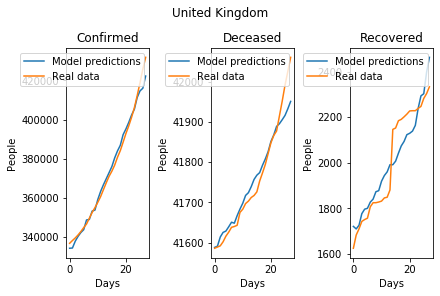

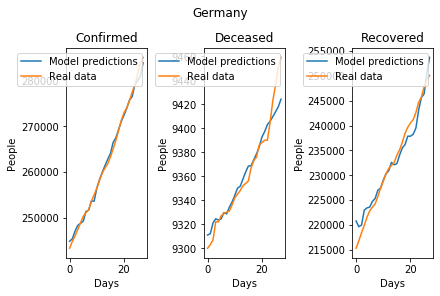

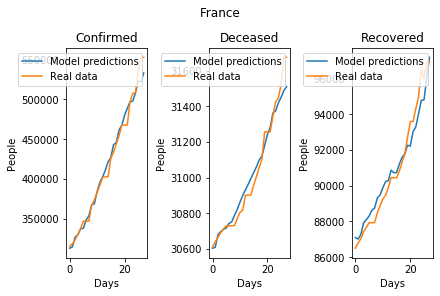

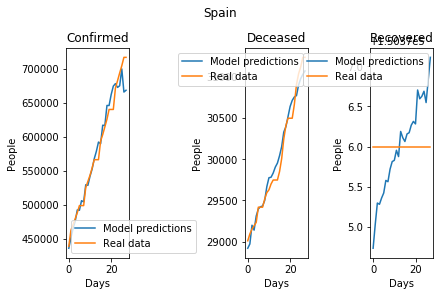

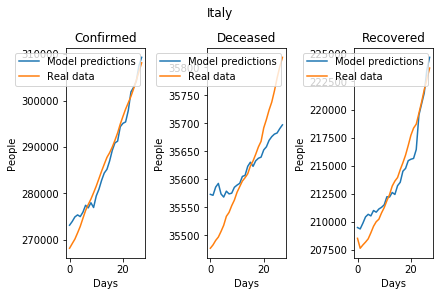

In [32]:
for country_name in EXAMPLE_COUTRIES:
    predictions, test_y = prepare_country_data_for_plots(country_name, enc_names, rescaled_predictions)
    plot_pred_v_data(predictions, test_y, country_name)

In [33]:
plt.show()